In [1]:
import sys
sys.path.append(r"C:\Users\zhossai3\Desktop\Fair_Imputation") 


import Utils
import CMI
import Inject_Missing_Values
import RR_imputer
import Sinkhorn_CMI
import SinkhornImputation
import SoftImpute



c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from Utils import *
from SoftImpute import softimpute, cv_softimpute
from SinkhornImputation import SinkhornImputation
from Sinkhorn_CMI import *
from RR_imputer import RRimputer
import matplotlib.pyplot as plt
from CMI import *
from Experiment import *
from sklearn.model_selection import KFold

from Inject_Missing_Values import *

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")
import pandas as pd

torch.set_default_tensor_type('torch.DoubleTensor')

**Load Data**

In [27]:
import pandas as pd

# Read CSV file into a Pandas DataFrame
groundTruth = pd.read_csv(r'C:\Users\zhossai3\Desktop\Fair_Imputation\Data\Heart Failour\heart_failour_only_binary.csv', delimiter=',', header=0)

In [28]:
groundTruth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


Checking Number of unique values

In [29]:
groundTruth.nunique()

Age                50
Sex                 2
ChestPainType       2
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          2
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            2
HeartDisease        2
dtype: int64

In [30]:
print("Age",groundTruth['Age'].unique())
print("Sex",groundTruth['Sex'].unique())
print("ChestPainType",groundTruth['ChestPainType'].unique())
print("RestingBP",groundTruth['RestingBP'].unique())
print("Cholesterol",groundTruth['Cholesterol'].unique())
print("FastingBS",groundTruth['FastingBS'].unique())
print("RestingECG",groundTruth['RestingECG'].unique())
print("MaxHR ",groundTruth['MaxHR'].unique())
print("ExerciseAngina",groundTruth['ExerciseAngina'].unique())
print("Oldpeak",groundTruth['Oldpeak'].unique())
print("ST_Slope",groundTruth['ST_Slope'].unique())
print("HeartDisease",groundTruth['HeartDisease'].unique())


Age [40 49 37 48 54 39 45 58 42 38 43 60 36 44 53 52 51 56 41 32 65 35 59 50
 47 31 46 57 55 63 66 34 33 61 29 62 28 30 74 68 72 64 69 67 73 70 77 75
 76 71]
Sex [0 1]
ChestPainType [0 1]
RestingBP [140 160 130 138 150 120 110 136 115 100 124 113 125 145 112 132 118 170
 142 190 135 180 108 155 128 106  92 200 122  98 105 133  95  80 137 185
 165 126 152 116   0 144 154 134 104 139 131 141 178 146 158 123 102  96
 143 172 156 114 127 101 174  94 148 117 192 129 164]
Cholesterol [289 180 283 214 195 339 237 208 207 284 211 164 204 234 273 196 201 248
 267 223 184 288 215 209 260 468 188 518 167 224 172 186 254 306 250 177
 227 230 294 264 259 175 318 216 340 233 205 245 194 270 213 365 342 253
 277 202 297 225 246 412 265 182 218 268 163 529 100 206 238 139 263 291
 229 307 210 329 147  85 269 275 179 392 466 129 241 255 276 282 338 160
 156 272 240 393 161 228 292 388 166 247 331 341 243 279 198 249 168 603
 159 190 185 290 212 231 222 235 320 187 266 287 404 312 251 328 285 280
 192 1

In [31]:
groundTruth.head(5)

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              0        160          180          0           0   
2   37    0              0        130          283          0           1   
3   48    1              1        138          214          0           0   
4   54    0              0        150          195          0           0   

   MaxHR  ExerciseAngina  Oldpeak  ST_Slope  HeartDisease  
0    172               0      0.0         0             0  
1    156               0      1.0         1             1  
2     98               0      0.0         0             0  
3    108               1      1.5         1             1  
4    122               0      0.0         0             0

Scalling the data to Z-score

In [32]:
groundTruth_numpy = groundTruth.to_numpy()
groundTruth_numpy = bucketize(groundTruth_numpy,{0:2})

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
groundTruth_scaled = pd.DataFrame(scaler.fit_transform(groundTruth_numpy), columns=groundTruth.columns)
print(groundTruth_scaled)


          Age       Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0   -1.171364 -0.515952      -1.200620   0.410909     0.825070  -0.551341   
1   -1.171364  1.938163      -1.200620   1.491752    -0.171961  -0.551341   
2   -1.171364 -0.515952      -1.200620  -0.129513     0.770188  -0.551341   
3   -1.171364  1.938163       0.832903   0.302825     0.139040  -0.551341   
4    0.853706 -0.515952      -1.200620   0.951331    -0.034755  -0.551341   
..        ...       ...            ...        ...          ...        ...   
913 -1.171364 -0.515952       0.832903  -1.210356     0.596393  -0.551341   
914  0.853706 -0.515952       0.832903   0.627078    -0.053049   1.813758   
915  0.853706 -0.515952       0.832903  -0.129513    -0.620168  -0.551341   
916  0.853706  1.938163      -1.200620  -0.129513     0.340275  -0.551341   
917 -1.171364 -0.515952      -1.200620   0.302825    -0.217696  -0.551341   

     RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease

In [34]:
X= groundTruth_scaled.iloc[:, :-1]  # Selects all rows and all columns except the last one
Y = groundTruth_scaled.iloc[:, -1]  # Selects all rows and only the last column


In [35]:
print("Age",groundTruth_scaled['Age'].unique())
print("Sex",groundTruth_scaled['Sex'].unique())
print("ChestPainType",groundTruth_scaled['ChestPainType'].unique())
#print("RestingBP",groundTruth_scaled['RestingBP'].unique())
#print("Cholesterol",groundTruth_scaled['Cholesterol'].unique())
print("FastingBS",groundTruth_scaled['FastingBS'].unique())
print("RestingECG",groundTruth_scaled['RestingECG'].unique())
#print("MaxHR ",groundTruth_scaled['MaxHR'].unique())
print("ExerciseAngina",groundTruth_scaled['ExerciseAngina'].unique())
print("Oldpeak",groundTruth_scaled['Oldpeak'].unique())
print("ST_Slope",groundTruth_scaled['ST_Slope'].unique())
print("HeartDisease",groundTruth_scaled['HeartDisease'].unique())


Age [-1.17136375  0.85370578]
Sex [-0.51595242  1.93816322]
ChestPainType [-1.20062041  0.83290272]
FastingBS [-0.55134134  1.81375843]
RestingECG [-0.81427482  1.22808661]
ExerciseAngina [-0.8235563   1.21424608]
Oldpeak [-0.83243239  0.10566353  0.57471149  1.04375945  1.98185537  2.91995129
 -0.36338443  1.51280741  3.85804721 -0.08195566 -0.17576525  0.4809019
  1.13756904 -0.45719402 -0.64481321  0.76233067  1.23137863 -0.7386228
  0.66852108  0.3870923  -0.55100362  0.85614026  1.606617   -1.67671872
  1.79423618 -3.27148179 -2.23957627 -0.92624199  0.01185394  0.19947312
  1.41899782 -1.77052831 -1.86433791 -1.48909954 -1.58290913  2.63852251
  0.29328271 -1.30148035 -2.70862423  0.94994986  2.45090333 -0.26957484
  2.07566496  1.32518822  2.35709374  2.54471292  3.10757047  2.16947455
  4.42090476  2.73233211  1.88804578  4.98376231  3.29518966]
ST_Slope [-1.15067399  0.86905588]
HeartDisease [-1.11311472  0.89837999]


Converting GroudTruth to Tensor

In [36]:
groundTruth_tensor = torch.tensor(groundTruth_scaled.to_numpy()) #converting groundTruth to Tensor
#groundTruth_tensor = torch.tensor(groundTruth_numpy)

In [37]:
print(torch.unique(groundTruth_tensor[:,0])) # coloumn 19 is sex where 1 is male and 0 is female.after scaling male is 0.6703 and female is -1.4919

tensor([-1.1714,  0.8537])


In [38]:
print("minimum: ",groundTruth_tensor.min())
print("maximum:",groundTruth_tensor.max())
print("mean: ",groundTruth_tensor.mean())
print("median: ", groundTruth_tensor.median())

minimum:  tensor(-7.1550)
maximum: tensor(4.9838)
mean:  tensor(1.9350e-17)
median:  tensor(-0.2676)


Determining the appropriate columns for bucketization along with their respective bucket sizes, and identifying the variables X, Y, and Z for Conditional Mutual Information (CMI) computation.

In [43]:
bucket_specs = {
    0:4, 
    1:2,
    11:2,
    2:4,
    3:10,
    4:10

}



# Define multiple attributes for X, Y, Z
X_cols = [0,1]  # Bucketized sensitive attributes (e.g., sex, race, age)
Y_cols = [11]     # Bucketized outcome-related attributes
Z_cols = [3,4,5,7]  


**CMI for GroundTruth**

In [44]:

groundTruth_tensor.requires_grad=True
cmi_groundTruth = CMI.c_m_i(groundTruth_tensor,bucket_specs,X_cols, Y_cols, Z_cols)
print(cmi_groundTruth)

tensor(0.1353, grad_fn=<ClampBackward1>)


Generating MCAR 25%, and added the target coloumn with the 25% missing MCAR data

In [ ]:
generator_mcar25 = Inject_Missing_Values()
miss_mcar25,index_mcar25 = generator_mcar25.MCAR(X,missing_rate=25)
print(type(miss_mcar25))
total_missing_percentage_mar25= miss_mcar25.isnull().sum().sum() / miss_mcar25.size * 100
print(f"Total Missing Percentage MAR25: {total_missing_percentage_mar25:.2f}%")

missing_percentage = (miss_mcar25.isnull().sum() / len(miss_mcar25)) * 100
print(missing_percentage)

miss_mcar25 = pd.concat([miss_mcar25, Y], axis=1) #adding the target coloumn

<class 'pandas.core.frame.DataFrame'>
Total Missing Percentage MAR25: 25.00%
Age               25.599129
Sex               25.816993
ChestPainType     25.490196
RestingBP         25.708061
Cholesterol       27.124183
FastingBS         24.727669
RestingECG        23.638344
MaxHR             22.875817
ExerciseAngina    23.965142
Oldpeak           26.797386
ST_Slope          23.202614
dtype: float64


In [ ]:

miss_mcar25_numpy = miss_mcar25.to_numpy()
miss_mcar25_tensor = torch.tensor(miss_mcar25_numpy) #converting to tensor

In [ ]:
print(torch.unique(miss_mcar25_tensor[:,1]))

tensor([-0.5160,  1.9382,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     nan,     nan,     nan,     nan,     nan,
            nan,     nan,     nan,     n

Applying Sinkhorn algorithm to MCAR 25% data

In [ ]:
#only Sinkhorn
n_mcar25, d_mcar25 = miss_mcar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar25 = pick_epsilon(miss_mcar25_tensor)
print(epsilon_mcar25)
mask_mcar25 = torch.isnan(miss_mcar25_tensor).double()


on_sk_imputer_mcar25 = SinkhornImputation(eps=epsilon_mcar25, batchsize=batchsize, lr=lr, niter=5000)
on_sk_imp_mcar25, on_sk_maes25mcar, on_sk_rmses25mcar = on_sk_imputer_mcar25.fit_transform(miss_mcar25_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mcar25_numpy = on_sk_imp_mcar25.detach().cpu().numpy()
on_sk_mae_mcar25 = MAE(on_sk_imp_mcar25,groundTruth_tensor , mask_mcar25)
on_sk_rmse_mcar25 = RMSE(on_sk_imp_mcar25, groundTruth_tensor, mask_mcar25)
print("MAE:", on_sk_mae_mcar25)


0.4378611185597029


KeyboardInterrupt: 

Calculating CMI after applying the Sinkhorn Imputation (only Sinkhorn algorithm)

In [ ]:
#only CMI
on_cmi_missmcar25 = CMI.c_m_i(on_sk_imp_mcar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:", on_cmi_missmcar25)
print("MAE:",on_sk_mae_mcar25)

CMI: tensor(0.1722, grad_fn=<ClampBackward1>)
MAE: tensor(0.6670, grad_fn=<DivBackward0>)


Applying Sinkhorn-CMI algorithm to MCAR 25%

In [ ]:
#sinkhorn_CMI
n_mcar25, d_mcar25 = miss_mcar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar25 = pick_epsilon(miss_mcar25_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mcar25)
mask_mcar25  = torch.isnan(miss_mcar25_tensor).double()


sk_imputer_mcar25 = SinkhornImputation_CMI(eps=epsilon_mcar25, batchsize=batchsize, lr=lr, niter=5000,highest_lamda_cmi = 500)
sk_imp_mcar25, sk_maes25mcar, sk_rmses25mcar,cmi_loss_mcar25,sinkhorn_loss_mcar25, lamda_cmi_mcar25 = sk_imputer_mcar25.fit_transform(miss_mcar25_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mcar25_numpy = sk_imp_mcar25.detach().cpu().numpy()

sk_mae_mcar25 = MAE(sk_imp_mcar25,groundTruth_tensor , mask_mcar25)
sk_rmse_mcar25 = RMSE(sk_imp_mcar25, groundTruth_tensor, mask_mcar25)
print("MAE:",sk_mae_mcar25)





0.4354963098529025


INFO:root:Iteration 0:	 Loss: 2.3668	 Validation MAE: 0.8530	RMSE: 1.0142
INFO:root:Iteration 50:	 Loss: 2.0896	 Validation MAE: 0.7695	RMSE: 0.9925
INFO:root:Iteration 100:	 Loss: 2.3509	 Validation MAE: 0.7428	RMSE: 0.9897
INFO:root:Iteration 150:	 Loss: 2.0824	 Validation MAE: 0.7307	RMSE: 0.9899
INFO:root:Iteration 200:	 Loss: 2.1469	 Validation MAE: 0.7256	RMSE: 0.9920
INFO:root:Iteration 250:	 Loss: 2.0563	 Validation MAE: 0.7235	RMSE: 0.9943
INFO:root:Iteration 300:	 Loss: 2.0648	 Validation MAE: 0.7215	RMSE: 0.9956
INFO:root:Iteration 350:	 Loss: 2.0370	 Validation MAE: 0.7208	RMSE: 0.9976
INFO:root:Iteration 400:	 Loss: 2.3094	 Validation MAE: 0.7202	RMSE: 0.9987
INFO:root:Iteration 450:	 Loss: 2.0551	 Validation MAE: 0.7208	RMSE: 1.0004
INFO:root:Iteration 500:	 Loss: 2.0874	 Validation MAE: 0.7232	RMSE: 1.0025
INFO:root:Iteration 550:	 Loss: 2.5485	 Validation MAE: 0.7242	RMSE: 1.0053
INFO:root:Iteration 600:	 Loss: 2.2145	 Validation MAE: 0.7238	RMSE: 1.0071
INFO:root:Itera

MAE: tensor(0.7397, grad_fn=<DivBackward0>)


CMI for Sinkhorn_CMI Imputation

In [ ]:
#CMI
sk_cmi_mcar25 = CMI.c_m_i(sk_imp_mcar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI",sk_cmi_mcar25)
print("MAE",sk_mae_mcar25)

CMI tensor(0.0001, grad_fn=<ClampBackward1>)
MAE tensor(0.7397, grad_fn=<DivBackward0>)


Mean imputation, MAE and CMI

In [ ]:

mean_imp_mcar25 = SimpleImputer().fit_transform(miss_mcar25_tensor)
mean_imp_mcar25_torch = torch.tensor(mean_imp_mcar25)
mean_mae_mcar25 = MAE(mean_imp_mcar25_torch, groundTruth_tensor , mask_mcar25)

print("MAE",mean_mae_mcar25)

cmi_mean_mcar25 = CMI.c_m_i(mean_imp_mcar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI",cmi_mean_mcar25)

MAE tensor(0.8486, grad_fn=<DivBackward0>)
CMI tensor(0.2114, grad_fn=<ClampBackward1>)


Imputation by Chained Equations, CMI and MAE

In [ ]:
ice_imp_mcar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(miss_mcar25_tensor)
ice_imp_mcar25_torch = torch.tensor(ice_imp_mcar25)
ice_mae_mcar25 = MAE(ice_imp_mcar25_torch, groundTruth_tensor , mask_mcar25)
print("MAE",ice_mae_mcar25)

cmi_ice_mcar25 = CMI.c_m_i(ice_imp_mcar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI",cmi_ice_mcar25)

MAE tensor(0.7118, grad_fn=<DivBackward0>)
CMI tensor(0.1850, grad_fn=<ClampBackward1>)


Soft Imputation CMI and MAE

In [ ]:
cv_error_mcar25, grid_lambda_mcar25 = cv_softimpute(miss_mcar25_numpy, grid_len=15)
lbda_mcar25 = grid_lambda_mcar25[np.argmin(cv_error_mcar25)]
soft_imp_mcar25 = softimpute((miss_mcar25_numpy), lbda_mcar25)[1]
soft_imp_mcar25_torch = torch.tensor(soft_imp_mcar25)

soft_mae_mcar25 = MAE(soft_imp_mcar25_torch, groundTruth_tensor , mask_mcar25)
print("MAE",soft_mae_mcar25)

cmi_soft_mcar25 = CMI.c_m_i(soft_imp_mcar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI",cmi_soft_mcar25)

MAE tensor(0.7429, grad_fn=<DivBackward0>)
CMI tensor(0.1893, grad_fn=<ClampBackward1>)


### Visualization

Sinkhorn loss vs Sinkhorn Iteration

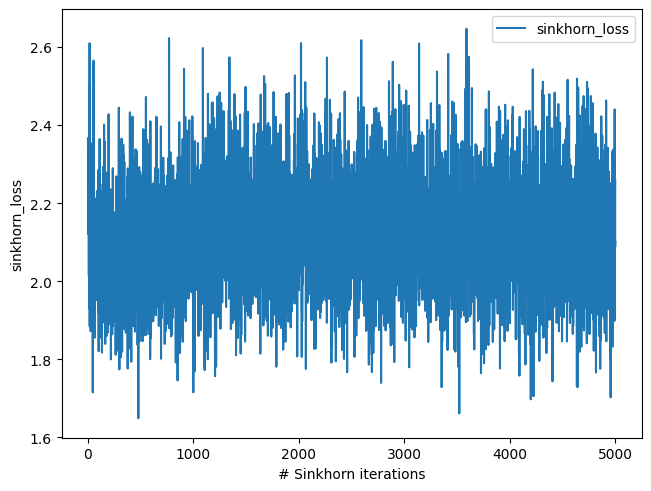

In [ ]:
sinkhorn_loss_mcar25 = torch.tensor(sinkhorn_loss_mcar25)
fig, ax = plt.subplots(constrained_layout=True)

npoints = len(sinkhorn_loss_mcar25)

ax.plot(np.linspace(0, 1, npoints) * npoints, sinkhorn_loss_mcar25.detach().numpy(), label='sinkhorn_loss')

ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.set_ylabel('sinkhorn_loss')
plt.legend()
plt.show()

CMI and MAE vs Sinkhorn Iterations

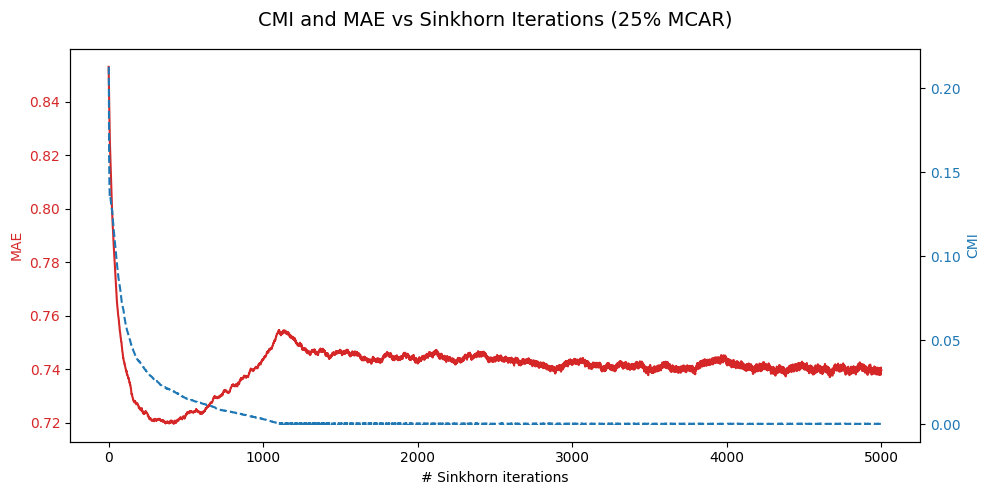

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual PyTorch tensors if needed)
# Convert to NumPy if these are tensors
cmi_array = cmi_loss_mcar25
mae_array = sk_maes25mcar

# Ensure both arrays are same length (or handle separately if needed)
npoints = min(len(cmi_array), len(mae_array))
x = np.linspace(0, 1, npoints) * npoints  # X-axis: Sinkhorn iterations

# Truncate both arrays to the same length for plotting
cmi_array = cmi_array[:npoints]
mae_array = mae_array[:npoints]

# Create a single plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot MAE (left axis)
color = 'tab:red'
ax1.set_xlabel('# Sinkhorn iterations')
ax1.set_ylabel('MAE', color=color)
ax1.plot(x, mae_array, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# Plot CMI (right axis)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(x, cmi_array, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

# Titles and layout
fig.suptitle('CMI and MAE vs Sinkhorn Iterations (25% MCAR)', fontsize=14)
fig.tight_layout()
plt.show()


MAE and CMI vs lambda_cmi

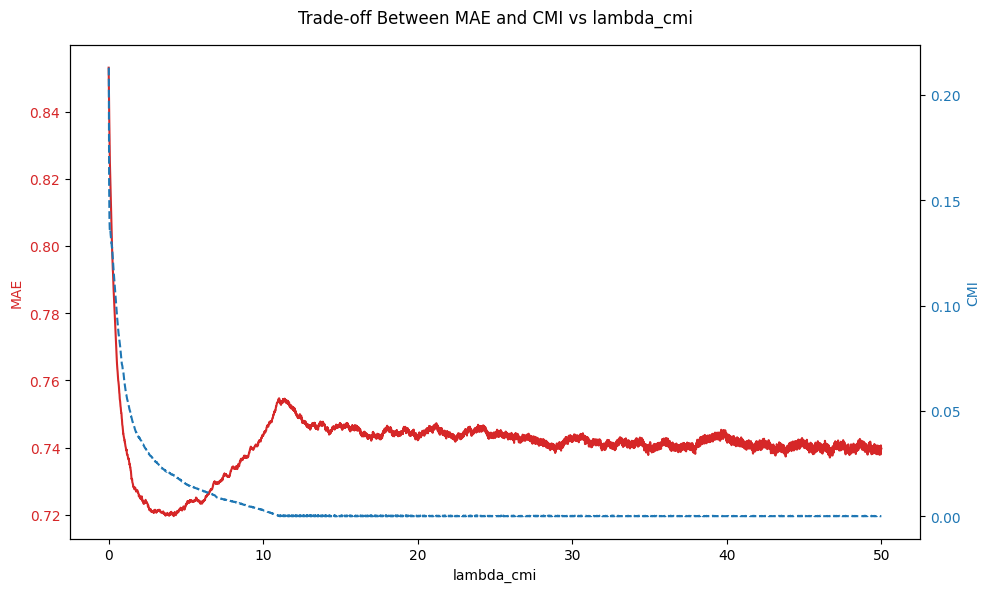

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated from your training log — you should replace these with actual histories
cmi_penalty_history = cmi_loss_mcar25 # list of length 2000 from your model
mae_history = sk_maes25mcar         # list of length 2000 from your model

iterations = np.arange(len(cmi_penalty_history))
lambda_cmi_values = lamda_cmi_mcar25

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# MAE
color = 'tab:red'
ax1.set_xlabel('lambda_cmi')
ax1.set_ylabel('MAE', color=color)
ax1.plot(lambda_cmi_values, mae_history, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# CMI on same plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(lambda_cmi_values, cmi_penalty_history, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Trade-off Between MAE and CMI vs lambda_cmi')
fig.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Convert to arrays
mae_array_mcar25 = np.array(sk_maes25mcar)
cmi_array_mcar25 = np.array(cmi_loss_mcar25)
lambda_array_mcar25 = np.array(lamda_cmi_mcar25)

# OPTIONAL: Skip very low lambda values (e.g., lambda = 0)
min_index = 10  # or 0 if you want to include everything

# ---- Option 1: Visual Match (Rescale CMI to MAE's range) ----
min_mae_mcar25, max_mae_mcar25 = mae_array_mcar25.min(), mae_array_mcar25.max()
min_cmi_mcar25, max_cmi_mcar25 = cmi_array_mcar25.min(), cmi_array_mcar25.max()

# Rescale CMI to the MAE axis range
cmi_rescaled_mcar25 = (cmi_array_mcar25 - min_cmi_mcar25) / (max_cmi_mcar25 - min_cmi_mcar25) * (max_mae_mcar25 - min_mae_mcar25) + min_mae_mcar25

# Compute difference between MAE and rescaled CMI
diff_mcar25 = np.abs(mae_array_mcar25[min_index:] - cmi_rescaled_mcar25[min_index:])
intersection_idx_mcar25 = np.argmin(diff_mcar25) + min_index  # add offset

# ---- Extract Values at Intersection ----
lambda_intersection_mcra25 = lambda_array_mcar25[intersection_idx_mcar25]
mae_val_mcar25 = mae_array_mcar25[intersection_idx_mcar25]
cmi_val_mcar25 = cmi_array_mcar25[intersection_idx_mcar25]

# ---- Display Result ----
print("Estimated Visual Intersection Point MCAR25:")
print(f"  lambda_cmi_mcar25 = {lambda_intersection_mcra25:.4f}")
print(f"  MAE_mcar25        = {mae_val_mcar25:.4f}")
print(f"  CMI_mcar25        = {cmi_val_mcar25:.4f}")


Estimated Visual Intersection Point MCAR25:
  lambda_cmi_mcar25 = 6.5000
  MAE_mcar25        = 0.7265
  CMI_mcar25        = 0.0109


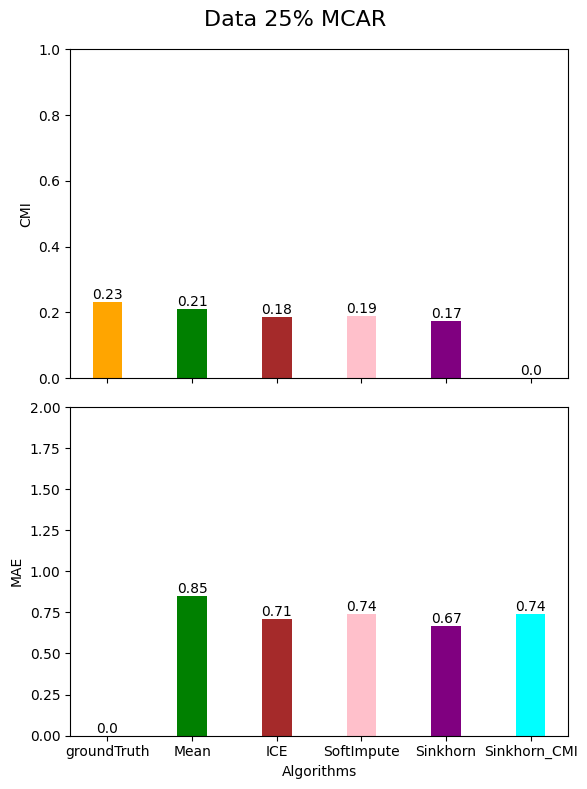

In [ ]:

# Define values and categories
values_cmi_mcar25 = [cmi_groundTruth.detach(),cmi_mean_mcar25.detach(),cmi_ice_mcar25.detach(),cmi_soft_mcar25.detach(),on_cmi_missmcar25.detach(),sk_cmi_mcar25.detach()]
values_maes_mcar25 = [0.0,mean_mae_mcar25.detach(),ice_mae_mcar25.detach(), soft_mae_mcar25.detach(),on_sk_mae_mcar25.detach(),sk_mae_mcar25.detach()]
categories = ["groundTruth","Mean","ICE","SoftImpute","Sinkhorn","Sinkhorn_CMI"]
colors = ['orange','green','brown','pink','purple', 'cyan']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MCAR', fontsize=16)

# Plot CMI bars and add values on top
bars1 = ax1.bar(index, values_cmi_mcar25, color=colors, width=bar_width)
ax1.set_ylabel("CMI")
ax1.set_ylim(0, 1) 
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot MAE bars and add values on top
bars2 = ax2.bar(index, values_maes_mcar25, color=colors, width=bar_width)
ax2.set_ylabel("MAE")
ax2.set_ylim(0, 2) 
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')


ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Algorithms')
plt.tight_layout()
plt.show()


**25% MAR**

In [ ]:
mean_age = groundTruth_scaled["Age"].mean()
median_age = groundTruth_scaled["Age"].median()



dependencies_mar = {

    "ChestPainType": {
        "influencers": ["Age"],
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Age"] <= mean_age else 0.2 
    },
    "Cholesterol": {
        "influencers": ["Age"],
        "condition": lambda row: True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Age"] < mean_age else 0.2 
    },
    "RestingBP": {
        "influencers": ["Sex"],
        "condition":  lambda row: True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Sex"] == -0.51595242 else 0.2 
    },
    "RestingECG": {
        "influencers": ["Sex"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Sex"] == -0.51595242 else 0.1
    },
    "MaxHR": {
        "influencers": ["Sex"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Sex"] == 1.93816322 else 0.2 
    },
    
    "ExerciseAngina": {
        "influencers": ["Age"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Age"] < median_age else 0.2 
    },

    "Oldpeak": {
        "influencers": ["Age"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Age"] >= median_age else 0.2 
    },

    "ST_Slope": {
        "influencers": ["Sex"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Sex"] == 1.93816322 else 0.2 
    }



}


"""""""""""""""""
Age [-1.4331398  -0.47848359 -1.75135854 -0.5845565   0.05188098 -1.53921271
 -0.90277524  0.47617263 -1.22099397 -1.64528563 -1.11492106  0.68831845
 -1.85743145 -1.00884815 -0.05419193 -0.16026485 -0.26633776  0.2640268
 -1.32706689 -2.2817231   1.21868302 -1.96350436  0.58224554 -0.37241067
 -0.69062941 -2.38779602 -0.79670232  0.37009972  0.15795389  1.00653719
  1.32475593 -2.06957728 -2.17565019  0.79439137 -2.59994184  0.90046428
 -2.70601475 -2.49386893  2.17333923  1.53690176  1.96119341  1.11261011
  1.64297467  1.43082884  2.06726632  1.74904758  2.49155797  2.27941215
  2.38548506  1.85512049]
Sex [-0.51595242  1.93816322]
ChestPainType [-1.70557305 -0.53099236  0.64358833  1.81816902]
FastingBS [-0.55134134  1.81375843]
RestingECG [-0.74917967  0.49224079  1.73366125]
ExerciseAngina [-0.8235563   1.21424608]
Oldpeak [-0.83243239  0.10566353  0.57471149  1.04375945  1.98185537  2.91995129
 -0.36338443  1.51280741  3.85804721 -0.08195566 -0.17576525  0.4809019
  1.13756904 -0.45719402 -0.64481321  0.76233067  1.23137863 -0.7386228
  0.66852108  0.3870923  -0.55100362  0.85614026  1.606617   -1.67671872
  1.79423618 -3.27148179 -2.23957627 -0.92624199  0.01185394  0.19947312
  1.41899782 -1.77052831 -1.86433791 -1.48909954 -1.58290913  2.63852251
  0.29328271 -1.30148035 -2.70862423  0.94994986  2.45090333 -0.26957484
  2.07566496  1.32518822  2.35709374  2.54471292  3.10757047  2.16947455
  4.42090476  2.73233211  1.88804578  4.98376231  3.29518966]
ST_Slope [-1.05211381  0.59607813  2.24427006]
HeartDisease [-1.11311472  0.89837999]

"""""""""""""""

'""\nAge [-1.4331398  -0.47848359 -1.75135854 -0.5845565   0.05188098 -1.53921271\n -0.90277524  0.47617263 -1.22099397 -1.64528563 -1.11492106  0.68831845\n -1.85743145 -1.00884815 -0.05419193 -0.16026485 -0.26633776  0.2640268\n -1.32706689 -2.2817231   1.21868302 -1.96350436  0.58224554 -0.37241067\n -0.69062941 -2.38779602 -0.79670232  0.37009972  0.15795389  1.00653719\n  1.32475593 -2.06957728 -2.17565019  0.79439137 -2.59994184  0.90046428\n -2.70601475 -2.49386893  2.17333923  1.53690176  1.96119341  1.11261011\n  1.64297467  1.43082884  2.06726632  1.74904758  2.49155797  2.27941215\n  2.38548506  1.85512049]\nSex [-0.51595242  1.93816322]\nChestPainType [-1.70557305 -0.53099236  0.64358833  1.81816902]\nFastingBS [-0.55134134  1.81375843]\nRestingECG [-0.74917967  0.49224079  1.73366125]\nExerciseAngina [-0.8235563   1.21424608]\nOldpeak [-0.83243239  0.10566353  0.57471149  1.04375945  1.98185537  2.91995129\n -0.36338443  1.51280741  3.85804721 -0.08195566 -0.17576525  0.48

Generating MAR 25%, and added the target coloumn with the 25% missing MAR data

In [ ]:
generator_mar25 = Inject_Missing_Values()
miss_mar25,index_mar25 = generator_mar25.MAR(X,dependencies_mar,missing_rate=25)
miss_mar25 = pd.concat([miss_mar25, Y], axis=1) #adding the target coloumn

total_missing_percentage_mar25 = miss_mar25.isnull().sum().sum() / miss_mar25.size * 100
print(f"Total Missing Percentage MAR25: {total_missing_percentage_mar25:.2f}%")

Total Missing Percentage MAR25: 22.91%


In [ ]:
missing_percentage = (miss_mar25.isnull().sum() / len(miss_mar25)) * 100
print(missing_percentage)

Age                0.000000
Sex                0.000000
ChestPainType     41.938998
RestingBP         28.867102
Cholesterol       42.483660
FastingBS          0.000000
RestingECG        13.725490
MaxHR             31.372549
ExerciseAngina    44.662309
Oldpeak           43.355120
ST_Slope          28.540305
HeartDisease       0.000000
dtype: float64


In [ ]:
miss_mar25_numpy = miss_mar25.to_numpy()
miss_mar25_tensor = torch.tensor(miss_mar25_numpy) #converting to tensor

In [ ]:
print(miss_mar25.head(5))

        Age       Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0 -1.433140 -0.515952      -1.705573   0.410909          NaN  -0.551341   
1 -0.478484  1.938163      -0.530992   1.491752          NaN  -0.551341   
2 -1.751359 -0.515952      -1.705573  -0.129513          NaN  -0.551341   
3 -0.584556  1.938163       0.643588   0.302825          NaN  -0.551341   
4  0.051881 -0.515952            NaN        NaN          NaN  -0.551341   

   RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0   -0.749180  1.382928       -0.823556 -0.832432 -1.052114     -1.113115  
1         NaN  0.754157             NaN  0.105664       NaN      0.898380  
2    0.492241 -1.525138       -0.823556 -0.832432       NaN     -1.113115  
3   -0.749180 -1.132156        1.214246  0.574711  0.596078      0.898380  
4         NaN       NaN       -0.823556       NaN -1.052114     -1.113115  


Applying Sinkhorn algorithm to MAR 25% data

In [ ]:
#only Sinkhorn
n_mar25, d_mar25 = miss_mar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar25 = pick_epsilon(miss_mar25_tensor)
print(epsilon_mar25)
mask_mar25= torch.isnan(miss_mar25_tensor).double()


on_sk_imputer_mar25 = SinkhornImputation(eps=epsilon_mar25, batchsize=batchsize, lr=lr, niter=5000)
on_sk_imp_mar25, on_sk_maes25mar, on_sk_rmses25mar = on_sk_imputer_mar25.fit_transform(miss_mar25_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mar25_numpy = on_sk_imp_mar25.detach().cpu().numpy()
on_sk_mae_mar25 = MAE(on_sk_imp_mar25,groundTruth_tensor , mask_mar25)
on_sk_rmse_mar25 = RMSE(on_sk_imp_mar25, groundTruth_tensor, mask_mar25)
print("MAE:",on_sk_mae_mar25)

0.43941501276114137

INFO:root:batchsize = 128, epsilon = 0.4394


INFO:root:Iteration 0:	 Loss: 1.9885	 Validation MAE: 0.8530	RMSE: 1.0099
INFO:root:Iteration 50:	 Loss: 1.9340	 Validation MAE: 0.7766	RMSE: 0.9591
INFO:root:Iteration 100:	 Loss: 1.9330	 Validation MAE: 0.7473	RMSE: 0.9445


INFO:root:Iteration 150:	 Loss: 2.6087	 Validation MAE: 0.7240	RMSE: 0.9336
INFO:root:Iteration 200:	 Loss: 2.0458	 Validation MAE: 0.7107	RMSE: 0.9279
INFO:root:Iteration 250:	 Loss: 2.1553	 Validation MAE: 0.7005	RMSE: 0.9240
INFO:root:Iteration 300:	 Loss: 2.0144	 Validation MAE: 0.6928	RMSE: 0.9208
INFO:root:Iteration 350:	 Loss: 2.0556	 Validation MAE: 0.6889	RMSE: 0.9209
INFO:root:Iteration 400:	 Loss: 1.8522	 Validation MAE: 0.6835	RMSE: 0.9200
INFO:root:Iteration 450:	 Loss: 1.6550	 Validation MAE: 0.6802	RMSE: 0.9209
INFO:root:Iteration 500:	 Loss: 1.9120	 Validation MAE: 0.6787	RMSE: 0.9211
INFO:root:Iteration 550:	 Loss: 2.0633	 Validation MAE: 0.6767	RMSE: 0.9216
INFO:root:Iteration 600:	 Loss: 1.9317	 Validation MAE: 0.6723	RMSE: 0.9191
INFO:root:Iteration 650:	 Loss: 1.8908	 Validation MAE: 0.6713	RMSE: 0.9198
INFO:root:Iteration 700:	 Loss: 2.0477	 Validation MAE: 0.6691	RMSE: 0.9188
INFO:root:Iteration 750:	 Loss: 1.8896	 Validation MAE: 0.6690	RMSE: 0.9197
INFO:root:It

MAE: tensor(0.6658, grad_fn=<DivBackward0>)


CMI for Sinkhorn Imputation

In [ ]:
#only CMI
on_cmi_missmar25 = CMI.c_m_i(on_sk_imp_mar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",on_cmi_missmar25)
print("MAE:",on_sk_mae_mar25)

CMI: tensor(0.1716, grad_fn=<ClampBackward1>)
MAE: tensor(0.6658, grad_fn=<DivBackward0>)


Applying Sinkhorn-CMI algorithm to MAR 25% data

In [ ]:
#sinkhorn_CMI
n_mar25, d_mar25 = miss_mar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar25 = pick_epsilon(miss_mar25_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mar25)
mask_mar25 = torch.isnan(miss_mar25_tensor).double()



sk_imputer_mar25 = SinkhornImputation_CMI(eps=epsilon_mar25, batchsize=batchsize, lr=lr, niter=5000,highest_lamda_cmi = 500)
sk_imp_mar25, sk_maes25mar, sk_rmses25mar,cmi_loss_mar25,sinkhorn_loss_mar25,lamda_cmi_mar25 = sk_imputer_mar25.fit_transform(miss_mar25_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mar25_numpy = sk_imp_mar25.detach().cpu().numpy()

sk_mae_mar25 = MAE(sk_imp_mar25,groundTruth_tensor , mask_mar25)
sk_rmse_mar25 = RMSE(sk_imp_mar25, groundTruth_tensor, mask_mar25)
print("MAE:",sk_mae_mar25)


0.43941501276114137


INFO:root:Iteration 0:	 Loss: 2.2621	 Validation MAE: 0.8508	RMSE: 1.0055


INFO:root:Iteration 50:	 Loss: 1.9701	 Validation MAE: 0.7754	RMSE: 0.9587
INFO:root:Iteration 100:	 Loss: 2.3790	 Validation MAE: 0.7510	RMSE: 0.9486
INFO:root:Iteration 150:	 Loss: 1.9076	 Validation MAE: 0.7348	RMSE: 0.9443
INFO:root:Iteration 200:	 Loss: 2.1167	 Validation MAE: 0.7264	RMSE: 0.9443
INFO:root:Iteration 250:	 Loss: 2.0263	 Validation MAE: 0.7215	RMSE: 0.9439
INFO:root:Iteration 300:	 Loss: 2.1866	 Validation MAE: 0.7149	RMSE: 0.9411
INFO:root:Iteration 350:	 Loss: 2.0173	 Validation MAE: 0.7113	RMSE: 0.9425
INFO:root:Iteration 400:	 Loss: 2.1679	 Validation MAE: 0.7067	RMSE: 0.9417
INFO:root:Iteration 450:	 Loss: 1.8592	 Validation MAE: 0.7041	RMSE: 0.9422
INFO:root:Iteration 500:	 Loss: 2.0714	 Validation MAE: 0.7035	RMSE: 0.9439
INFO:root:Iteration 550:	 Loss: 2.2938	 Validation MAE: 0.7021	RMSE: 0.9449
INFO:root:Iteration 600:	 Loss: 1.9945	 Validation MAE: 0.6993	RMSE: 0.9442
INFO:root:Iteration 650:	 Loss: 1.9269	 Validation MAE: 0.6964	RMSE: 0.9438
INFO:root:Ite

MAE: tensor(0.6984, grad_fn=<DivBackward0>)


CMI for Sinkhorn_CMI Imputation

In [ ]:
#CMI
cmi_mar25 = CMI.c_m_i(sk_imp_mar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_mar25)
print("MAE:",sk_mae_mar25)

CMI: tensor(0.0001, grad_fn=<ClampBackward1>)
MAE: tensor(0.6984, grad_fn=<DivBackward0>)


Mean Imputation, CMI and MAE

In [ ]:

mean_imp_mar25 = SimpleImputer().fit_transform(miss_mar25_tensor)
mean_imp_mar25_torch = torch.tensor(mean_imp_mar25)
mean_mae_mar25 = MAE(mean_imp_mar25_torch, groundTruth_tensor , mask_mar25)

print("MAE:",mean_mae_mar25)

cmi_mean_mar25 = CMI.c_m_i(mean_imp_mar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_mean_mar25)

MAE: tensor(0.8491, grad_fn=<DivBackward0>)
CMI: tensor(0.1874, grad_fn=<ClampBackward1>)


Imputation by Chained Equations, CMI and MAE

In [ ]:
ice_imp_mar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(miss_mar25_tensor)
ice_imp_mar25_torch = torch.tensor(ice_imp_mar25)
ice_mae_mar25 = MAE(ice_imp_mar25_torch, groundTruth_tensor , mask_mar25)
print("MAE:",ice_mae_mar25)

cmi_ice_mar25 = CMI.c_m_i(ice_imp_mar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_ice_mar25)

MAE: tensor(0.8330, grad_fn=<DivBackward0>)
CMI: tensor(0.1967, grad_fn=<ClampBackward1>)


Soft Imputation CMI and MAE

In [ ]:
cv_error_mar25, grid_lambda_mar25 = cv_softimpute(miss_mar25_numpy, grid_len=15)
lbda_mar25 = grid_lambda_mar25[np.argmin(cv_error_mar25)]
soft_imp_mar25 = softimpute((miss_mar25_numpy), lbda_mar25)[1]
soft_imp_mar25_torch = torch.tensor(soft_imp_mar25)

soft_mae_mar25 = MAE(soft_imp_mar25_torch, groundTruth_tensor , mask_mar25)
print("MAE:",soft_mae_mar25)

cmi_soft_mar25 = CMI.c_m_i(soft_imp_mar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_soft_mar25)

MAE: tensor(0.7308, grad_fn=<DivBackward0>)
CMI: tensor(0.1518, grad_fn=<ClampBackward1>)


### Visualization

Sinkhorn loss vs Sinkhorn Iterations

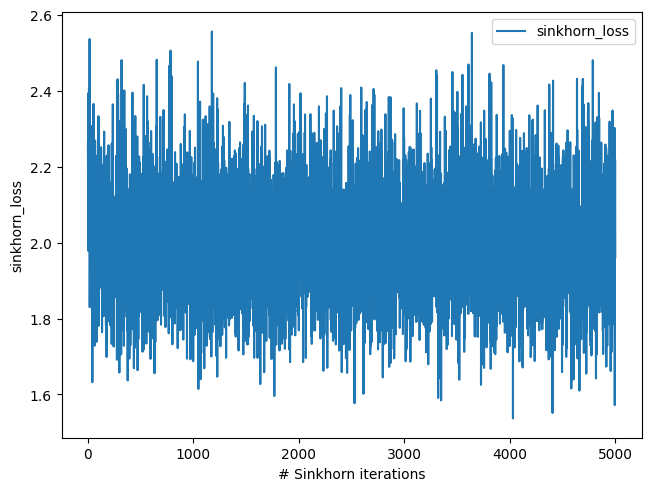

In [ ]:
sinkhorn_loss_mar25 = torch.tensor(sinkhorn_loss_mar25)
fig, ax = plt.subplots(constrained_layout=True)

npoints = len(sinkhorn_loss_mar25)

ax.plot(np.linspace(0, 1, npoints) * npoints, sinkhorn_loss_mar25.detach().numpy(), label='sinkhorn_loss')

ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.set_ylabel('sinkhorn_loss')
plt.legend()
plt.show()

CMI and MAE vs Sinkhorn Iterations

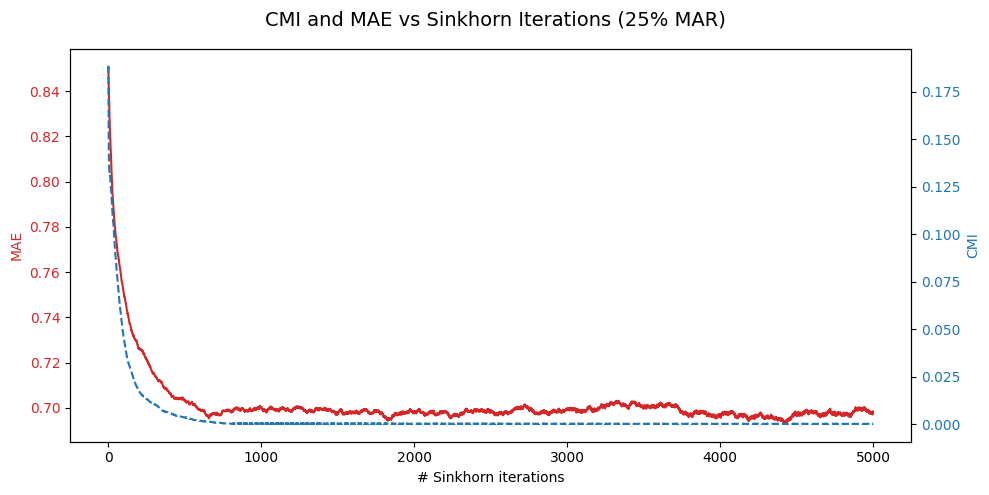

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual PyTorch tensors if needed)
# Convert to NumPy if these are tensors
cmi_array = cmi_loss_mar25
mae_array = sk_maes25mar

# Ensure both arrays are same length (or handle separately if needed)
npoints = min(len(cmi_array), len(mae_array))
x = np.linspace(0, 1, npoints) * npoints  # X-axis: Sinkhorn iterations

# Truncate both arrays to the same length for plotting
cmi_array = cmi_array[:npoints]
mae_array = mae_array[:npoints]

# Create a single plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot MAE (left axis)
color = 'tab:red'
ax1.set_xlabel('# Sinkhorn iterations')
ax1.set_ylabel('MAE', color=color)
ax1.plot(x, mae_array, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# Plot CMI (right axis)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(x, cmi_array, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

# Titles and layout
fig.suptitle('CMI and MAE vs Sinkhorn Iterations (25% MAR)', fontsize=14)
fig.tight_layout()
plt.show()


MAE and CMI vs lambda_cmi

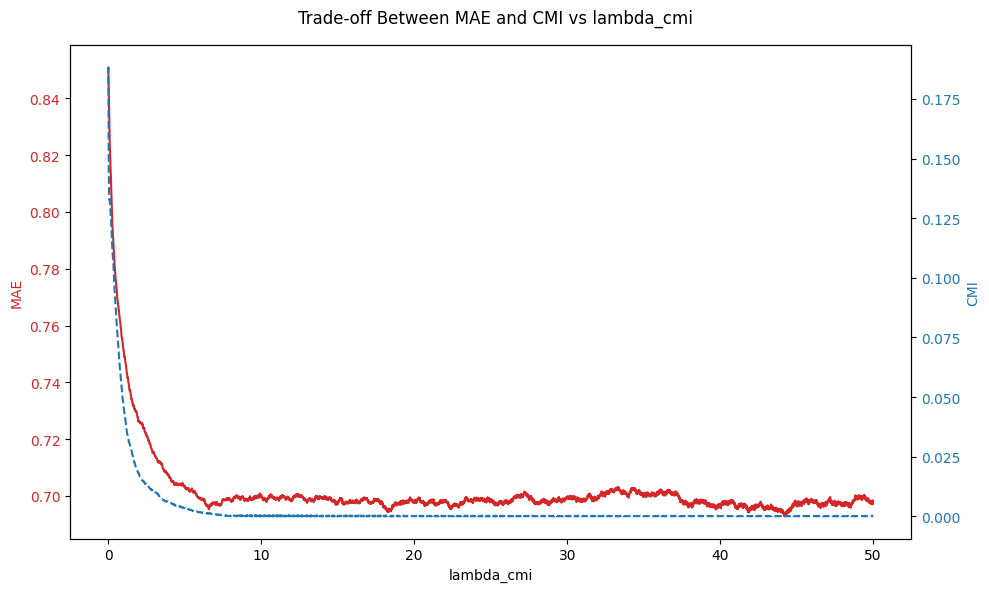

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated from your training log — you should replace these with actual histories
cmi_penalty_history = cmi_loss_mar25 # list of length 2000 from your model
mae_history = sk_maes25mar         # list of length 2000 from your model

iterations = np.arange(len(cmi_penalty_history))
lambda_cmi_values = lamda_cmi_mar25

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# MAE
color = 'tab:red'
ax1.set_xlabel('lambda_cmi')
ax1.set_ylabel('MAE', color=color)
ax1.plot(lambda_cmi_values, mae_history, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# CMI on same plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(lambda_cmi_values, cmi_penalty_history, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Trade-off Between MAE and CMI vs lambda_cmi')
fig.tight_layout()
plt.show()


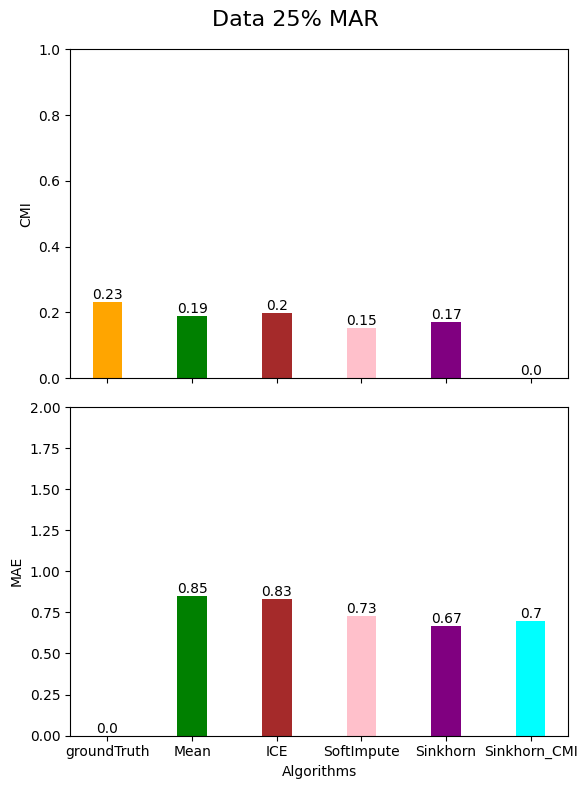

In [ ]:

# Define values and categories
values_cmi_mar25 = [cmi_groundTruth.detach(),cmi_mean_mar25.detach(),cmi_ice_mar25.detach(),cmi_soft_mar25.detach(),on_cmi_missmar25.detach(),cmi_mar25.detach()]
values_maes_mar25 = [0.0,mean_mae_mar25.detach(),ice_mae_mar25.detach(), soft_mae_mar25.detach(),on_sk_mae_mar25.detach(),sk_mae_mar25.detach()]
categories = ["groundTruth","Mean","ICE","SoftImpute","Sinkhorn","Sinkhorn_CMI"]
colors = ['orange','green','brown','pink','purple', 'cyan']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MAR', fontsize=16)

# Plot CMI bars and add values on top
bars1 = ax1.bar(index, values_cmi_mar25, color=colors, width=bar_width)
ax1.set_ylabel("CMI")
ax1.set_ylim(0, 1) 
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot MAE bars and add values on top
bars2 = ax2.bar(index, values_maes_mar25, color=colors, width=bar_width)
ax2.set_ylabel("MAE")
ax2.set_ylim(0, 2) 
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')


ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Algorithms')
plt.tight_layout()
plt.show() #display 


**25% MNAR**

In [ ]:
mean_Cholesterol = groundTruth_scaled["Cholesterol"].mean()
mean_RestingBP = groundTruth_scaled["RestingBP"].mean()
mean_RestingECG = groundTruth_scaled["RestingECG"].mean()
mean_MaxHR = groundTruth_scaled["MaxHR"].mean()
median_ExerciseAngina = groundTruth_scaled["ExerciseAngina"].median()
mean_ST_Slope = groundTruth_scaled["ST_Slope"].mean()
mean_age = groundTruth_scaled["Age"].mean()


dependencies_mnar = {
    
    
    "ChestPainType": {
        
        "condition": lambda row:  True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["ChestPainType"] == 0.64358833 else 0.2 
    },
    "Cholesterol": {
       
        "condition": lambda row: True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Cholesterol"] <= mean_Cholesterol else 0.2 
    },
    "RestingBP": {
        
        "condition":  lambda row: True ,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["RestingBP"] <= mean_RestingBP else 0.2 
    },
    "RestingECG": {
       
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["RestingECG"]<=mean_RestingECG else 0.1
    },
    "MaxHR": {
       
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["MaxHR"] <= mean_MaxHR else 0.2 
    },
    
    "ExerciseAngina": {
       
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["ExerciseAngina"] == median_ExerciseAngina else 0.2 
    },

    "ST_Slope": {
       
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["ST_Slope"] <= mean_ST_Slope else 0.2 
    },

    
     "Age": {
        
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Age"] >= mean_age else 0.2 
    },
     "Sex": {
        
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.5 if row["Sex"] == 1.93816322 else 0.2 
    }



}



"""""""""""""""""
Age [-1.4331398  -0.47848359 -1.75135854 -0.5845565   0.05188098 -1.53921271
 -0.90277524  0.47617263 -1.22099397 -1.64528563 -1.11492106  0.68831845
 -1.85743145 -1.00884815 -0.05419193 -0.16026485 -0.26633776  0.2640268
 -1.32706689 -2.2817231   1.21868302 -1.96350436  0.58224554 -0.37241067
 -0.69062941 -2.38779602 -0.79670232  0.37009972  0.15795389  1.00653719
  1.32475593 -2.06957728 -2.17565019  0.79439137 -2.59994184  0.90046428
 -2.70601475 -2.49386893  2.17333923  1.53690176  1.96119341  1.11261011
  1.64297467  1.43082884  2.06726632  1.74904758  2.49155797  2.27941215
  2.38548506  1.85512049]
Sex [-0.51595242  1.93816322]
ChestPainType [-1.70557305 -0.53099236  0.64358833  1.81816902]
FastingBS [-0.55134134  1.81375843]
RestingECG [-0.74917967  0.49224079  1.73366125]
ExerciseAngina [-0.8235563   1.21424608]
Oldpeak [-0.83243239  0.10566353  0.57471149  1.04375945  1.98185537  2.91995129
 -0.36338443  1.51280741  3.85804721 -0.08195566 -0.17576525  0.4809019
  1.13756904 -0.45719402 -0.64481321  0.76233067  1.23137863 -0.7386228
  0.66852108  0.3870923  -0.55100362  0.85614026  1.606617   -1.67671872
  1.79423618 -3.27148179 -2.23957627 -0.92624199  0.01185394  0.19947312
  1.41899782 -1.77052831 -1.86433791 -1.48909954 -1.58290913  2.63852251
  0.29328271 -1.30148035 -2.70862423  0.94994986  2.45090333 -0.26957484
  2.07566496  1.32518822  2.35709374  2.54471292  3.10757047  2.16947455
  4.42090476  2.73233211  1.88804578  4.98376231  3.29518966]
ST_Slope [-1.05211381  0.59607813  2.24427006]
HeartDisease [-1.11311472  0.89837999]

"""""""""""""""

'""\nAge [-1.4331398  -0.47848359 -1.75135854 -0.5845565   0.05188098 -1.53921271\n -0.90277524  0.47617263 -1.22099397 -1.64528563 -1.11492106  0.68831845\n -1.85743145 -1.00884815 -0.05419193 -0.16026485 -0.26633776  0.2640268\n -1.32706689 -2.2817231   1.21868302 -1.96350436  0.58224554 -0.37241067\n -0.69062941 -2.38779602 -0.79670232  0.37009972  0.15795389  1.00653719\n  1.32475593 -2.06957728 -2.17565019  0.79439137 -2.59994184  0.90046428\n -2.70601475 -2.49386893  2.17333923  1.53690176  1.96119341  1.11261011\n  1.64297467  1.43082884  2.06726632  1.74904758  2.49155797  2.27941215\n  2.38548506  1.85512049]\nSex [-0.51595242  1.93816322]\nChestPainType [-1.70557305 -0.53099236  0.64358833  1.81816902]\nFastingBS [-0.55134134  1.81375843]\nRestingECG [-0.74917967  0.49224079  1.73366125]\nExerciseAngina [-0.8235563   1.21424608]\nOldpeak [-0.83243239  0.10566353  0.57471149  1.04375945  1.98185537  2.91995129\n -0.36338443  1.51280741  3.85804721 -0.08195566 -0.17576525  0.48

Generating MNAR 25%, and added the target coloumn with the 25% missing MNAR data

In [ ]:
generator_mnar25 = Inject_Missing_Values()
miss_mnar25,index_mnar25 = generator_mnar25.MNAR(X,dependencies_mnar,missing_rate=25)

miss_mnar25 = pd.concat([miss_mnar25, Y], axis=1) #adding the target coloumn

total_missing_percentage_mnar25 = miss_mnar25.isnull().sum().sum() / miss_mnar25.size * 100
print(f"Total Missing Percentage MNAR25: {total_missing_percentage_mnar25:.2f}%")

Total Missing Percentage MNAR25: 22.91%


In [ ]:
missing_percentage = (miss_mnar25.isnull().sum() / len(miss_mnar25)) * 100
print(missing_percentage)

Age               33.769063
Sex               20.370370
ChestPainType     22.331155
RestingBP         34.204793
Cholesterol       28.976035
FastingBS          0.000000
RestingECG        32.788671
MaxHR             33.551198
ExerciseAngina    36.274510
Oldpeak            0.000000
ST_Slope          32.679739
HeartDisease       0.000000
dtype: float64


In [ ]:
miss_mnar25_numpy = miss_mnar25.to_numpy()
miss_mnar25_tensor = torch.tensor(miss_mnar25_numpy) #converting to tensor

Applying Sinkhorn algorithm to MNAR 25% data

In [ ]:
#only Sinkhorn
n_mnar25, d_mnar25 = miss_mnar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar25 = pick_epsilon(miss_mnar25_tensor)
print(epsilon_mnar25)
mask_mnar25= torch.isnan(miss_mnar25_tensor).double()


on_sk_imputer_mnar25 = SinkhornImputation(eps=epsilon_mnar25, batchsize=batchsize, lr=lr, niter=5000)
on_sk_imp_mnar25, on_sk_maes25mnar, on_sk_rmses25mnar = on_sk_imputer_mnar25.fit_transform(miss_mnar25_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mnar25_numpy = on_sk_imp_mnar25.detach().cpu().numpy()
on_sk_mae_mnar25 = MAE(on_sk_imp_mnar25, groundTruth_tensor, mask_mnar25)
on_sk_rmse_mnar25 = RMSE(on_sk_imp_mnar25, groundTruth_tensor, mask_mnar25)
print("MAE:",on_sk_mae_mnar25)

INFO:root:batchsize = 128, epsilon = 0.4396


0.4395579052409132


INFO:root:Iteration 0:	 Loss: 2.0859	 Validation MAE: 0.8962	RMSE: 1.0386
INFO:root:Iteration 50:	 Loss: 2.1186	 Validation MAE: 0.8245	RMSE: 0.9971


INFO:root:Iteration 100:	 Loss: 2.1156	 Validation MAE: 0.7918	RMSE: 0.9782
INFO:root:Iteration 150:	 Loss: 2.1974	 Validation MAE: 0.7740	RMSE: 0.9703
INFO:root:Iteration 200:	 Loss: 2.0600	 Validation MAE: 0.7600	RMSE: 0.9636
INFO:root:Iteration 250:	 Loss: 1.8811	 Validation MAE: 0.7479	RMSE: 0.9589
INFO:root:Iteration 300:	 Loss: 2.1616	 Validation MAE: 0.7360	RMSE: 0.9529
INFO:root:Iteration 350:	 Loss: 2.1974	 Validation MAE: 0.7272	RMSE: 0.9489
INFO:root:Iteration 400:	 Loss: 2.0753	 Validation MAE: 0.7183	RMSE: 0.9457
INFO:root:Iteration 450:	 Loss: 2.0589	 Validation MAE: 0.7127	RMSE: 0.9439
INFO:root:Iteration 500:	 Loss: 1.9721	 Validation MAE: 0.7079	RMSE: 0.9427
INFO:root:Iteration 550:	 Loss: 2.1800	 Validation MAE: 0.7069	RMSE: 0.9448
INFO:root:Iteration 600:	 Loss: 2.1751	 Validation MAE: 0.7069	RMSE: 0.9452
INFO:root:Iteration 650:	 Loss: 2.1222	 Validation MAE: 0.7056	RMSE: 0.9467
INFO:root:Iteration 700:	 Loss: 2.0415	 Validation MAE: 0.7042	RMSE: 0.9470
INFO:root:It

MAE: tensor(0.6970, grad_fn=<DivBackward0>)


CMI for Sinkhorn Imputation

In [ ]:
#only CMI
on_cmi_missmnar25 = CMI.c_m_i(on_sk_imp_mnar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",on_cmi_missmnar25)
print("MAE:",on_sk_mae_mnar25)

CMI: tensor(0.1590, grad_fn=<ClampBackward1>)
MAE: tensor(0.6970, grad_fn=<DivBackward0>)


Applying Sinkhorn-CMI algorithm to MNAR 25% data

In [ ]:
#sinkhorn_CMI
n_mnar25, d_mnar25 = miss_mnar25_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar25 = pick_epsilon(miss_mnar25_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mnar25)
mask_mnar25 = torch.isnan(miss_mnar25_tensor).double()


sk_imputer_mnar25 = SinkhornImputation_CMI(eps = epsilon_mnar25, batchsize=batchsize, lr=lr, niter=5000,highest_lamda_cmi=500)
sk_imp_mnar25, sk_maes25mnar, sk_rmses25mnar,cmi_loss_mnar25, sinkhorn_loss_mnar25, lamda_cmi_mnar25 = sk_imputer_mnar25.fit_transform(miss_mnar25_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mnar25_numpy = sk_imp_mnar25.detach().cpu().numpy()

sk_mae_mnar25 = MAE(sk_imp_mnar25, groundTruth_tensor , mask_mnar25)
sk_rmse_mnar25 = RMSE(sk_imp_mnar25, groundTruth_tensor, mask_mnar25)
print("MAE:",sk_mae_mnar25)





0.4395579052409132


INFO:root:Iteration 0:	 Loss: 2.2372	 Validation MAE: 0.8960	RMSE: 1.0366


INFO:root:Iteration 50:	 Loss: 2.0772	 Validation MAE: 0.8213	RMSE: 0.9977
INFO:root:Iteration 100:	 Loss: 2.3345	 Validation MAE: 0.7940	RMSE: 0.9820
INFO:root:Iteration 150:	 Loss: 2.1012	 Validation MAE: 0.7742	RMSE: 0.9717
INFO:root:Iteration 200:	 Loss: 2.1410	 Validation MAE: 0.7611	RMSE: 0.9651
INFO:root:Iteration 250:	 Loss: 2.0169	 Validation MAE: 0.7520	RMSE: 0.9609
INFO:root:Iteration 300:	 Loss: 2.1028	 Validation MAE: 0.7459	RMSE: 0.9611
INFO:root:Iteration 350:	 Loss: 1.9373	 Validation MAE: 0.7393	RMSE: 0.9607
INFO:root:Iteration 400:	 Loss: 2.2042	 Validation MAE: 0.7359	RMSE: 0.9616
INFO:root:Iteration 450:	 Loss: 2.0717	 Validation MAE: 0.7334	RMSE: 0.9633
INFO:root:Iteration 500:	 Loss: 2.1876	 Validation MAE: 0.7324	RMSE: 0.9656
INFO:root:Iteration 550:	 Loss: 2.2908	 Validation MAE: 0.7313	RMSE: 0.9678
INFO:root:Iteration 600:	 Loss: 2.0338	 Validation MAE: 0.7311	RMSE: 0.9713
INFO:root:Iteration 650:	 Loss: 2.1166	 Validation MAE: 0.7311	RMSE: 0.9756
INFO:root:Ite

MAE: tensor(0.7272, grad_fn=<DivBackward0>)


CMI for Sinkhorn_CMI Imputation

In [ ]:
#CMI
cmi_mnar25 = CMI.c_m_i(sk_imp_mnar25, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_mnar25)
print("MAE:",sk_mae_mnar25)

CMI: tensor(0.0001, grad_fn=<ClampBackward1>)
MAE: tensor(0.7272, grad_fn=<DivBackward0>)


Mean Imputation, CMI and MAE

In [ ]:

mean_imp_mnar25 = SimpleImputer().fit_transform(miss_mnar25_tensor)
mean_imp_mnar25_torch = torch.tensor(mean_imp_mnar25)
mean_mae_mnar25 = MAE(mean_imp_mnar25_torch, groundTruth_tensor , mask_mnar25)

print("MAE:",mean_mae_mnar25)

cmi_mean_mnar25 = CMI.c_m_i(mean_imp_mnar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_mean_mnar25)

MAE: tensor(0.8941, grad_fn=<DivBackward0>)
CMI: tensor(0.1871, grad_fn=<ClampBackward1>)


Imputation by Chained Equations, CMI and MAE

In [ ]:
ice_imp_mnar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(miss_mnar25_tensor)
ice_imp_mnar25_torch = torch.tensor(ice_imp_mnar25)
ice_mae_mnar25 = MAE(ice_imp_mnar25_torch, groundTruth_tensor , mask_mnar25)
print("MAE:",ice_mae_mnar25)

cmi_ice_mnar25 = CMI.c_m_i(ice_imp_mnar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_ice_mnar25)

MAE: tensor(0.8524, grad_fn=<DivBackward0>)
CMI: tensor(0.2258, grad_fn=<ClampBackward1>)


Soft Imputation CMI and MAE

In [ ]:
cv_error_mnar25, grid_lambda_mnar25 = cv_softimpute(miss_mnar25_numpy, grid_len=15)
lbda_mnar25 = grid_lambda_mnar25[np.argmin(cv_error_mnar25)]
soft_imp_mnar25 = softimpute((miss_mnar25_numpy), lbda_mnar25)[1]
soft_imp_mnar25_torch = torch.tensor(soft_imp_mnar25)

soft_mae_mnar25 = MAE(soft_imp_mnar25_torch, groundTruth_tensor , mask_mnar25)
print("MAE:",soft_mae_mnar25)

cmi_soft_mnar25 = CMI.c_m_i(soft_imp_mnar25_torch, bucket_specs, X_cols, Y_cols, Z_cols)
print("CMI:",cmi_soft_mnar25)

MAE: tensor(0.7227, grad_fn=<DivBackward0>)
CMI: tensor(0.1804, grad_fn=<ClampBackward1>)


### Visualization

Sinkhorn loss vs Sinkhorn Interations

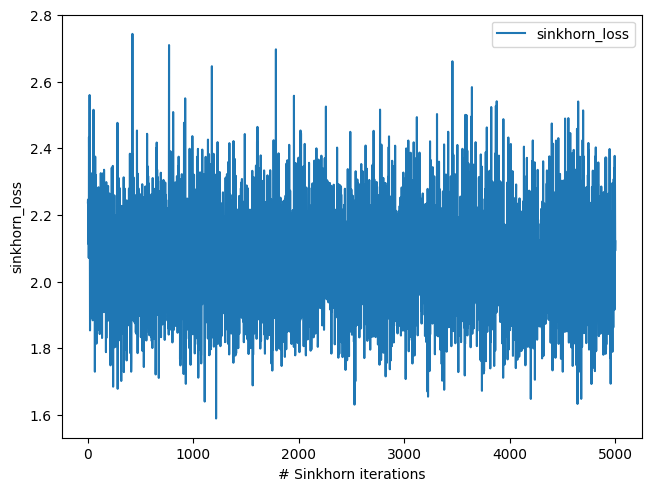

In [ ]:
sinkhorn_loss_mnar25 = torch.tensor(sinkhorn_loss_mnar25)
fig, ax = plt.subplots(constrained_layout=True)

npoints = len(sinkhorn_loss_mnar25)

ax.plot(np.linspace(0, 1, npoints) * npoints, sinkhorn_loss_mnar25.detach().numpy(), label='sinkhorn_loss')

ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.set_ylabel('sinkhorn_loss')
plt.legend()
plt.show()

CMI and MAE vs Sinkhorn Iterations

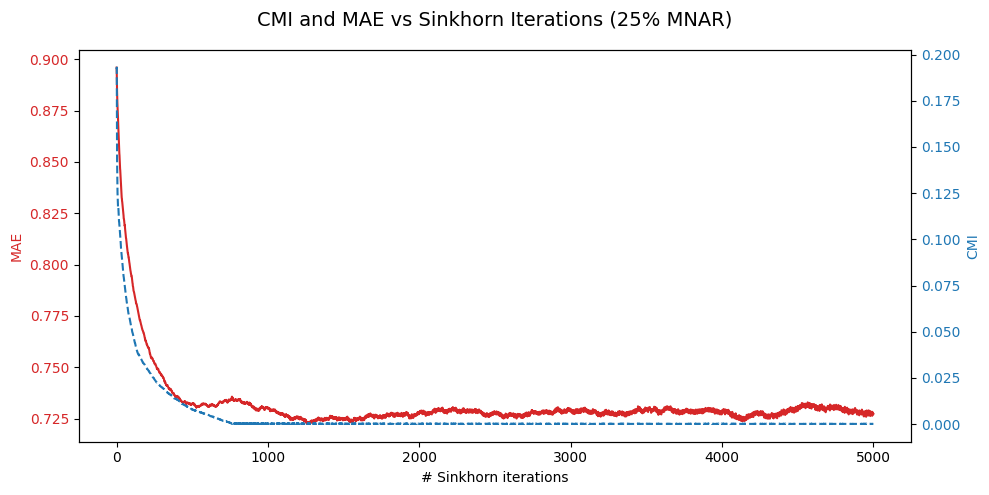

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with actual PyTorch tensors if needed)
# Convert to NumPy if these are tensors
cmi_array = cmi_loss_mnar25
mae_array = sk_maes25mnar

# Ensure both arrays are same length (or handle separately if needed)
npoints = min(len(cmi_array), len(mae_array))
x = np.linspace(0, 1, npoints) * npoints  # X-axis: Sinkhorn iterations

# Truncate both arrays to the same length for plotting
cmi_array = cmi_array[:npoints]
mae_array = mae_array[:npoints]

# Create a single plot with twin y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot MAE (left axis)
color = 'tab:red'
ax1.set_xlabel('# Sinkhorn iterations')
ax1.set_ylabel('MAE', color=color)
ax1.plot(x, mae_array, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# Plot CMI (right axis)
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(x, cmi_array, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

# Titles and layout
fig.suptitle('CMI and MAE vs Sinkhorn Iterations (25% MNAR)', fontsize=14)
fig.tight_layout()
plt.show()


MAE and CMI vs lambda_cmi

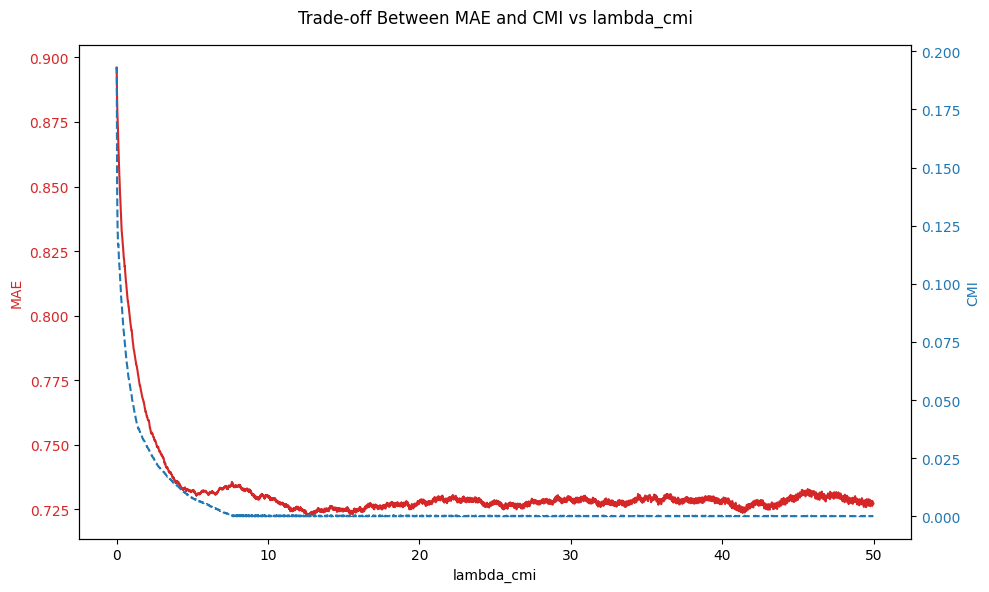

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated from your training log — you should replace these with actual histories
cmi_penalty_history = cmi_loss_mnar25 # list of length 2000 from your model
mae_history = sk_maes25mnar         # list of length 2000 from your model

iterations = np.arange(len(cmi_penalty_history))
lambda_cmi_values = lamda_cmi_mnar25

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# MAE
color = 'tab:red'
ax1.set_xlabel('lambda_cmi')
ax1.set_ylabel('MAE', color=color)
ax1.plot(lambda_cmi_values, mae_history, color=color, label='MAE')
ax1.tick_params(axis='y', labelcolor=color)

# CMI on same plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('CMI', color=color)
ax2.plot(lambda_cmi_values, cmi_penalty_history, color=color, linestyle='--', label='CMI')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Trade-off Between MAE and CMI vs lambda_cmi')
fig.tight_layout()
plt.show()


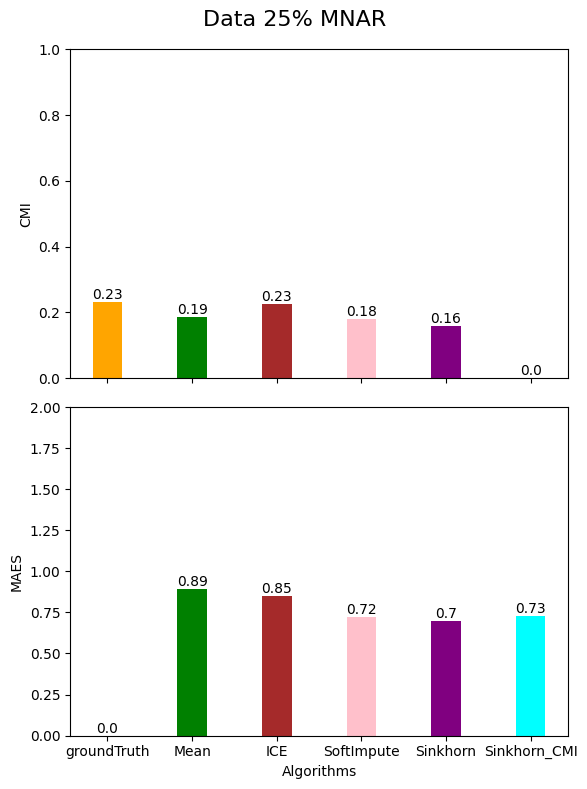

In [ ]:

# Define values and categories
values_cmi_mnar25 = [cmi_groundTruth.detach(),cmi_mean_mnar25.detach(),cmi_ice_mnar25.detach(),cmi_soft_mnar25.detach(),on_cmi_missmnar25.detach(),cmi_mnar25.detach()]
values_maes_mnar25 = [0.0,mean_mae_mnar25.detach(),ice_mae_mnar25.detach(), soft_mae_mnar25.detach(),on_sk_mae_mnar25.detach(),sk_mae_mnar25.detach()]
categories = ["groundTruth","Mean","ICE","SoftImpute","Sinkhorn","Sinkhorn_CMI"]
colors = ['orange','green','brown','pink','purple', 'cyan']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('Data 25% MNAR', fontsize=16)

# Plot CMI bars and add values on top
bars1 = ax1.bar(index, values_cmi_mnar25, color=colors, width=bar_width)
ax1.set_ylabel("CMI")
ax1.set_ylim(0, 1) 
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot MAES bars and add values on top
bars2 = ax2.bar(index, values_maes_mnar25, color=colors, width=bar_width)
ax2.set_ylabel("MAES")
ax2.set_ylim(0, 2) 
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')


ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Algorithms')
plt.tight_layout()
plt.show()


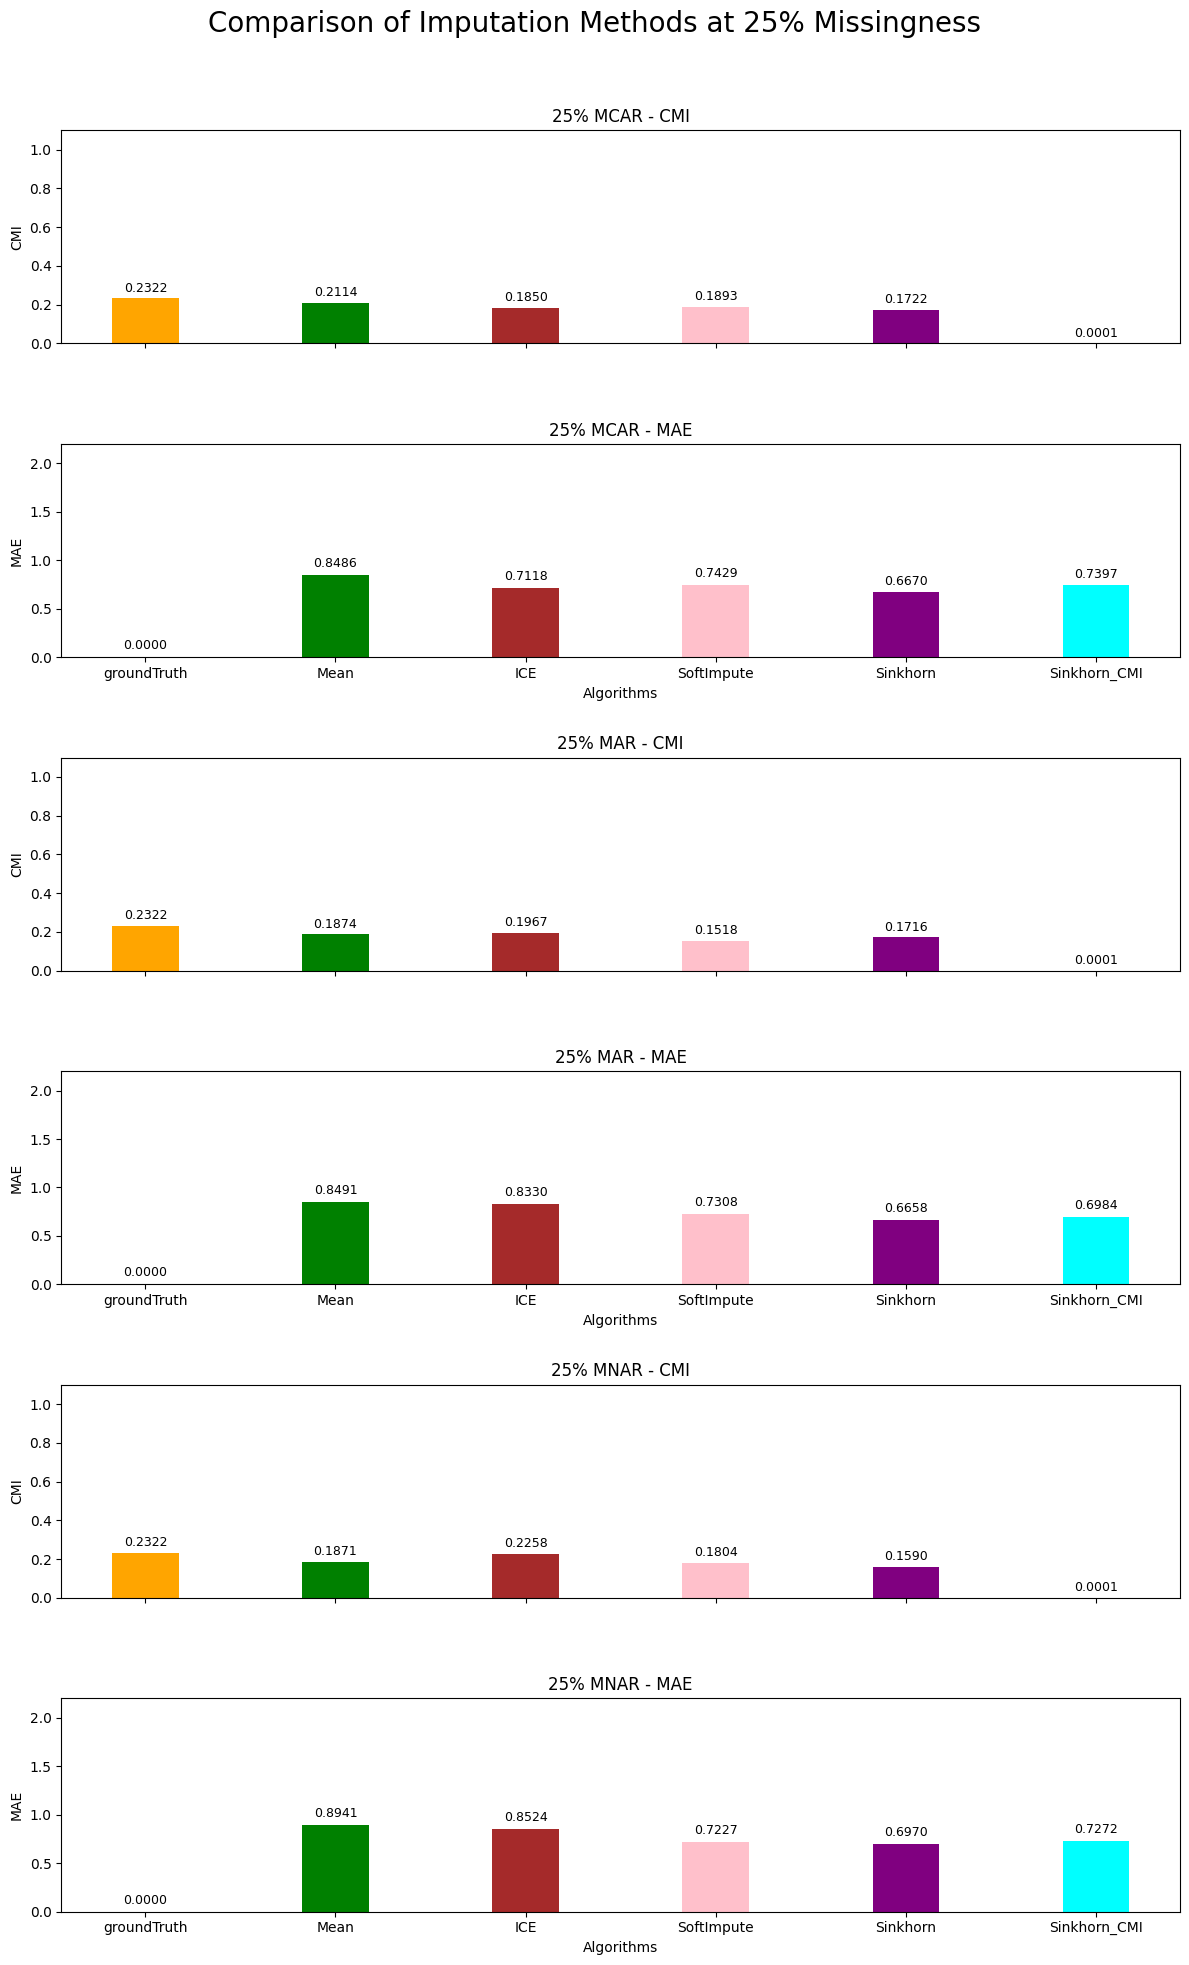

In [ ]:
fig, axes = plt.subplots(6, 1, figsize=(12, 20), sharex=False)
fig.suptitle('Comparison of Imputation Methods at 25% Missingness', fontsize=20)

# MCAR, MAR, MNAR order
plot_data = [
    ("25% MCAR", values_cmi_mcar25, values_maes_mcar25),
    ("25% MAR", values_cmi_mar25, values_maes_mar25),
    ("25% MNAR", values_cmi_mnar25, values_maes_mnar25),
]

for i, (title, cmi_vals, mae_vals) in enumerate(plot_data):
    ax_cmi = axes[i * 2]
    ax_mae = axes[i * 2 + 1]

    # ----------------- CMI Plot -----------------
    bars1 = ax_cmi.bar(index, cmi_vals, color=colors, width=bar_width)
    ax_cmi.set_ylabel("CMI")
    ax_cmi.set_ylim(0, 1.1)
    ax_cmi.set_title(f"{title} - CMI")
    for bar in bars1:
        yval = bar.get_height()
        ax_cmi.text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.4f}", ha='center', va='bottom', fontsize=9)

    # Remove x-axis labels and ticks for CMI
    ax_cmi.set_xticks(index)
    ax_cmi.set_xticklabels([])

    # ----------------- MAE Plot -----------------
    bars2 = ax_mae.bar(index, mae_vals, color=colors, width=bar_width)
    ax_mae.set_ylabel("MAE")
    ax_mae.set_ylim(0, 2.2)
    ax_mae.set_title(f"{title} - MAE")
    for bar in bars2:
        yval = bar.get_height()
        ax_mae.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f"{yval:.4f}", ha='center', va='bottom', fontsize=9)

    ax_mae.set_xticks(index)
    ax_mae.set_xticklabels(categories, fontsize=10, rotation=0)
    ax_mae.set_xlabel("Algorithms")

plt.tight_layout(rect=[0, 0, 1, 0.96], h_pad=2.5)
plt.show()


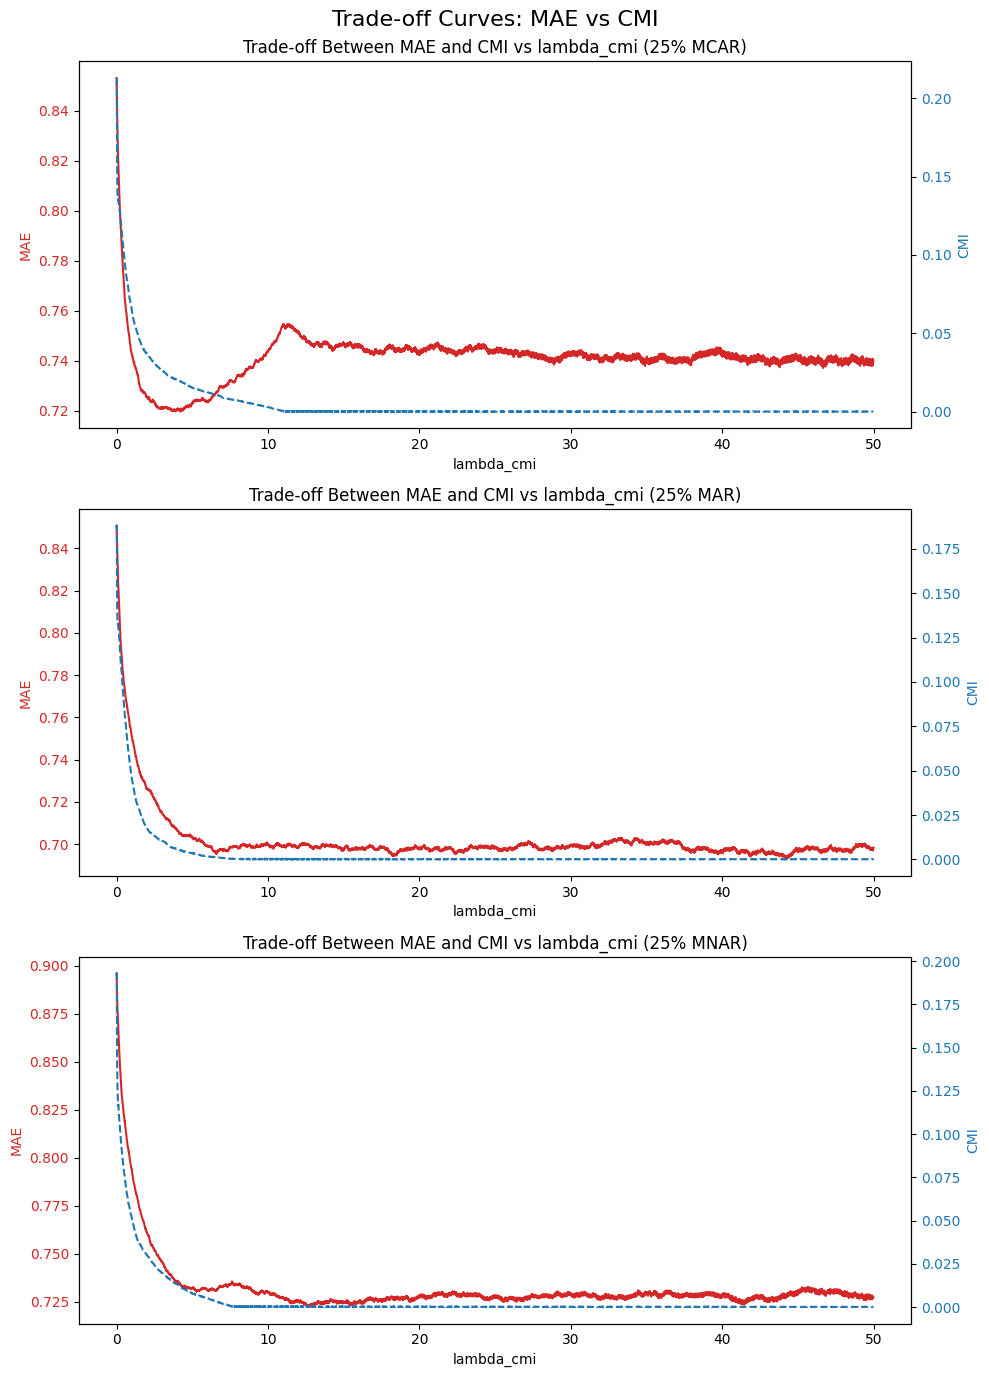

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 14))

# New order: MCAR, MAR, MNAR
datasets = [
    ("25% MCAR", lamda_cmi_mcar25, sk_maes25mcar, cmi_loss_mcar25),
    ("25% MAR", lamda_cmi_mar25, sk_maes25mar, cmi_loss_mar25),
    ("25% MNAR", lamda_cmi_mnar25, sk_maes25mnar, cmi_loss_mnar25),
]

for i, (title, lambda_vals, mae_vals, cmi_vals) in enumerate(datasets):
    ax1 = axes[i]
    ax2 = ax1.twinx()

    # MAE (left y-axis)
    ax1.set_ylabel('MAE', color='tab:red')
    ax1.plot(lambda_vals, mae_vals, color='tab:red', label='MAE')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # CMI (right y-axis)
    ax2.set_ylabel('CMI', color='tab:blue')
    ax2.plot(lambda_vals, cmi_vals, color='tab:blue', linestyle='--', label='CMI')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    ax1.set_title(f'Trade-off Between MAE and CMI vs lambda_cmi ({title})')
    ax1.set_xlabel('lambda_cmi')

plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.suptitle('Trade-off Curves: MAE vs CMI', fontsize=16)
plt.show()


Multiple times executing the missingness and running the algorithms.

### MCAR

### 5% MCAR

In [ ]:
cycle = 4
dependencies = None
missing_type = "MCAR"
missing_rate = 5
highest_lamda_cmi = 15
niter = 5000

mcar_sk_mae5, mcar_sk_cmi5, mcar_skCmi_mae5, mcar_skCmi_cmi5, mcar_mean_mae5, mcar_mean_cmi5, mcar_ice_mae5, mcar_ice_cmi5, mcar_soft_mae5,  mcar_soft_cmi5 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.5466
INFO:root:Iteration 0:	 Loss: 2.5322	 Validation MAE: 0.8453	RMSE: 0.9987
INFO:root:Iteration 50:	 Loss: 2.4467	 Validation MAE: 0.7393	RMSE: 0.9641
INFO:root:Iteration 100:	 Loss: 2.5077	 Validation MAE: 0.7063	RMSE: 0.9511


INFO:root:Iteration 150:	 Loss: 2.5631	 Validation MAE: 0.6817	RMSE: 0.9410
INFO:root:Iteration 200:	 Loss: 2.3957	 Validation MAE: 0.6671	RMSE: 0.9354
INFO:root:Iteration 250:	 Loss: 2.4516	 Validation MAE: 0.6559	RMSE: 0.9323
INFO:root:Iteration 300:	 Loss: 2.3869	 Validation MAE: 0.6466	RMSE: 0.9256
INFO:root:Iteration 350:	 Loss: 2.5832	 Validation MAE: 0.6423	RMSE: 0.9261
INFO:root:Iteration 400:	 Loss: 2.4177	 Validation MAE: 0.6385	RMSE: 0.9259
INFO:root:Iteration 450:	 Loss: 2.2783	 Validation MAE: 0.6400	RMSE: 0.9311
INFO:root:Iteration 500:	 Loss: 2.3084	 Validation MAE: 0.6339	RMSE: 0.9278
INFO:root:Iteration 550:	 Loss: 2.4799	 Validation MAE: 0.6333	RMSE: 0.9316
INFO:root:Iteration 600:	 Loss: 2.5978	 Validation MAE: 0.6263	RMSE: 0.9245
INFO:root:Iteration 650:	 Loss: 2.6550	 Validation MAE: 0.6234	RMSE: 0.9234
INFO:root:Iteration 700:	 Loss: 2.6353	 Validation MAE: 0.6254	RMSE: 0.9239
INFO:root:Iteration 750:	 Loss: 2.4294	 Validation MAE: 0.6273	RMSE: 0.9286
INFO:root:It

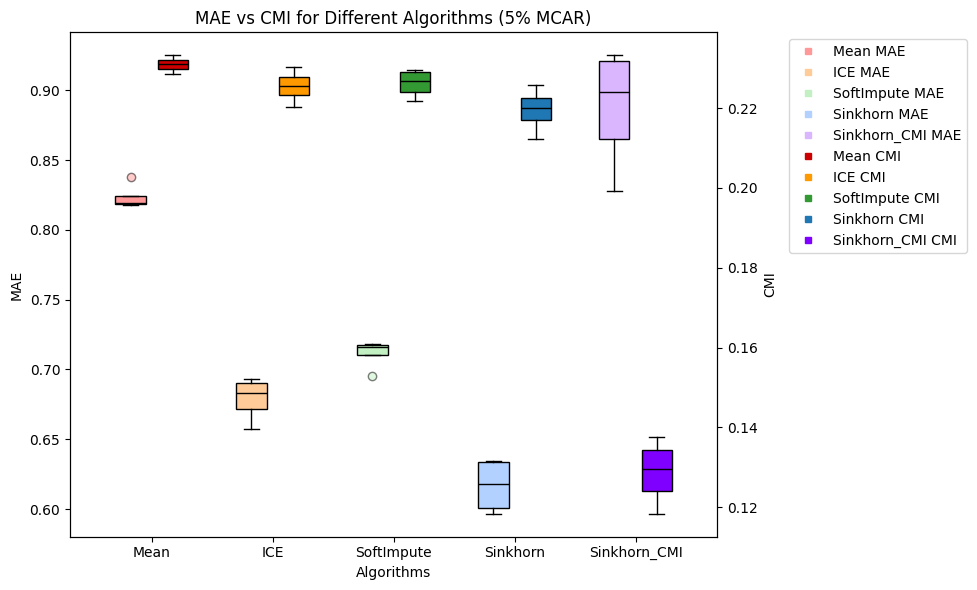

: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mcar5 = {
    'Mean': mcar_mean_cmi5,
    'ICE': mcar_ice_cmi5,
    'SoftImpute': mcar_soft_cmi5,
    'Sinkhorn': mcar_sk_cmi5,
    'Sinkhorn_CMI': mcar_skCmi_cmi5
}
mae_data_mcar5 = {
    'Mean': mcar_mean_mae5,
    'ICE': mcar_ice_mae5,
    'SoftImpute': mcar_soft_mae5,
    'Sinkhorn': mcar_sk_mae5,
    'Sinkhorn_CMI': mcar_skCmi_mae5
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mcar5[algo]
    cmi_vals = cmi_data_mcar5[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (5% MCAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 10% MCAR

In [ ]:
cycle = 4
dependencies = None
missing_type = "MCAR"
missing_rate = 10
highest_lamda_cmi = 15
niter = 5000
mcar_sk_mae10, mcar_sk_cmi10, mcar_skCmi_mae10, mcar_skCmi_cmi10, mcar_mean_mae10, mcar_mean_cmi10, mcar_ice_mae10, mcar_ice_cmi10, mcar_soft_mae10, mcar_soft_cmi10 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.5212
INFO:root:Iteration 0:	 Loss: 2.5404	 Validation MAE: 0.8505	RMSE: 1.0188


INFO:root:Iteration 50:	 Loss: 2.0488	 Validation MAE: 0.7559	RMSE: 0.9813
INFO:root:Iteration 100:	 Loss: 2.6250	 Validation MAE: 0.7182	RMSE: 0.9657
INFO:root:Iteration 150:	 Loss: 2.4816	 Validation MAE: 0.6951	RMSE: 0.9553
INFO:root:Iteration 200:	 Loss: 2.6292	 Validation MAE: 0.6780	RMSE: 0.9455
INFO:root:Iteration 250:	 Loss: 2.4970	 Validation MAE: 0.6697	RMSE: 0.9423
INFO:root:Iteration 300:	 Loss: 2.6861	 Validation MAE: 0.6619	RMSE: 0.9407
INFO:root:Iteration 350:	 Loss: 2.4354	 Validation MAE: 0.6563	RMSE: 0.9376
INFO:root:Iteration 400:	 Loss: 2.4580	 Validation MAE: 0.6507	RMSE: 0.9345
INFO:root:Iteration 450:	 Loss: 2.2531	 Validation MAE: 0.6463	RMSE: 0.9328
INFO:root:Iteration 500:	 Loss: 2.2201	 Validation MAE: 0.6424	RMSE: 0.9300
INFO:root:Iteration 550:	 Loss: 2.4370	 Validation MAE: 0.6414	RMSE: 0.9305
INFO:root:Iteration 600:	 Loss: 2.2769	 Validation MAE: 0.6414	RMSE: 0.9300
INFO:root:Iteration 650:	 Loss: 2.5141	 Validation MAE: 0.6385	RMSE: 0.9280
INFO:root:Ite

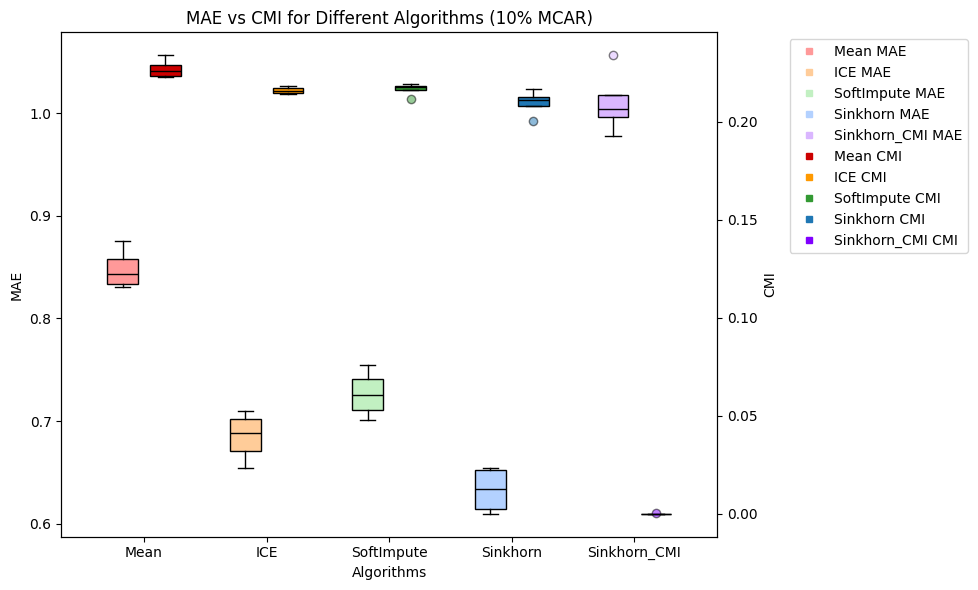

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mcar10 = {
    'Mean': mcar_mean_cmi10,
    'ICE': mcar_ice_cmi10,
    'SoftImpute': mcar_soft_cmi10,
    'Sinkhorn': mcar_sk_cmi10,
    'Sinkhorn_CMI': mcar_skCmi_cmi10
}
mae_data_mcar10 = {
    'Mean': mcar_mean_mae10,
    'ICE': mcar_ice_mae10,
    'SoftImpute': mcar_soft_mae10,
    'Sinkhorn': mcar_sk_mae10,
    'Sinkhorn_CMI': mcar_skCmi_mae10
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mcar10[algo]
    cmi_vals = cmi_data_mcar10[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (10% MCAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 15% MCAR

In [ ]:
cycle = 4
dependencies = None
missing_type = "MCAR"
missing_rate = 15
highest_lamda_cmi = 15
niter = 5000
mcar_sk_mae15, mcar_sk_cmi15, mcar_skCmi_mae15, mcar_skCmi_cmi15, mcar_mean_mae15, mcar_mean_cmi15, mcar_ice_mae15, mcar_ice_cmi15, mcar_soft_mae15, mcar_soft_cmi15 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4912
INFO:root:Iteration 0:	 Loss: 2.3263	 Validation MAE: 0.8430	RMSE: 1.0001
INFO:root:Iteration 50:	 Loss: 2.2554	 Validation MAE: 0.7537	RMSE: 0.9683
INFO:root:Iteration 100:	 Loss: 2.1644	 Validation MAE: 0.7223	RMSE: 0.9587
INFO:root:Iteration 150:	 Loss: 2.1129	 Validation MAE: 0.7047	RMSE: 0.9549
INFO:root:Iteration 200:	 Loss: 2.2498	 Validation MAE: 0.6947	RMSE: 0.9549
INFO:root:Iteration 250:	 Loss: 2.3506	 Validation MAE: 0.6846	RMSE: 0.9502
INFO:root:Iteration 300:	 Loss: 2.3762	 Validation MAE: 0.6805	RMSE: 0.9491
INFO:root:Iteration 350:	 Loss: 2.2683	 Validation MAE: 0.6780	RMSE: 0.9505
INFO:root:Iteration 400:	 Loss: 2.1121	 Validation MAE: 0.6742	RMSE: 0.9512
INFO:root:Iteration 450:	 Loss: 2.0293	 Validation MAE: 0.6711	RMSE: 0.9531
INFO:root:Iteration 500:	 Loss: 1.9154	 Validation MAE: 0.6678	RMSE: 0.9527
INFO:root:Iteration 550:	 Loss: 2.2961	 Validation MAE: 0.6696	RMSE: 0.9558
INFO:root:Iteration 600:	 Loss: 2.2112	 Validat

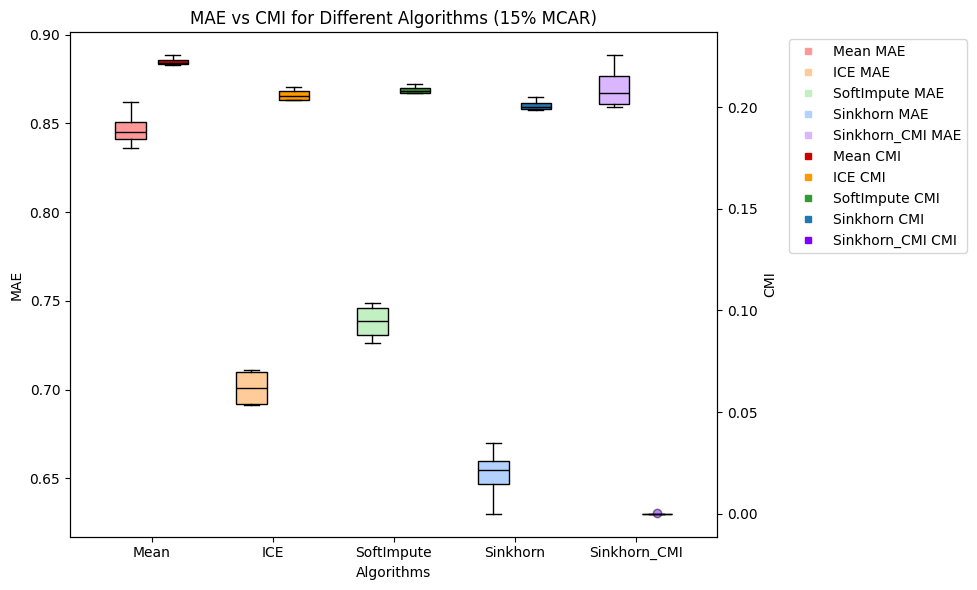

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mcar15 = {
    'Mean': mcar_mean_cmi15,
    'ICE': mcar_ice_cmi15,
    'SoftImpute': mcar_soft_cmi15,
    'Sinkhorn': mcar_sk_cmi15,
    'Sinkhorn_CMI': mcar_skCmi_cmi15
}
mae_data_mcar15 = {
    'Mean': mcar_mean_mae15,
    'ICE': mcar_ice_mae15,
    'SoftImpute': mcar_soft_mae15,
    'Sinkhorn': mcar_sk_mae15,
    'Sinkhorn_CMI': mcar_skCmi_mae15
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mcar15[algo]
    cmi_vals = cmi_data_mcar15[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (15% MCAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 20% MCAR

In [ ]:
cycle = 4
dependencies = None
missing_type = "MCAR"
missing_rate = 20
highest_lamda_cmi = 15
niter = 5000
mcar_sk_mae20, mcar_sk_cmi20, mcar_skCmi_mae20, mcar_skCmi_cmi20, mcar_mean_mae20, mcar_mean_cmi20, mcar_ice_mae20, mcar_ice_cmi20, mcar_soft_mae20, mcar_soft_cmi20 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4633
INFO:root:Iteration 0:	 Loss: 2.6567	 Validation MAE: 0.8531	RMSE: 1.0042
INFO:root:Iteration 50:	 Loss: 2.0398	 Validation MAE: 0.7599	RMSE: 0.9735
INFO:root:Iteration 100:	 Loss: 2.0552	 Validation MAE: 0.7289	RMSE: 0.9665
INFO:root:Iteration 150:	 Loss: 1.9240	 Validation MAE: 0.7126	RMSE: 0.9637
INFO:root:Iteration 200:	 Loss: 2.1285	 Validation MAE: 0.6986	RMSE: 0.9621
INFO:root:Iteration 250:	 Loss: 2.0264	 Validation MAE: 0.6875	RMSE: 0.9557
INFO:root:Iteration 300:	 Loss: 1.9867	 Validation MAE: 0.6799	RMSE: 0.9551
INFO:root:Iteration 350:	 Loss: 2.2002	 Validation MAE: 0.6740	RMSE: 0.9539
INFO:root:Iteration 400:	 Loss: 1.9239	 Validation MAE: 0.6739	RMSE: 0.9562
INFO:root:Iteration 450:	 Loss: 1.9685	 Validation MAE: 0.6706	RMSE: 0.9567
INFO:root:Iteration 500:	 Loss: 2.0511	 Validation MAE: 0.6688	RMSE: 0.9559
INFO:root:Iteration 550:	 Loss: 2.2345	 Validation MAE: 0.6661	RMSE: 0.9552
INFO:root:Iteration 600:	 Loss: 2.0395	 Validat

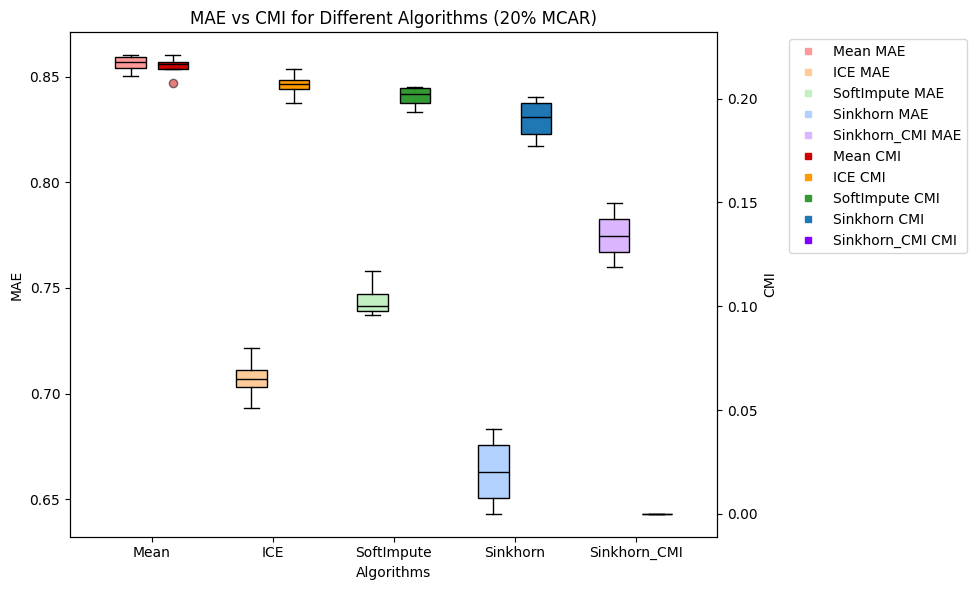

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mcar20 = {
    'Mean': mcar_mean_cmi20,
    'ICE': mcar_ice_cmi20,
    'SoftImpute': mcar_soft_cmi20,
    'Sinkhorn': mcar_sk_cmi20,
    'Sinkhorn_CMI': mcar_skCmi_cmi20
}
mae_data_mcar20 = {
    'Mean': mcar_mean_mae20,
    'ICE': mcar_ice_mae20,
    'SoftImpute': mcar_soft_mae20,
    'Sinkhorn': mcar_sk_mae20,
    'Sinkhorn_CMI': mcar_skCmi_mae20
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mcar20[algo]
    cmi_vals = cmi_data_mcar20[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (20% MCAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 25% MCAR

In [ ]:
cycle = 4
dependencies = None
missing_type = "MCAR"
missing_rate = 25
highest_lamda_cmi = 15
niter = 5000
mcar_sk_mae25, mcar_sk_cmi25, mcar_skCmi_mae25, mcar_skCmi_cmi25, mcar_mean_mae25, mcar_mean_cmi25, mcar_ice_mae25, mcar_ice_cmi25, mcar_soft_mae25, mcar_soft_cmi25 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4401
INFO:root:Iteration 0:	 Loss: 2.1551	 Validation MAE: 0.8512	RMSE: 1.0108
INFO:root:Iteration 50:	 Loss: 2.3569	 Validation MAE: 0.7668	RMSE: 0.9836
INFO:root:Iteration 100:	 Loss: 1.8705	 Validation MAE: 0.7347	RMSE: 0.9738
INFO:root:Iteration 150:	 Loss: 2.0333	 Validation MAE: 0.7132	RMSE: 0.9683
INFO:root:Iteration 200:	 Loss: 2.0180	 Validation MAE: 0.6978	RMSE: 0.9650
INFO:root:Iteration 250:	 Loss: 2.0146	 Validation MAE: 0.6875	RMSE: 0.9634
INFO:root:Iteration 300:	 Loss: 1.8338	 Validation MAE: 0.6820	RMSE: 0.9630
INFO:root:Iteration 350:	 Loss: 1.9957	 Validation MAE: 0.6746	RMSE: 0.9600
INFO:root:Iteration 400:	 Loss: 2.0228	 Validation MAE: 0.6703	RMSE: 0.9587
INFO:root:Iteration 450:	 Loss: 2.0789	 Validation MAE: 0.6678	RMSE: 0.9585
INFO:root:Iteration 500:	 Loss: 1.6837	 Validation MAE: 0.6632	RMSE: 0.9560
INFO:root:Iteration 550:	 Loss: 2.1854	 Validation MAE: 0.6614	RMSE: 0.9567
INFO:root:Iteration 600:	 Loss: 1.5866	 Validat

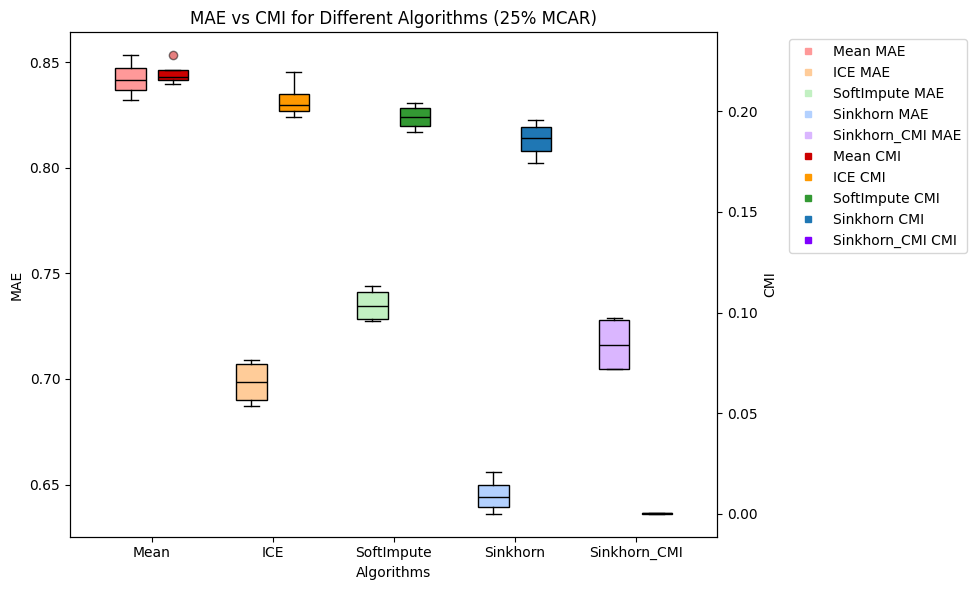

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mcar25 = {
    'Mean': mcar_mean_cmi25,
    'ICE': mcar_ice_cmi25,
    'SoftImpute': mcar_soft_cmi25,
    'Sinkhorn': mcar_sk_cmi25,
    'Sinkhorn_CMI': mcar_skCmi_cmi25
}
mae_data_mcar25 = {
    'Mean': mcar_mean_mae25,
    'ICE': mcar_ice_mae25,
    'SoftImpute': mcar_soft_mae25,
    'Sinkhorn': mcar_sk_mae25,
    'Sinkhorn_CMI': mcar_skCmi_mae25
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mcar25[algo]
    cmi_vals = cmi_data_mcar25[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (25% MCAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 30% MCAR

In [ ]:
cycle = 4
dependencies = None
missing_type = "MCAR"
missing_rate = 30
highest_lamda_cmi = 15
niter = 5000
mcar_sk_mae30, mcar_sk_cmi30, mcar_skCmi_mae30, mcar_skCmi_cmi30, mcar_mean_mae30, mcar_mean_cmi30, mcar_ice_mae30, mcar_ice_cmi30, mcar_soft_mae30, mcar_soft_cmi30 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4101
INFO:root:Iteration 0:	 Loss: 2.1431	 Validation MAE: 0.8581	RMSE: 1.0108
INFO:root:Iteration 50:	 Loss: 2.2576	 Validation MAE: 0.7654	RMSE: 0.9772
INFO:root:Iteration 100:	 Loss: 1.9420	 Validation MAE: 0.7318	RMSE: 0.9677
INFO:root:Iteration 150:	 Loss: 1.7966	 Validation MAE: 0.7117	RMSE: 0.9635
INFO:root:Iteration 200:	 Loss: 2.3071	 Validation MAE: 0.6977	RMSE: 0.9607
INFO:root:Iteration 250:	 Loss: 1.8645	 Validation MAE: 0.6890	RMSE: 0.9610
INFO:root:Iteration 300:	 Loss: 2.0195	 Validation MAE: 0.6845	RMSE: 0.9618
INFO:root:Iteration 350:	 Loss: 1.7765	 Validation MAE: 0.6803	RMSE: 0.9611
INFO:root:Iteration 400:	 Loss: 1.9048	 Validation MAE: 0.6751	RMSE: 0.9601
INFO:root:Iteration 450:	 Loss: 2.1189	 Validation MAE: 0.6713	RMSE: 0.9604
INFO:root:Iteration 500:	 Loss: 2.0664	 Validation MAE: 0.6687	RMSE: 0.9599
INFO:root:Iteration 550:	 Loss: 1.9812	 Validation MAE: 0.6662	RMSE: 0.9599
INFO:root:Iteration 600:	 Loss: 2.0450	 Validat

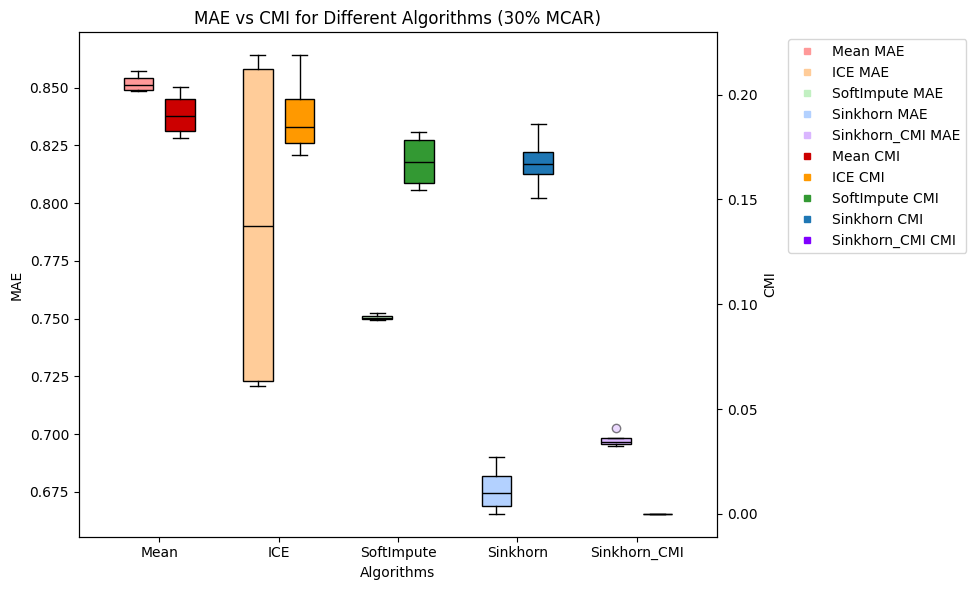

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mcar30 = {
    'Mean': mcar_mean_cmi30,
    'ICE': mcar_ice_cmi30,
    'SoftImpute': mcar_soft_cmi30,
    'Sinkhorn': mcar_sk_cmi30,
    'Sinkhorn_CMI': mcar_skCmi_cmi30
}
mae_data_mcar30 = {
    'Mean': mcar_mean_mae30,
    'ICE': mcar_ice_mae30,
    'SoftImpute': mcar_soft_mae30,
    'Sinkhorn': mcar_sk_mae30,
    'Sinkhorn_CMI': mcar_skCmi_mae30
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mcar30[algo]
    cmi_vals = cmi_data_mcar30[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (30% MCAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


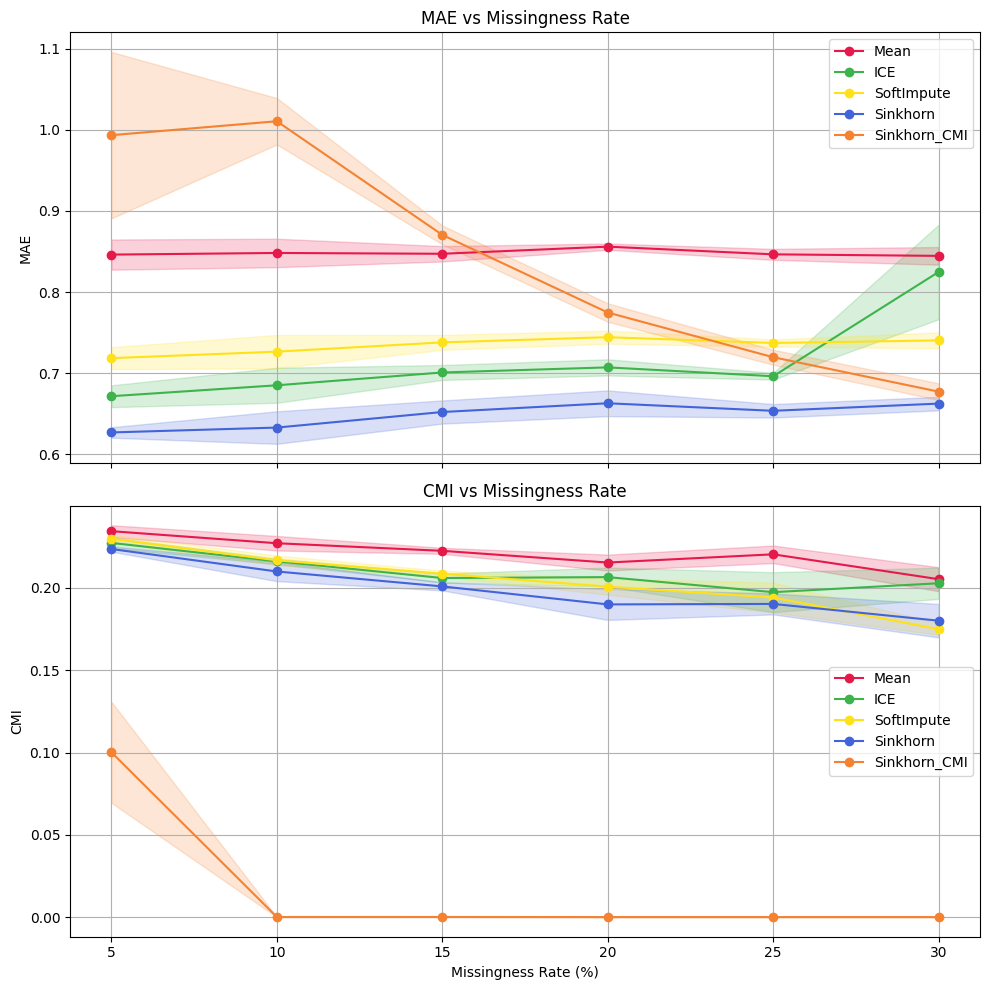

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

missing_rates = [5, 10, 15, 20, 25, 30]
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

# Replace the below placeholders with actual numpy arrays (shape: [6, 4] if 4 runs per rate)
mae_results = {
    'Mean': [mcar_mean_mae5, mcar_mean_mae10, mcar_mean_mae15, mcar_mean_mae20, mcar_mean_mae25, mcar_mean_mae30],
    'ICE': [mcar_ice_mae5, mcar_ice_mae10, mcar_ice_mae15, mcar_ice_mae20, mcar_ice_mae25, mcar_ice_mae30],
    'SoftImpute': [mcar_soft_mae5, mcar_soft_mae10, mcar_soft_mae15, mcar_soft_mae20, mcar_soft_mae25, mcar_soft_mae30],
    'Sinkhorn': [mcar_sk_mae5, mcar_sk_mae10, mcar_sk_mae15, mcar_sk_mae20, mcar_sk_mae25, mcar_sk_mae30],
    'Sinkhorn_CMI': [mcar_skCmi_mae5, mcar_skCmi_mae10, mcar_skCmi_mae15, mcar_skCmi_mae20, mcar_skCmi_mae25, mcar_skCmi_mae30]
}

cmi_results = {
    'Mean': [mcar_mean_cmi5, mcar_mean_cmi10, mcar_mean_cmi15, mcar_mean_cmi20, mcar_mean_cmi25, mcar_mean_cmi30],
    'ICE': [mcar_ice_cmi5, mcar_ice_cmi10, mcar_ice_cmi15, mcar_ice_cmi20, mcar_ice_cmi25, mcar_ice_cmi30],
    'SoftImpute': [mcar_soft_cmi5, mcar_soft_cmi10, mcar_soft_cmi15, mcar_soft_cmi20, mcar_soft_cmi25, mcar_soft_cmi30],
    'Sinkhorn': [mcar_sk_cmi5, mcar_sk_cmi10, mcar_sk_cmi15, mcar_sk_cmi20, mcar_sk_cmi25, mcar_sk_cmi30],
    'Sinkhorn_CMI': [mcar_skCmi_cmi5, mcar_skCmi_cmi10, mcar_skCmi_cmi15, mcar_skCmi_cmi20, mcar_skCmi_cmi25, mcar_skCmi_cmi30]
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# --- MAE plot ---
for i, algo in enumerate(algorithms):
    data = np.array(mae_results[algo])
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    ax1.plot(missing_rates, means, label=algo, color=colors[i], marker='o')
    ax1.fill_between(missing_rates, means - stds, means + stds, alpha=0.2, color=colors[i])

ax1.set_ylabel('MAE')
ax1.set_title('MAE vs Missingness Rate')
ax1.grid(True)
ax1.legend()

# --- CMI plot ---
for i, algo in enumerate(algorithms):
    data = np.array(cmi_results[algo])
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    ax2.plot(missing_rates, means, label=algo, color=colors[i], marker='o')
    ax2.fill_between(missing_rates, means - stds, means + stds, alpha=0.2, color=colors[i])

ax2.set_xlabel('Missingness Rate (%)')
ax2.set_ylabel('CMI')
ax2.set_title('CMI vs Missingness Rate')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


### MAR

### 5% MAR

In [ ]:
cycle = 4
dependencies = dependencies_mar
missing_type = "MAR"
missing_rate = 5
highest_lamda_cmi = 15
niter = 5000

mar_sk_mae5, mar_sk_cmi5, mar_skCmi_mae5, mar_skCmi_cmi5, mar_mean_mae5, mar_mean_cmi5, mar_ice_mae5, mar_ice_cmi5, mar_soft_mae5, mar_soft_cmi5 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.5471
INFO:root:Iteration 0:	 Loss: 2.5363	 Validation MAE: 0.8500	RMSE: 1.0160
INFO:root:Iteration 50:	 Loss: 2.5270	 Validation MAE: 0.7527	RMSE: 0.9762
INFO:root:Iteration 100:	 Loss: 2.5225	 Validation MAE: 0.7199	RMSE: 0.9624
INFO:root:Iteration 150:	 Loss: 2.6113	 Validation MAE: 0.6950	RMSE: 0.9496
INFO:root:Iteration 200:	 Loss: 2.5113	 Validation MAE: 0.6853	RMSE: 0.9488
INFO:root:Iteration 250:	 Loss: 2.6707	 Validation MAE: 0.6739	RMSE: 0.9457
INFO:root:Iteration 300:	 Loss: 2.3179	 Validation MAE: 0.6694	RMSE: 0.9458
INFO:root:Iteration 350:	 Loss: 2.4568	 Validation MAE: 0.6623	RMSE: 0.9459
INFO:root:Iteration 400:	 Loss: 3.1045	 Validation MAE: 0.6543	RMSE: 0.9414
INFO:root:Iteration 450:	 Loss: 2.3202	 Validation MAE: 0.6496	RMSE: 0.9351
INFO:root:Iteration 500:	 Loss: 2.3357	 Validation MAE: 0.6479	RMSE: 0.9359
INFO:root:Iteration 550:	 Loss: 2.5682	 Validation MAE: 0.6459	RMSE: 0.9372
INFO:root:Iteration 600:	 Loss: 2.4206	 Validat

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mar5 = {
    'Mean': mar_mean_cmi5,
    'ICE': mar_ice_cmi5,
    'SoftImpute': mar_soft_cmi5,
    'Sinkhorn': mar_sk_cmi5,
    'Sinkhorn_CMI': mar_skCmi_cmi5
}
mae_data_mar5 = {
    'Mean': mar_mean_mae5,
    'ICE': mar_ice_mae5,
    'SoftImpute': mar_soft_mae5,
    'Sinkhorn': mar_sk_mae5,
    'Sinkhorn_CMI': mar_skCmi_mae5
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mar5[algo]
    cmi_vals = cmi_data_mar5[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (5% MAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

### 10% MAR

In [ ]:
cycle = 4
dependencies = dependencies_mar
missing_type = "MAR"
missing_rate = 10
highest_lamda_cmi = 15
niter = 5000
mar_sk_mae10, mar_sk_cmi10, mar_skCmi_mae10, mar_skCmi_cmi10, mar_mean_mae10, mar_mean_cmi10, mar_ice_mae10, mar_ice_cmi10, mar_soft_mae10, mar_soft_cmi10 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.5221
INFO:root:Iteration 0:	 Loss: 2.5271	 Validation MAE: 0.8781	RMSE: 1.0560
INFO:root:Iteration 50:	 Loss: 2.2761	 Validation MAE: 0.7727	RMSE: 1.0074
INFO:root:Iteration 100:	 Loss: 2.4283	 Validation MAE: 0.7362	RMSE: 0.9919
INFO:root:Iteration 150:	 Loss: 2.2363	 Validation MAE: 0.7174	RMSE: 0.9874
INFO:root:Iteration 200:	 Loss: 2.5400	 Validation MAE: 0.7016	RMSE: 0.9807
INFO:root:Iteration 250:	 Loss: 2.4012	 Validation MAE: 0.6914	RMSE: 0.9786
INFO:root:Iteration 300:	 Loss: 2.2598	 Validation MAE: 0.6838	RMSE: 0.9752
INFO:root:Iteration 350:	 Loss: 2.3362	 Validation MAE: 0.6745	RMSE: 0.9715
INFO:root:Iteration 400:	 Loss: 2.1902	 Validation MAE: 0.6716	RMSE: 0.9710
INFO:root:Iteration 450:	 Loss: 2.2093	 Validation MAE: 0.6664	RMSE: 0.9683
INFO:root:Iteration 500:	 Loss: 2.0970	 Validation MAE: 0.6621	RMSE: 0.9652
INFO:root:Iteration 550:	 Loss: 2.2531	 Validation MAE: 0.6634	RMSE: 0.9681
INFO:root:Iteration 600:	 Loss: 2.1888	 Validat

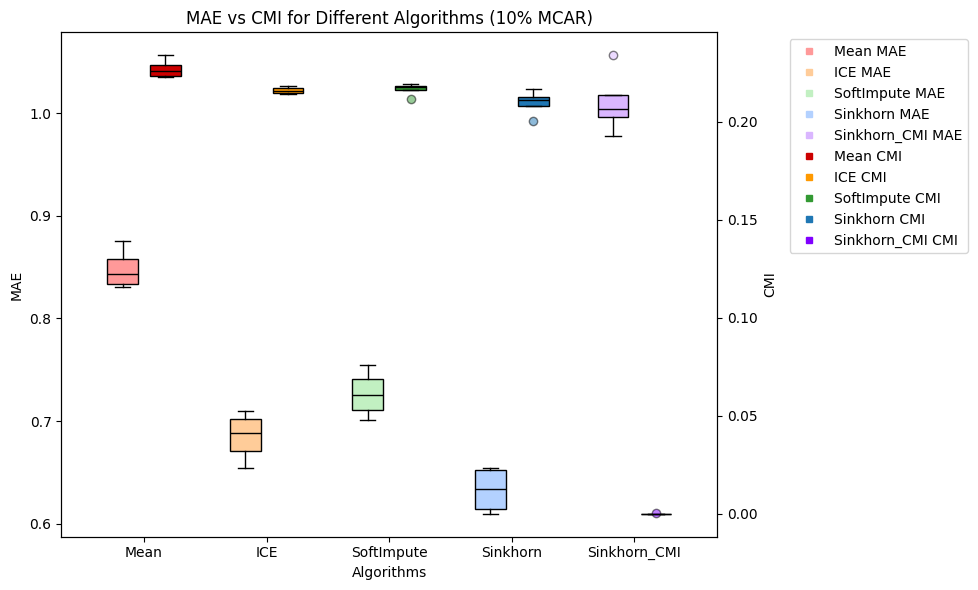

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mar10 = {
    'Mean': mar_mean_cmi10,
    'ICE': mar_ice_cmi10,
    'SoftImpute': mar_soft_cmi10,
    'Sinkhorn': mar_sk_cmi10,
    'Sinkhorn_CMI': mar_skCmi_cmi10
}
mae_data_mar10 = {
    'Mean': mar_mean_mae10,
    'ICE': mar_ice_mae10,
    'SoftImpute': mar_soft_mae10,
    'Sinkhorn': mar_sk_mae10,
    'Sinkhorn_CMI': mar_skCmi_mae10
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mar10[algo]
    cmi_vals = cmi_data_mar10[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (10% MAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 15% MAR

In [ ]:
cycle = 4
dependencies = dependencies_mar
missing_type = "MAR"
missing_rate = 15
highest_lamda_cmi = 15
niter = 5000
mar_sk_mae15, mar_sk_cmi15, mar_skCmi_mae15, mar_skCmi_cmi15, mar_mean_mae15, mar_mean_cmi15, mar_ice_mae15, mar_ice_cmi15, mar_soft_mae15, mar_soft_cmi15 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4912
INFO:root:Iteration 0:	 Loss: 2.3263	 Validation MAE: 0.8430	RMSE: 1.0001
INFO:root:Iteration 50:	 Loss: 2.2554	 Validation MAE: 0.7537	RMSE: 0.9683
INFO:root:Iteration 100:	 Loss: 2.1644	 Validation MAE: 0.7223	RMSE: 0.9587
INFO:root:Iteration 150:	 Loss: 2.1129	 Validation MAE: 0.7047	RMSE: 0.9549
INFO:root:Iteration 200:	 Loss: 2.2498	 Validation MAE: 0.6947	RMSE: 0.9549
INFO:root:Iteration 250:	 Loss: 2.3506	 Validation MAE: 0.6846	RMSE: 0.9502
INFO:root:Iteration 300:	 Loss: 2.3762	 Validation MAE: 0.6805	RMSE: 0.9491
INFO:root:Iteration 350:	 Loss: 2.2683	 Validation MAE: 0.6780	RMSE: 0.9505
INFO:root:Iteration 400:	 Loss: 2.1121	 Validation MAE: 0.6742	RMSE: 0.9512
INFO:root:Iteration 450:	 Loss: 2.0293	 Validation MAE: 0.6711	RMSE: 0.9531
INFO:root:Iteration 500:	 Loss: 1.9154	 Validation MAE: 0.6678	RMSE: 0.9527
INFO:root:Iteration 550:	 Loss: 2.2961	 Validation MAE: 0.6696	RMSE: 0.9558
INFO:root:Iteration 600:	 Loss: 2.2112	 Validat

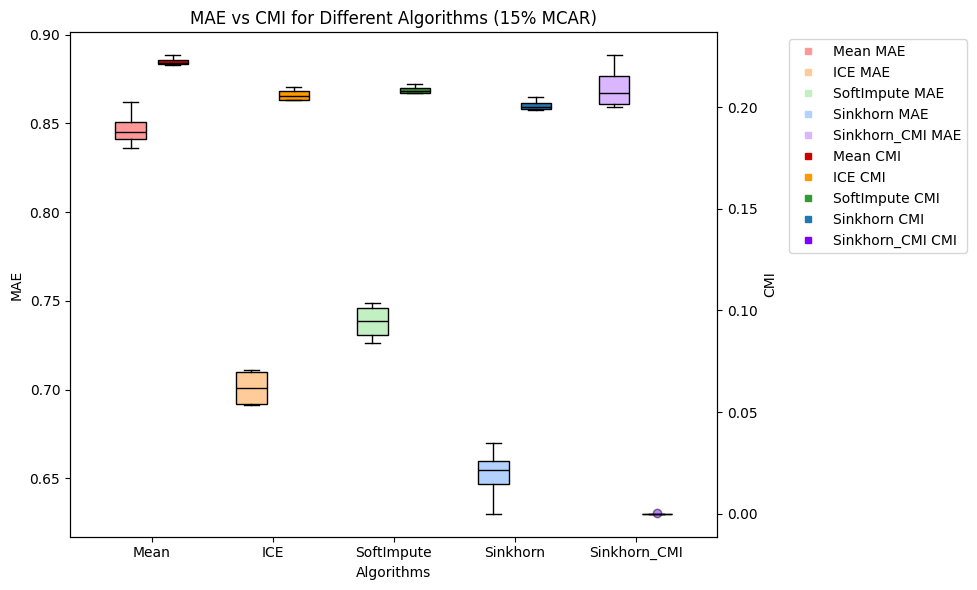

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mar15 = {
    'Mean': mar_mean_cmi15,
    'ICE': mar_ice_cmi15,
    'SoftImpute': mar_soft_cmi15,
    'Sinkhorn': mar_sk_cmi15,
    'Sinkhorn_CMI': mar_skCmi_cmi15
}
mae_data_mar15 = {
    'Mean': mar_mean_mae15,
    'ICE': mar_ice_mae15,
    'SoftImpute': mar_soft_mae15,
    'Sinkhorn': mar_sk_mae15,
    'Sinkhorn_CMI': mar_skCmi_mae15
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mar15[algo]
    cmi_vals = cmi_data_mar15[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (15% MAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 20% MAR

In [ ]:
cycle = 4
dependencies = dependencies_mar
missing_type = "MAR"
missing_rate = 20
highest_lamda_cmi = 15
niter = 5000
mar_sk_mae20, mar_sk_cmi20, mar_skCmi_mae20, mar_skCmi_cmi20, mar_mean_mae20, mar_mean_cmi20, mar_ice_mae20, mar_ice_cmi20, mar_soft_mae20, mar_soft_cmi20 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4633
INFO:root:Iteration 0:	 Loss: 2.6567	 Validation MAE: 0.8531	RMSE: 1.0042
INFO:root:Iteration 50:	 Loss: 2.0398	 Validation MAE: 0.7599	RMSE: 0.9735
INFO:root:Iteration 100:	 Loss: 2.0552	 Validation MAE: 0.7289	RMSE: 0.9665
INFO:root:Iteration 150:	 Loss: 1.9240	 Validation MAE: 0.7126	RMSE: 0.9637
INFO:root:Iteration 200:	 Loss: 2.1285	 Validation MAE: 0.6986	RMSE: 0.9621
INFO:root:Iteration 250:	 Loss: 2.0264	 Validation MAE: 0.6875	RMSE: 0.9557
INFO:root:Iteration 300:	 Loss: 1.9867	 Validation MAE: 0.6799	RMSE: 0.9551
INFO:root:Iteration 350:	 Loss: 2.2002	 Validation MAE: 0.6740	RMSE: 0.9539
INFO:root:Iteration 400:	 Loss: 1.9239	 Validation MAE: 0.6739	RMSE: 0.9562
INFO:root:Iteration 450:	 Loss: 1.9685	 Validation MAE: 0.6706	RMSE: 0.9567
INFO:root:Iteration 500:	 Loss: 2.0511	 Validation MAE: 0.6688	RMSE: 0.9559
INFO:root:Iteration 550:	 Loss: 2.2345	 Validation MAE: 0.6661	RMSE: 0.9552
INFO:root:Iteration 600:	 Loss: 2.0395	 Validat

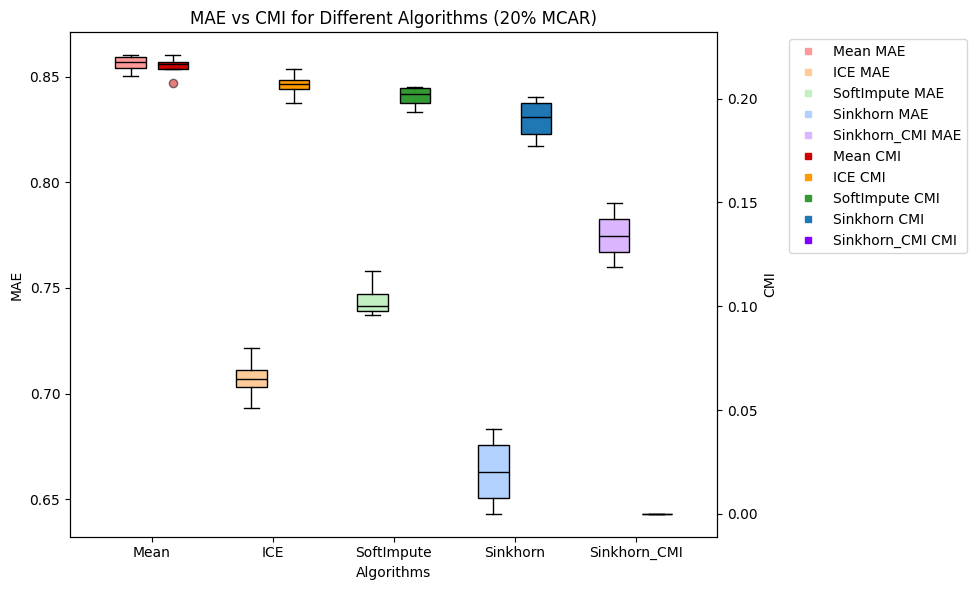

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mar20 = {
    'Mean': mar_mean_cmi20,
    'ICE': mar_ice_cmi20,
    'SoftImpute': mar_soft_cmi20,
    'Sinkhorn': mar_sk_cmi20,
    'Sinkhorn_CMI': mar_skCmi_cmi20
}
mae_data_mar20 = {
    'Mean': mar_mean_mae20,
    'ICE': mar_ice_mae20,
    'SoftImpute': mar_soft_mae20,
    'Sinkhorn': mar_sk_mae20,
    'Sinkhorn_CMI': mar_skCmi_mae20
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mar20[algo]
    cmi_vals = cmi_data_mar20[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (20% MAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 25% MAR

In [ ]:
cycle = 4
dependencies = dependencies_mar
missing_type = "MAR"
missing_rate = 25
highest_lamda_cmi = 15
niter = 5000
mar_sk_mae25, mar_sk_cmi25, mar_skCmi_mae25, mar_skCmi_cmi25, mar_mean_mae25, mar_mean_cmi25, mar_ice_mae25, mar_ice_cmi25, mar_soft_mae25, mar_soft_cmi25 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4401
INFO:root:Iteration 0:	 Loss: 2.1551	 Validation MAE: 0.8512	RMSE: 1.0108
INFO:root:Iteration 50:	 Loss: 2.3569	 Validation MAE: 0.7668	RMSE: 0.9836
INFO:root:Iteration 100:	 Loss: 1.8705	 Validation MAE: 0.7347	RMSE: 0.9738
INFO:root:Iteration 150:	 Loss: 2.0333	 Validation MAE: 0.7132	RMSE: 0.9683
INFO:root:Iteration 200:	 Loss: 2.0180	 Validation MAE: 0.6978	RMSE: 0.9650
INFO:root:Iteration 250:	 Loss: 2.0146	 Validation MAE: 0.6875	RMSE: 0.9634
INFO:root:Iteration 300:	 Loss: 1.8338	 Validation MAE: 0.6820	RMSE: 0.9630
INFO:root:Iteration 350:	 Loss: 1.9957	 Validation MAE: 0.6746	RMSE: 0.9600
INFO:root:Iteration 400:	 Loss: 2.0228	 Validation MAE: 0.6703	RMSE: 0.9587
INFO:root:Iteration 450:	 Loss: 2.0789	 Validation MAE: 0.6678	RMSE: 0.9585
INFO:root:Iteration 500:	 Loss: 1.6837	 Validation MAE: 0.6632	RMSE: 0.9560
INFO:root:Iteration 550:	 Loss: 2.1854	 Validation MAE: 0.6614	RMSE: 0.9567
INFO:root:Iteration 600:	 Loss: 1.5866	 Validat

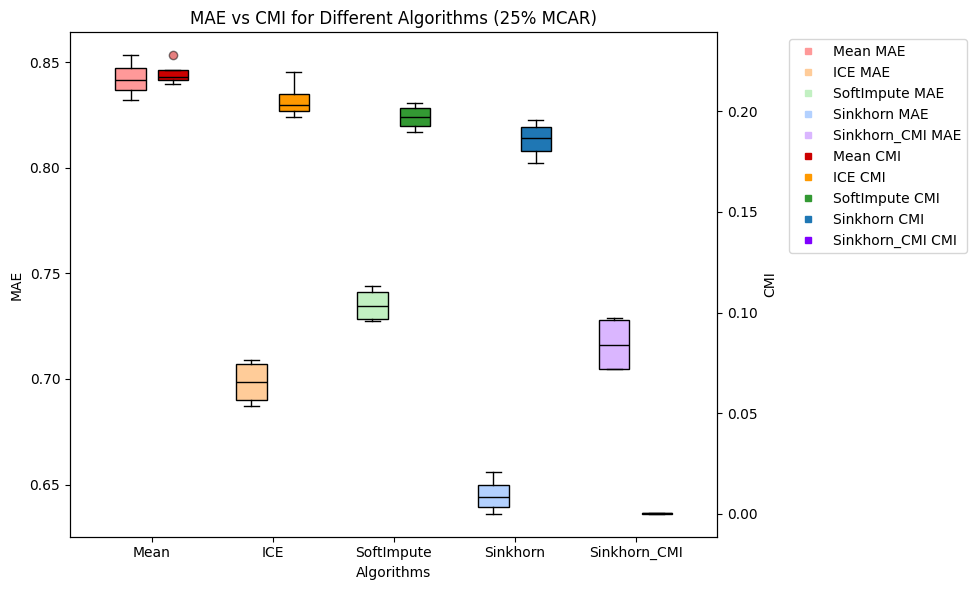

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mar25 = {
    'Mean': mar_mean_cmi25,
    'ICE': mar_ice_cmi25,
    'SoftImpute': mar_soft_cmi25,
    'Sinkhorn': mar_sk_cmi25,
    'Sinkhorn_CMI': mar_skCmi_cmi25
}
mae_data_mar25 = {
    'Mean': mar_mean_mae25,
    'ICE': mar_ice_mae25,
    'SoftImpute': mar_soft_mae25,
    'Sinkhorn': mar_sk_mae25,
    'Sinkhorn_CMI': mar_skCmi_mae25
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mar25[algo]
    cmi_vals = cmi_data_mar25[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (25% MAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 30% MAR

In [ ]:
cycle = 4
dependencies = dependencies_mar
missing_type = "MAR"
missing_rate = 30
highest_lamda_cmi = 15
niter = 5000
mar_sk_mae30, mar_sk_cmi30, mar_skCmi_mae30, mar_skCmi_cmi30, mar_mean_mae30, mar_mean_cmi30, mar_ice_mae30, mar_ice_cmi30, mar_soft_mae30, mar_soft_cmi30 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4101
INFO:root:Iteration 0:	 Loss: 2.1431	 Validation MAE: 0.8581	RMSE: 1.0108
INFO:root:Iteration 50:	 Loss: 2.2576	 Validation MAE: 0.7654	RMSE: 0.9772
INFO:root:Iteration 100:	 Loss: 1.9420	 Validation MAE: 0.7318	RMSE: 0.9677
INFO:root:Iteration 150:	 Loss: 1.7966	 Validation MAE: 0.7117	RMSE: 0.9635
INFO:root:Iteration 200:	 Loss: 2.3071	 Validation MAE: 0.6977	RMSE: 0.9607
INFO:root:Iteration 250:	 Loss: 1.8645	 Validation MAE: 0.6890	RMSE: 0.9610
INFO:root:Iteration 300:	 Loss: 2.0195	 Validation MAE: 0.6845	RMSE: 0.9618
INFO:root:Iteration 350:	 Loss: 1.7765	 Validation MAE: 0.6803	RMSE: 0.9611
INFO:root:Iteration 400:	 Loss: 1.9048	 Validation MAE: 0.6751	RMSE: 0.9601
INFO:root:Iteration 450:	 Loss: 2.1189	 Validation MAE: 0.6713	RMSE: 0.9604
INFO:root:Iteration 500:	 Loss: 2.0664	 Validation MAE: 0.6687	RMSE: 0.9599
INFO:root:Iteration 550:	 Loss: 1.9812	 Validation MAE: 0.6662	RMSE: 0.9599
INFO:root:Iteration 600:	 Loss: 2.0450	 Validat

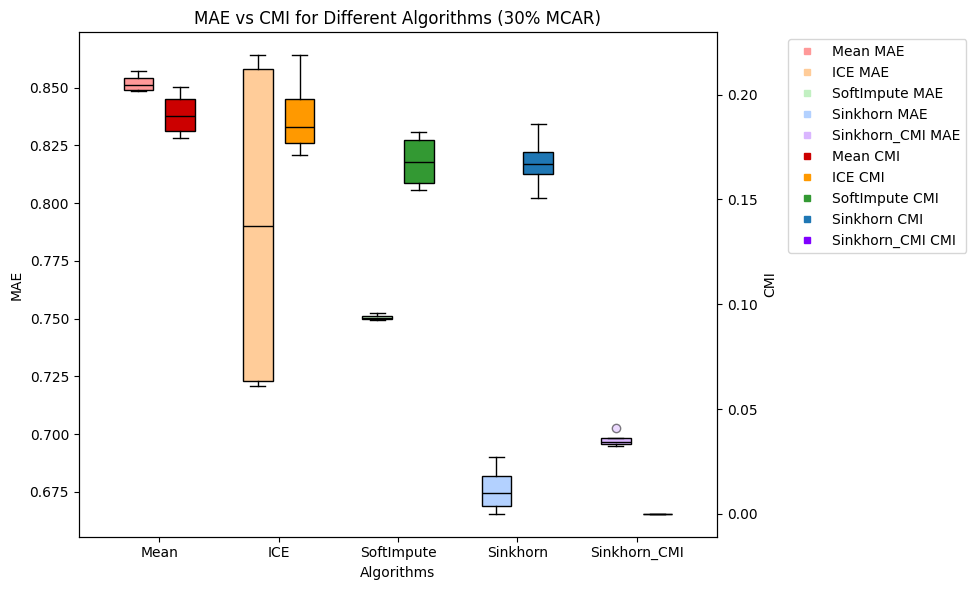

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mar30 = {
    'Mean': mar_mean_cmi30,
    'ICE': mar_ice_cmi30,
    'SoftImpute': mar_soft_cmi30,
    'Sinkhorn': mar_sk_cmi30,
    'Sinkhorn_CMI': mar_skCmi_cmi30
}
mae_data_mar30 = {
    'Mean': mar_mean_mae30,
    'ICE': mar_ice_mae30,
    'SoftImpute': mar_soft_mae30,
    'Sinkhorn': mar_sk_mae30,
    'Sinkhorn_CMI': mar_skCmi_mae30
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mar30[algo]
    cmi_vals = cmi_data_mar30[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (30% MAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


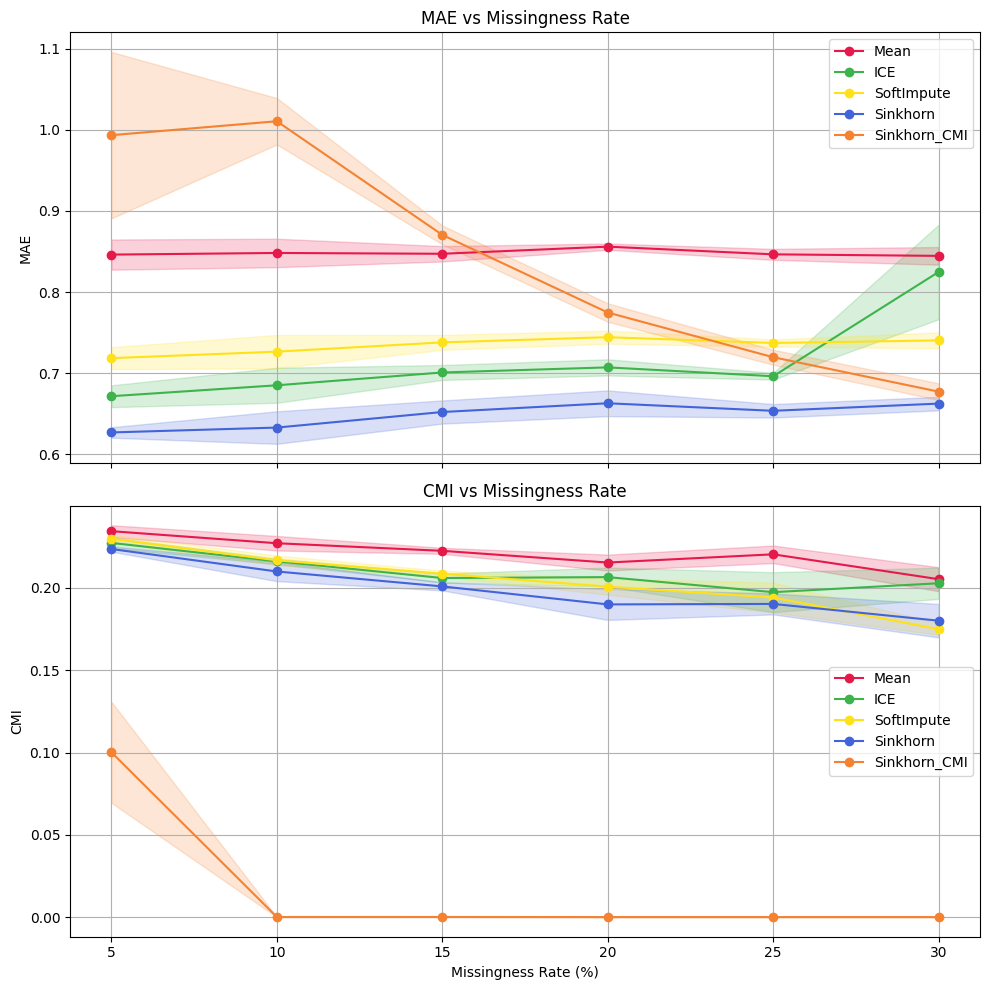

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

missing_rates = [5, 10, 15, 20, 25, 30]
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

# Replace the below placeholders with actual numpy arrays (shape: [6, 4] if 4 runs per rate)
mae_results = {
    'Mean': [mar_mean_mae5, mar_mean_mae10, mar_mean_mae15, mar_mean_mae20, mar_mean_mae25, mar_mean_mae30],
    'ICE': [mar_ice_mae5, mar_ice_mae10, mar_ice_mae15, mar_ice_mae20, mar_ice_mae25, mar_ice_mae30],
    'SoftImpute': [mar_soft_mae5, mar_soft_mae10, mar_soft_mae15, mar_soft_mae20, mar_soft_mae25, mar_soft_mae30],
    'Sinkhorn': [mar_sk_mae5, mar_sk_mae10, mar_sk_mae15, mar_sk_mae20, mar_sk_mae25, mar_sk_mae30],
    'Sinkhorn_CMI': [mar_skCmi_mae5, mar_skCmi_mae10, mar_skCmi_mae15, mar_skCmi_mae20, mar_skCmi_mae25, mar_skCmi_mae30]
}

cmi_results = {
    'Mean': [mar_mean_cmi5, mar_mean_cmi10, mar_mean_cmi15, mar_mean_cmi20, mar_mean_cmi25, mar_mean_cmi30],
    'ICE': [mar_ice_cmi5, mar_ice_cmi10, mar_ice_cmi15, mar_ice_cmi20, mar_ice_cmi25, mar_ice_cmi30],
    'SoftImpute': [mar_soft_cmi5, mar_soft_cmi10, mar_soft_cmi15, mar_soft_cmi20, mar_soft_cmi25, mar_soft_cmi30],
    'Sinkhorn': [mar_sk_cmi5, mar_sk_cmi10, mar_sk_cmi15, mar_sk_cmi20, mar_sk_cmi25, mar_sk_cmi30],
    'Sinkhorn_CMI': [mar_skCmi_cmi5, mar_skCmi_cmi10, mar_skCmi_cmi15, mar_skCmi_cmi20, mar_skCmi_cmi25, mar_skCmi_cmi30]
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# --- MAE plot ---
for i, algo in enumerate(algorithms):
    data = np.array(mae_results[algo])
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    ax1.plot(missing_rates, means, label=algo, color=colors[i], marker='o')
    ax1.fill_between(missing_rates, means - stds, means + stds, alpha=0.2, color=colors[i])

ax1.set_ylabel('MAE')
ax1.set_title('MAE vs Missingness Rate')
ax1.grid(True)
ax1.legend()

# --- CMI plot ---
for i, algo in enumerate(algorithms):
    data = np.array(cmi_results[algo])
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    ax2.plot(missing_rates, means, label=algo, color=colors[i], marker='o')
    ax2.fill_between(missing_rates, means - stds, means + stds, alpha=0.2, color=colors[i])

ax2.set_xlabel('Missingness Rate MAR (%)')
ax2.set_ylabel('CMI')
ax2.set_title('CMI vs Missingness Rate')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


### MNAR

### 5% MNAR

In [ ]:
cycle = 4
dependencies = dependencies_mnar
missing_type = "MNAR"
missing_rate = 5
highest_lamda_cmi = 15
niter = 5000

mnar_sk_mae5, mnar_sk_cmi5, mnar_skCmi_mae5, mnar_skCmi_cmi5, mnar_mean_mae5, mnar_mean_cmi5, mnar_ice_mae5, mnar_ice_cmi5, mnar_soft_mae5,  mnar_soft_cmi5 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.5471
INFO:root:Iteration 0:	 Loss: 2.5363	 Validation MAE: 0.8500	RMSE: 1.0160
INFO:root:Iteration 50:	 Loss: 2.5270	 Validation MAE: 0.7527	RMSE: 0.9762
INFO:root:Iteration 100:	 Loss: 2.5225	 Validation MAE: 0.7199	RMSE: 0.9624
INFO:root:Iteration 150:	 Loss: 2.6113	 Validation MAE: 0.6950	RMSE: 0.9496
INFO:root:Iteration 200:	 Loss: 2.5113	 Validation MAE: 0.6853	RMSE: 0.9488
INFO:root:Iteration 250:	 Loss: 2.6707	 Validation MAE: 0.6739	RMSE: 0.9457
INFO:root:Iteration 300:	 Loss: 2.3179	 Validation MAE: 0.6694	RMSE: 0.9458
INFO:root:Iteration 350:	 Loss: 2.4568	 Validation MAE: 0.6623	RMSE: 0.9459
INFO:root:Iteration 400:	 Loss: 3.1045	 Validation MAE: 0.6543	RMSE: 0.9414
INFO:root:Iteration 450:	 Loss: 2.3202	 Validation MAE: 0.6496	RMSE: 0.9351
INFO:root:Iteration 500:	 Loss: 2.3357	 Validation MAE: 0.6479	RMSE: 0.9359
INFO:root:Iteration 550:	 Loss: 2.5682	 Validation MAE: 0.6459	RMSE: 0.9372
INFO:root:Iteration 600:	 Loss: 2.4206	 Validat

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mnar5 = {
    'Mean': mnar_mean_cmi5,
    'ICE': mnar_ice_cmi5,
    'SoftImpute': mnar_soft_cmi5,
    'Sinkhorn': mnar_sk_cmi5,
    'Sinkhorn_CMI': mnar_skCmi_cmi5
}
mae_data_mnar5 = {
    'Mean': mnar_mean_mae5,
    'ICE': mnar_ice_mae5,
    'SoftImpute': mnar_soft_mae5,
    'Sinkhorn': mnar_sk_mae5,
    'Sinkhorn_CMI': mnar_skCmi_mae5
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mnar5[algo]
    cmi_vals = cmi_data_mnar5[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (5% MNAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

### 10% MNAR

In [ ]:
cycle = 4
dependencies = dependencies_mnar
missing_type = "MNAR"
missing_rate = 10
highest_lamda_cmi = 15
niter = 5000
mnar_sk_mae10, mnar_sk_cmi10, mnar_skCmi_mae10, mnar_skCmi_cmi10, mnar_mean_mae10, mnar_mean_cmi10, mnar_ice_mae10, mnar_ice_cmi10, mnar_soft_mae10, mnar_soft_cmi10 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.5221
INFO:root:Iteration 0:	 Loss: 2.5271	 Validation MAE: 0.8781	RMSE: 1.0560
INFO:root:Iteration 50:	 Loss: 2.2761	 Validation MAE: 0.7727	RMSE: 1.0074
INFO:root:Iteration 100:	 Loss: 2.4283	 Validation MAE: 0.7362	RMSE: 0.9919
INFO:root:Iteration 150:	 Loss: 2.2363	 Validation MAE: 0.7174	RMSE: 0.9874
INFO:root:Iteration 200:	 Loss: 2.5400	 Validation MAE: 0.7016	RMSE: 0.9807
INFO:root:Iteration 250:	 Loss: 2.4012	 Validation MAE: 0.6914	RMSE: 0.9786
INFO:root:Iteration 300:	 Loss: 2.2598	 Validation MAE: 0.6838	RMSE: 0.9752
INFO:root:Iteration 350:	 Loss: 2.3362	 Validation MAE: 0.6745	RMSE: 0.9715
INFO:root:Iteration 400:	 Loss: 2.1902	 Validation MAE: 0.6716	RMSE: 0.9710
INFO:root:Iteration 450:	 Loss: 2.2093	 Validation MAE: 0.6664	RMSE: 0.9683
INFO:root:Iteration 500:	 Loss: 2.0970	 Validation MAE: 0.6621	RMSE: 0.9652
INFO:root:Iteration 550:	 Loss: 2.2531	 Validation MAE: 0.6634	RMSE: 0.9681
INFO:root:Iteration 600:	 Loss: 2.1888	 Validat

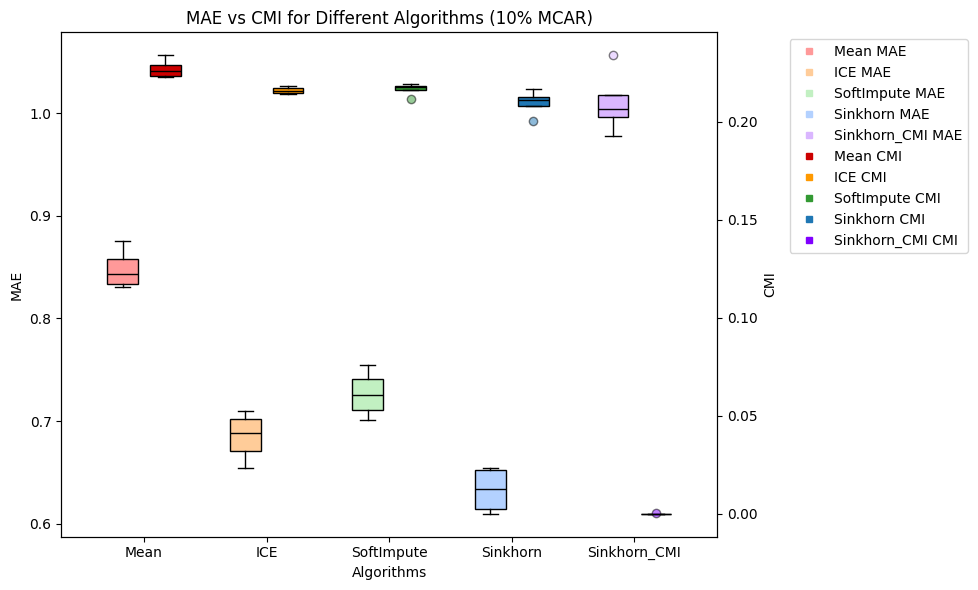

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mnar10 = {
    'Mean': mnar_mean_cmi10,
    'ICE': mnar_ice_cmi10,
    'SoftImpute': mnar_soft_cmi10,
    'Sinkhorn': mnar_sk_cmi10,
    'Sinkhorn_CMI': mnar_skCmi_cmi10
}
mae_data_mnar10 = {
    'Mean': mnar_mean_mae10,
    'ICE': mnar_ice_mae10,
    'SoftImpute': mnar_soft_mae10,
    'Sinkhorn': mnar_sk_mae10,
    'Sinkhorn_CMI': mnar_skCmi_mae10
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mnar10[algo]
    cmi_vals = cmi_data_mnar10[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (10% MNAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 15% MNAR

In [ ]:
cycle = 4
dependencies = dependencies_mnar
missing_type = "MNAR"
missing_rate = 15
highest_lamda_cmi = 15
niter = 5000
mnar_sk_mae15, mnar_sk_cmi15, mnar_skCmi_mae15, mnar_skCmi_cmi15, mnar_mean_mae15, mnar_mean_cmi15, mnar_ice_mae15, mnar_ice_cmi15, mnar_soft_mae15, mnar_soft_cmi15 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4912
INFO:root:Iteration 0:	 Loss: 2.3263	 Validation MAE: 0.8430	RMSE: 1.0001
INFO:root:Iteration 50:	 Loss: 2.2554	 Validation MAE: 0.7537	RMSE: 0.9683
INFO:root:Iteration 100:	 Loss: 2.1644	 Validation MAE: 0.7223	RMSE: 0.9587
INFO:root:Iteration 150:	 Loss: 2.1129	 Validation MAE: 0.7047	RMSE: 0.9549
INFO:root:Iteration 200:	 Loss: 2.2498	 Validation MAE: 0.6947	RMSE: 0.9549
INFO:root:Iteration 250:	 Loss: 2.3506	 Validation MAE: 0.6846	RMSE: 0.9502
INFO:root:Iteration 300:	 Loss: 2.3762	 Validation MAE: 0.6805	RMSE: 0.9491
INFO:root:Iteration 350:	 Loss: 2.2683	 Validation MAE: 0.6780	RMSE: 0.9505
INFO:root:Iteration 400:	 Loss: 2.1121	 Validation MAE: 0.6742	RMSE: 0.9512
INFO:root:Iteration 450:	 Loss: 2.0293	 Validation MAE: 0.6711	RMSE: 0.9531
INFO:root:Iteration 500:	 Loss: 1.9154	 Validation MAE: 0.6678	RMSE: 0.9527
INFO:root:Iteration 550:	 Loss: 2.2961	 Validation MAE: 0.6696	RMSE: 0.9558
INFO:root:Iteration 600:	 Loss: 2.2112	 Validat

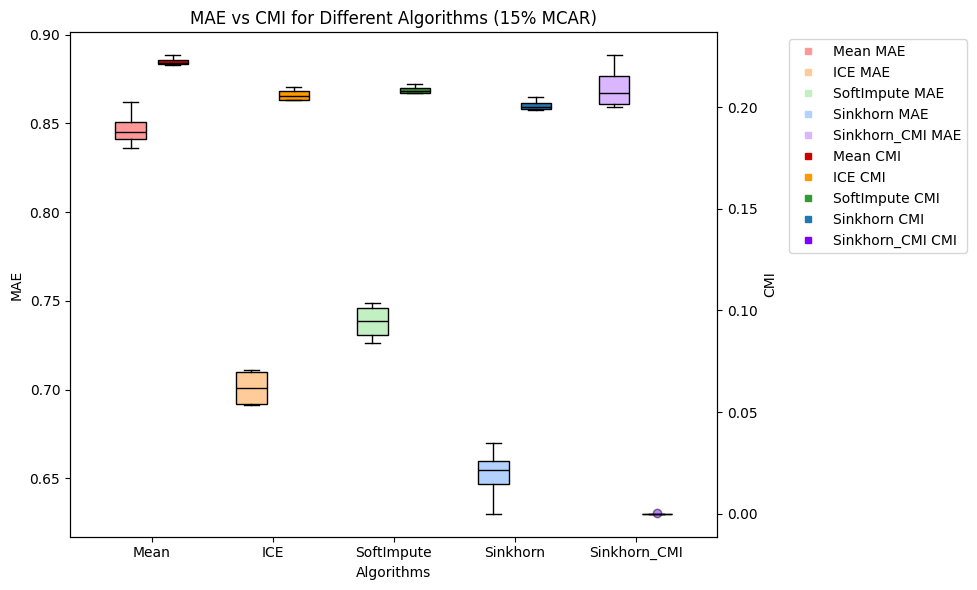

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mnar15 = {
    'Mean': mnar_mean_cmi15,
    'ICE': mnar_ice_cmi15,
    'SoftImpute': mnar_soft_cmi15,
    'Sinkhorn': mnar_sk_cmi15,
    'Sinkhorn_CMI': mnar_skCmi_cmi15
}
mae_data_mnar15 = {
    'Mean': mnar_mean_mae15,
    'ICE': mnar_ice_mae15,
    'SoftImpute': mnar_soft_mae15,
    'Sinkhorn': mnar_sk_mae15,
    'Sinkhorn_CMI': mnar_skCmi_mae15
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mnar15[algo]
    cmi_vals = cmi_data_mnar15[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (15% MNAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 20% MNAR

In [ ]:
cycle = 4
dependencies = dependencies_mnar
missing_type = "MNAR"
missing_rate = 20
highest_lamda_cmi = 15
niter = 5000
mnar_sk_mae20, mnar_sk_cmi20, mnar_skCmi_mae20, mnar_skCmi_cmi20, mnar_mean_mae20, mnar_mean_cmi20, mnar_ice_mae20, mnar_ice_cmi20, mnar_soft_mae20, mnar_soft_cmi20 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4633
INFO:root:Iteration 0:	 Loss: 2.6567	 Validation MAE: 0.8531	RMSE: 1.0042
INFO:root:Iteration 50:	 Loss: 2.0398	 Validation MAE: 0.7599	RMSE: 0.9735
INFO:root:Iteration 100:	 Loss: 2.0552	 Validation MAE: 0.7289	RMSE: 0.9665
INFO:root:Iteration 150:	 Loss: 1.9240	 Validation MAE: 0.7126	RMSE: 0.9637
INFO:root:Iteration 200:	 Loss: 2.1285	 Validation MAE: 0.6986	RMSE: 0.9621
INFO:root:Iteration 250:	 Loss: 2.0264	 Validation MAE: 0.6875	RMSE: 0.9557
INFO:root:Iteration 300:	 Loss: 1.9867	 Validation MAE: 0.6799	RMSE: 0.9551
INFO:root:Iteration 350:	 Loss: 2.2002	 Validation MAE: 0.6740	RMSE: 0.9539
INFO:root:Iteration 400:	 Loss: 1.9239	 Validation MAE: 0.6739	RMSE: 0.9562
INFO:root:Iteration 450:	 Loss: 1.9685	 Validation MAE: 0.6706	RMSE: 0.9567
INFO:root:Iteration 500:	 Loss: 2.0511	 Validation MAE: 0.6688	RMSE: 0.9559
INFO:root:Iteration 550:	 Loss: 2.2345	 Validation MAE: 0.6661	RMSE: 0.9552
INFO:root:Iteration 600:	 Loss: 2.0395	 Validat

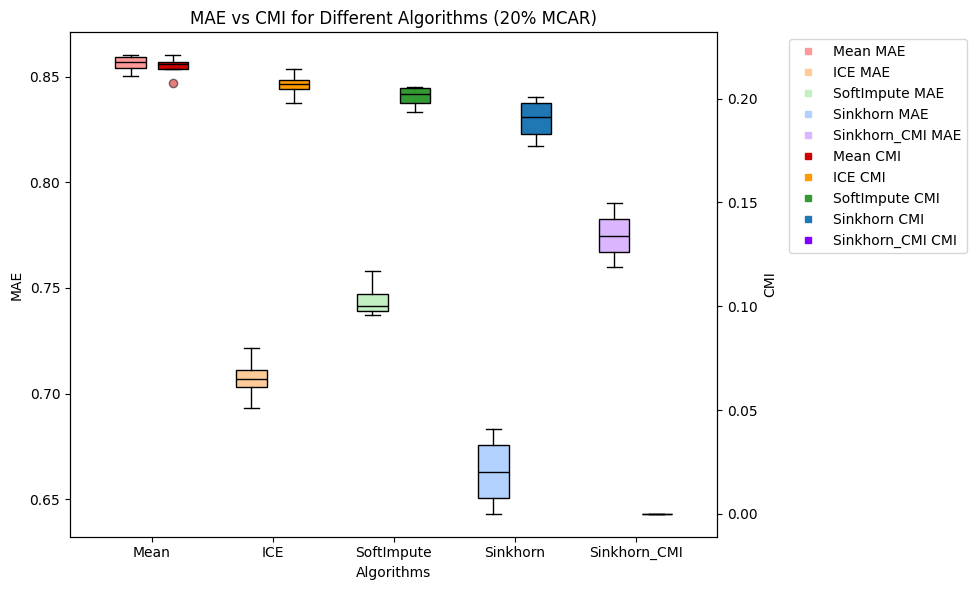

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mnar20 = {
    'Mean': mnar_mean_cmi20,
    'ICE': mnar_ice_cmi20,
    'SoftImpute': mnar_soft_cmi20,
    'Sinkhorn': mnar_sk_cmi20,
    'Sinkhorn_CMI': mnar_skCmi_cmi20
}
mae_data_mnar20 = {
    'Mean': mnar_mean_mae20,
    'ICE': mnar_ice_mae20,
    'SoftImpute': mnar_soft_mae20,
    'Sinkhorn': mnar_sk_mae20,
    'Sinkhorn_CMI': mnar_skCmi_mae20
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mnar20[algo]
    cmi_vals = cmi_data_mnar20[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (20% MNAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 25% MNAR

In [ ]:
cycle = 4
dependencies = dependencies_mnar
missing_type = "MNAR"
missing_rate = 25
highest_lamda_cmi = 15
niter = 5000
mnar_sk_mae25, mnar_sk_cmi25, mnar_skCmi_mae25, mnar_skCmi_cmi25, mnar_mean_mae25, mnar_mean_cmi25, mnar_ice_mae25, mnar_ice_cmi25, mnar_soft_mae25, mnar_soft_cmi25 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4401
INFO:root:Iteration 0:	 Loss: 2.1551	 Validation MAE: 0.8512	RMSE: 1.0108
INFO:root:Iteration 50:	 Loss: 2.3569	 Validation MAE: 0.7668	RMSE: 0.9836
INFO:root:Iteration 100:	 Loss: 1.8705	 Validation MAE: 0.7347	RMSE: 0.9738
INFO:root:Iteration 150:	 Loss: 2.0333	 Validation MAE: 0.7132	RMSE: 0.9683
INFO:root:Iteration 200:	 Loss: 2.0180	 Validation MAE: 0.6978	RMSE: 0.9650
INFO:root:Iteration 250:	 Loss: 2.0146	 Validation MAE: 0.6875	RMSE: 0.9634
INFO:root:Iteration 300:	 Loss: 1.8338	 Validation MAE: 0.6820	RMSE: 0.9630
INFO:root:Iteration 350:	 Loss: 1.9957	 Validation MAE: 0.6746	RMSE: 0.9600
INFO:root:Iteration 400:	 Loss: 2.0228	 Validation MAE: 0.6703	RMSE: 0.9587
INFO:root:Iteration 450:	 Loss: 2.0789	 Validation MAE: 0.6678	RMSE: 0.9585
INFO:root:Iteration 500:	 Loss: 1.6837	 Validation MAE: 0.6632	RMSE: 0.9560
INFO:root:Iteration 550:	 Loss: 2.1854	 Validation MAE: 0.6614	RMSE: 0.9567
INFO:root:Iteration 600:	 Loss: 1.5866	 Validat

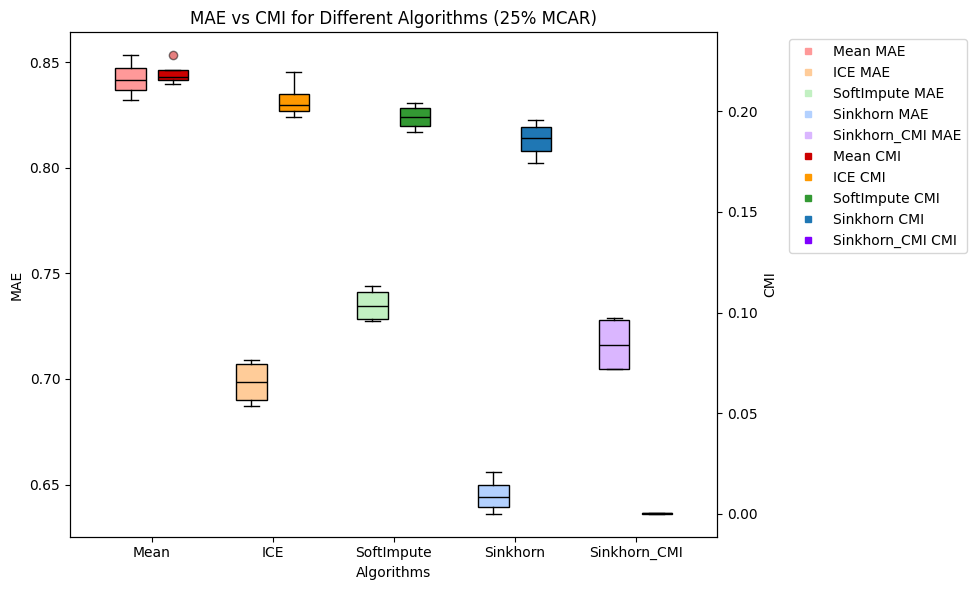

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mnar25 = {
    'Mean': mnar_mean_cmi25,
    'ICE': mnar_ice_cmi25,
    'SoftImpute': mnar_soft_cmi25,
    'Sinkhorn': mnar_sk_cmi25,
    'Sinkhorn_CMI': mnar_skCmi_cmi25
}
mae_data_mnar25 = {
    'Mean': mnar_mean_mae25,
    'ICE': mnar_ice_mae25,
    'SoftImpute': mnar_soft_mae25,
    'Sinkhorn': mnar_sk_mae25,
    'Sinkhorn_CMI': mnar_skCmi_mae25
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mnar25[algo]
    cmi_vals = cmi_data_mnar25[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (25% MNAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


### 30% MNAR

In [ ]:
cycle = 4
dependencies = dependencies_mnar
missing_type = "MNAR"
missing_rate = 30
highest_lamda_cmi = 15
niter = 5000
mnar_sk_mae30, mnar_sk_cmi30, mnar_skCmi_mae30, mnar_skCmi_cmi30, mnar_mean_mae30, mnar_mean_cmi30, mnar_ice_mae30, mnar_ice_cmi30, mnar_soft_mae30, mnar_soft_cmi30 = run(groundTruth_tensor, X, Y, cycle, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter,bucket_specs, X_cols, Y_cols, Z_cols)

INFO:root:batchsize = 128, epsilon = 0.4101
INFO:root:Iteration 0:	 Loss: 2.1431	 Validation MAE: 0.8581	RMSE: 1.0108
INFO:root:Iteration 50:	 Loss: 2.2576	 Validation MAE: 0.7654	RMSE: 0.9772
INFO:root:Iteration 100:	 Loss: 1.9420	 Validation MAE: 0.7318	RMSE: 0.9677
INFO:root:Iteration 150:	 Loss: 1.7966	 Validation MAE: 0.7117	RMSE: 0.9635
INFO:root:Iteration 200:	 Loss: 2.3071	 Validation MAE: 0.6977	RMSE: 0.9607
INFO:root:Iteration 250:	 Loss: 1.8645	 Validation MAE: 0.6890	RMSE: 0.9610
INFO:root:Iteration 300:	 Loss: 2.0195	 Validation MAE: 0.6845	RMSE: 0.9618
INFO:root:Iteration 350:	 Loss: 1.7765	 Validation MAE: 0.6803	RMSE: 0.9611
INFO:root:Iteration 400:	 Loss: 1.9048	 Validation MAE: 0.6751	RMSE: 0.9601
INFO:root:Iteration 450:	 Loss: 2.1189	 Validation MAE: 0.6713	RMSE: 0.9604
INFO:root:Iteration 500:	 Loss: 2.0664	 Validation MAE: 0.6687	RMSE: 0.9599
INFO:root:Iteration 550:	 Loss: 1.9812	 Validation MAE: 0.6662	RMSE: 0.9599
INFO:root:Iteration 600:	 Loss: 2.0450	 Validat

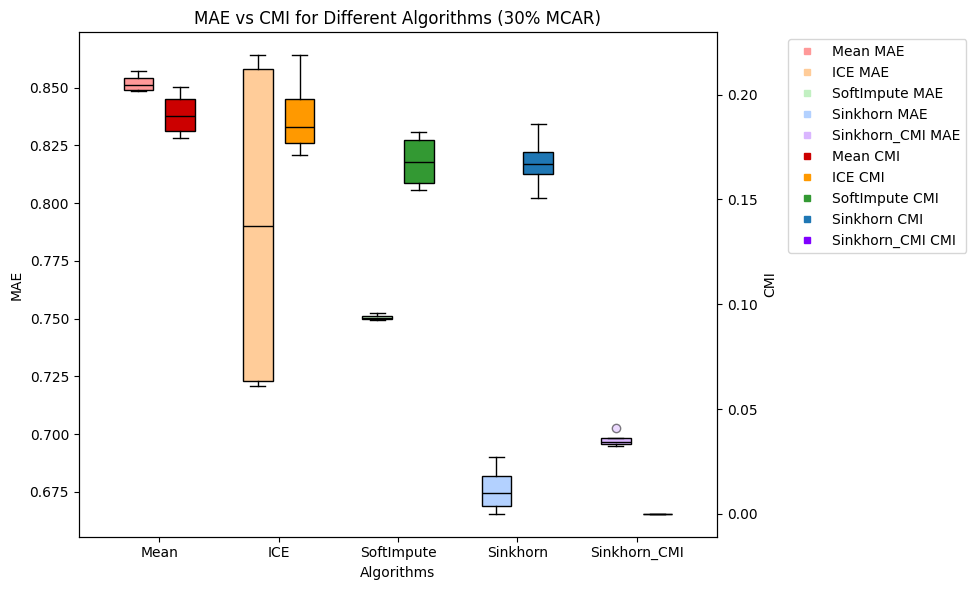

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
cmi_data_mnar30 = {
    'Mean': mnar_mean_cmi30,
    'ICE': mnar_ice_cmi30,
    'SoftImpute': mnar_soft_cmi30,
    'Sinkhorn': mnar_sk_cmi30,
    'Sinkhorn_CMI': mnar_skCmi_cmi30
}
mae_data_mnar30 = {
    'Mean': mnar_mean_mae30,
    'ICE': mnar_ice_mae30,
    'SoftImpute': mnar_soft_mae30,
    'Sinkhorn': mnar_sk_mae30,
    'Sinkhorn_CMI': mnar_skCmi_mae30
}

# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    mae_vals = mae_data_mnar30[algo]
    cmi_vals = cmi_data_mnar30[algo]

    # MAE box (lighter color)
    ax1.boxplot(mae_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(cmi_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('MAE', color='black')
ax2.set_ylabel('CMI', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('MAE vs CMI for Different Algorithms (30% MNAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} MAE')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} CMI')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


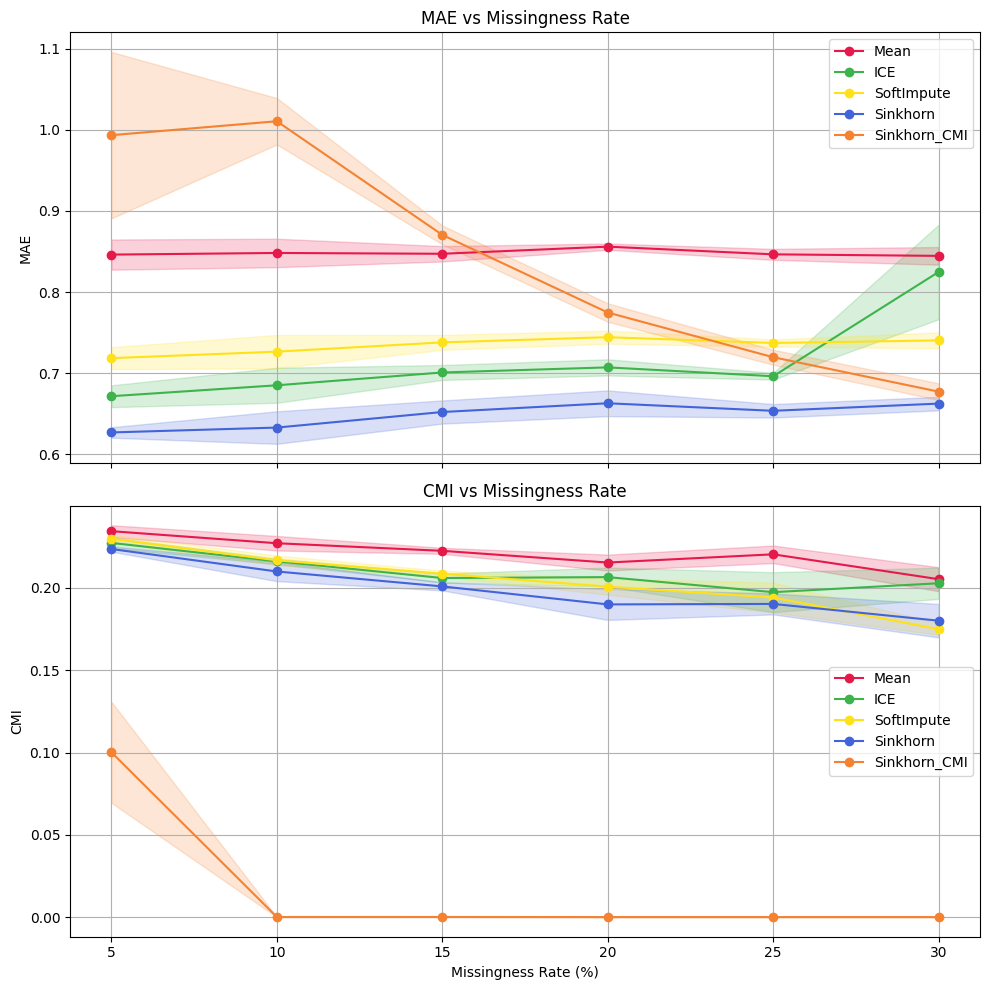

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

missing_rates = [5, 10, 15, 20, 25, 30]
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

# Replace the below placeholders with actual numpy arrays (shape: [6, 4] if 4 runs per rate)
mae_results = {
    'Mean': [mnar_mean_mae5, mnar_mean_mae10, mnar_mean_mae15, mnar_mean_mae20, mnar_mean_mae25, mnar_mean_mae30],
    'ICE': [mnar_ice_mae5, mnar_ice_mae10, mnar_ice_mae15, mnar_ice_mae20, mnar_ice_mae25, mnar_ice_mae30],
    'SoftImpute': [mnar_soft_mae5, mnar_soft_mae10, mnar_soft_mae15, mnar_soft_mae20, mnar_soft_mae25, mnar_soft_mae30],
    'Sinkhorn': [mnar_sk_mae5, mnar_sk_mae10, mnar_sk_mae15, mnar_sk_mae20, mnar_sk_mae25, mnar_sk_mae30],
    'Sinkhorn_CMI': [mnar_skCmi_mae5, mnar_skCmi_mae10, mnar_skCmi_mae15, mnar_skCmi_mae20, mnar_skCmi_mae25, mnar_skCmi_mae30]
}

cmi_results = {
    'Mean': [mnar_mean_cmi5, mnar_mean_cmi10, mnar_mean_cmi15, mnar_mean_cmi20, mnar_mean_cmi25, mnar_mean_cmi30],
    'ICE': [mnar_ice_cmi5, mnar_ice_cmi10, mnar_ice_cmi15, mnar_ice_cmi20, mnar_ice_cmi25, mnar_ice_cmi30],
    'SoftImpute': [mnar_soft_cmi5, mnar_soft_cmi10, mnar_soft_cmi15, mnar_soft_cmi20, mnar_soft_cmi25, mnar_soft_cmi30],
    'Sinkhorn': [mnar_sk_cmi5, mnar_sk_cmi10, mnar_sk_cmi15, mnar_sk_cmi20, mnar_sk_cmi25, mnar_sk_cmi30],
    'Sinkhorn_CMI': [mnar_skCmi_cmi5, mnar_skCmi_cmi10, mnar_skCmi_cmi15, mnar_skCmi_cmi20, mnar_skCmi_cmi25, mnar_skCmi_cmi30]
}

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# --- MAE plot ---
for i, algo in enumerate(algorithms):
    data = np.array(mae_results[algo])
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    ax1.plot(missing_rates, means, label=algo, color=colors[i], marker='o')
    ax1.fill_between(missing_rates, means - stds, means + stds, alpha=0.2, color=colors[i])

ax1.set_ylabel('MAE')
ax1.set_title('MAE vs Missingness Rate')
ax1.grid(True)
ax1.legend()

# --- CMI plot ---
for i, algo in enumerate(algorithms):
    data = np.array(cmi_results[algo])
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    ax2.plot(missing_rates, means, label=algo, color=colors[i], marker='o')
    ax2.fill_between(missing_rates, means - stds, means + stds, alpha=0.2, color=colors[i])

ax2.set_xlabel('Missingness Rate (%)')
ax2.set_ylabel('CMI')
ax2.set_title('CMI vs Missingness Rate')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


### Data Fairness (IAPD)

In [45]:
sensitive_attribute_index = 1

In [46]:
groundTruth_scaled_numpy = groundTruth_scaled.to_numpy()
protected_attr = groundTruth_scaled_numpy[:,sensitive_attribute_index]
protected_attr  = bucketize(protected_attr)
groundTruth_scaled_numpy[:,1] = protected_attr

MCAR

5% MCAR 

In [47]:

missing_type = "MCAR"
missing_rate = 5
dependencies = None
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mcar5 = []
sk_cmi_iapd_mcar5 = []
mean_iapd_mcar5 = []
ice_iapd_mcar5 = []
soft_iapd_mcar5 = []


for i in range(0,4):
    sk_imp_data5, sk_cmi_imp_data5, mean_imp_data5, ice_imp_data5, soft_imp_data5= imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap5, sk_cmi_iap5, mean_iap5, ice_iap5, soft_iap5 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data5, sk_cmi_imp_data5, mean_imp_data5, ice_imp_data5, soft_imp_data5 )

    
    sk_iapd_mcar5.append(sk_iap5)

    
    sk_cmi_iapd_mcar5.append(sk_cmi_iap5)

   
    mean_iapd_mcar5.append(mean_iap5)

    
    ice_iapd_mcar5.append(ice_iap5)


    soft_iapd_mcar5.append(soft_iap5)
    


INFO:root:batchsize = 128, epsilon = 0.5559
INFO:root:Iteration 0:	 Loss: 2.1038
INFO:root:Iteration 50:	 Loss: 2.2684
INFO:root:Iteration 100:	 Loss: 2.3058
INFO:root:Iteration 150:	 Loss: 2.3590
INFO:root:Iteration 200:	 Loss: 2.2283
INFO:root:Iteration 250:	 Loss: 2.2233
INFO:root:Iteration 300:	 Loss: 2.3098
INFO:root:Iteration 350:	 Loss: 2.3054
INFO:root:Iteration 400:	 Loss: 2.5278
INFO:root:Iteration 450:	 Loss: 2.5671
INFO:root:Iteration 500:	 Loss: 2.2402
INFO:root:Iteration 550:	 Loss: 2.3660
INFO:root:Iteration 600:	 Loss: 2.6392
INFO:root:Iteration 650:	 Loss: 2.5267
INFO:root:Iteration 700:	 Loss: 2.4166
INFO:root:Iteration 750:	 Loss: 2.3688
INFO:root:Iteration 800:	 Loss: 2.6159
INFO:root:Iteration 850:	 Loss: 2.4011
INFO:root:Iteration 900:	 Loss: 2.2657
INFO:root:Iteration 950:	 Loss: 2.2669
INFO:root:Iteration 1000:	 Loss: 2.5028
INFO:root:Iteration 1050:	 Loss: 2.5448
INFO:root:Iteration 1100:	 Loss: 2.3234
INFO:root:Iteration 1150:	 Loss: 2.7430
INFO:root:Iteration

10% MCAR

In [48]:

missing_type = "MCAR"
missing_rate = 10
dependencies = None
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mcar10 = []
sk_cmi_iapd_mcar10 = []
mean_iapd_mcar10 = []
ice_iapd_mcar10 = []
soft_iapd_mcar10 = []


for i in range(0,4):
    sk_imp_data10, sk_cmi_imp_data10, mean_imp_data10, ice_imp_data10, soft_imp_data10= imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap10, sk_cmi_iap10, mean_iap10, ice_iap10, soft_iap10 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data10, sk_cmi_imp_data10, mean_imp_data10, ice_imp_data10, soft_imp_data10 )

    
    sk_iapd_mcar10.append(sk_iap10)

    
    sk_cmi_iapd_mcar10.append(sk_cmi_iap10)

   
    mean_iapd_mcar10.append(mean_iap10)

    
    ice_iapd_mcar10.append(ice_iap10)


    soft_iapd_mcar10.append(soft_iap10)

INFO:root:batchsize = 128, epsilon = 0.5291
INFO:root:Iteration 0:	 Loss: 2.4459
INFO:root:Iteration 50:	 Loss: 2.3956
INFO:root:Iteration 100:	 Loss: 2.3261
INFO:root:Iteration 150:	 Loss: 2.4196
INFO:root:Iteration 200:	 Loss: 2.0615
INFO:root:Iteration 250:	 Loss: 2.1553
INFO:root:Iteration 300:	 Loss: 2.2389
INFO:root:Iteration 350:	 Loss: 2.1826
INFO:root:Iteration 400:	 Loss: 2.1832
INFO:root:Iteration 450:	 Loss: 2.3515
INFO:root:Iteration 500:	 Loss: 2.3928
INFO:root:Iteration 550:	 Loss: 2.2825
INFO:root:Iteration 600:	 Loss: 2.4515
INFO:root:Iteration 650:	 Loss: 2.5269
INFO:root:Iteration 700:	 Loss: 2.1428
INFO:root:Iteration 750:	 Loss: 2.5020
INFO:root:Iteration 800:	 Loss: 2.6868
INFO:root:Iteration 850:	 Loss: 2.0370
INFO:root:Iteration 900:	 Loss: 2.0650
INFO:root:Iteration 950:	 Loss: 2.3108
INFO:root:Iteration 1000:	 Loss: 2.3048
INFO:root:Iteration 1050:	 Loss: 2.0628
INFO:root:Iteration 1100:	 Loss: 2.5394
INFO:root:Iteration 1150:	 Loss: 2.2240
INFO:root:Iteration

15% MCAR

In [49]:

missing_type = "MCAR"
missing_rate = 15
dependencies = None
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mcar15 = []
sk_cmi_iapd_mcar15 = []
mean_iapd_mcar15 = []
ice_iapd_mcar15 = []
soft_iapd_mcar15 = []


for i in range(0,4):
    sk_imp_data15, sk_cmi_imp_data15, mean_imp_data15, ice_imp_data15, soft_imp_data15 = imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap15, sk_cmi_iap15, mean_iap15, ice_iap15, soft_iap15 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data15, sk_cmi_imp_data15, mean_imp_data15, ice_imp_data15, soft_imp_data15 )

    
    sk_iapd_mcar15.append(sk_iap15)

    
    sk_cmi_iapd_mcar15.append(sk_cmi_iap15)

   
    mean_iapd_mcar15.append(mean_iap15)

    
    ice_iapd_mcar15.append(ice_iap15)


    soft_iapd_mcar15.append(soft_iap15)

INFO:root:batchsize = 128, epsilon = 0.5001
INFO:root:Iteration 0:	 Loss: 2.4868
INFO:root:Iteration 50:	 Loss: 2.2484
INFO:root:Iteration 100:	 Loss: 2.2819
INFO:root:Iteration 150:	 Loss: 2.2441
INFO:root:Iteration 200:	 Loss: 2.1387
INFO:root:Iteration 250:	 Loss: 2.1433
INFO:root:Iteration 300:	 Loss: 2.1313
INFO:root:Iteration 350:	 Loss: 2.1378
INFO:root:Iteration 400:	 Loss: 2.0179
INFO:root:Iteration 450:	 Loss: 2.1941
INFO:root:Iteration 500:	 Loss: 2.0247
INFO:root:Iteration 550:	 Loss: 2.0720
INFO:root:Iteration 600:	 Loss: 2.0176
INFO:root:Iteration 650:	 Loss: 2.0404
INFO:root:Iteration 700:	 Loss: 2.2775
INFO:root:Iteration 750:	 Loss: 2.0179
INFO:root:Iteration 800:	 Loss: 2.0662
INFO:root:Iteration 850:	 Loss: 2.0964
INFO:root:Iteration 900:	 Loss: 2.3424
INFO:root:Iteration 950:	 Loss: 2.0707
INFO:root:Iteration 1000:	 Loss: 2.1246
INFO:root:Iteration 1050:	 Loss: 2.2407
INFO:root:Iteration 1100:	 Loss: 2.0256
INFO:root:Iteration 1150:	 Loss: 2.0308
INFO:root:Iteration

20% MCAR

In [50]:

missing_type = "MCAR"
missing_rate = 20
dependencies = None
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mcar20 = []
sk_cmi_iapd_mcar20 = []
mean_iapd_mcar20 = []
ice_iapd_mcar20 = []
soft_iapd_mcar20 = []


# X and Y is scaled to z-score

for i in range(0,4):
    sk_imp_data20, sk_cmi_imp_data20, mean_imp_data20, ice_imp_data20, soft_imp_data20 = imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap20, sk_cmi_iap20, mean_iap20, ice_iap20, soft_iap20 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data20, sk_cmi_imp_data20, mean_imp_data20, ice_imp_data20, soft_imp_data20)

    
    sk_iapd_mcar20.append(sk_iap20)

    
    sk_cmi_iapd_mcar20.append(sk_cmi_iap20)

   
    mean_iapd_mcar20.append(mean_iap20)

    
    ice_iapd_mcar20.append(ice_iap20)


    soft_iapd_mcar20.append(soft_iap20)

INFO:root:batchsize = 128, epsilon = 0.4711
INFO:root:Iteration 0:	 Loss: 2.2800
INFO:root:Iteration 50:	 Loss: 2.0899
INFO:root:Iteration 100:	 Loss: 2.1288
INFO:root:Iteration 150:	 Loss: 2.2814
INFO:root:Iteration 200:	 Loss: 1.9352
INFO:root:Iteration 250:	 Loss: 1.9405
INFO:root:Iteration 300:	 Loss: 1.7449
INFO:root:Iteration 350:	 Loss: 2.0397
INFO:root:Iteration 400:	 Loss: 1.9062
INFO:root:Iteration 450:	 Loss: 2.0575
INFO:root:Iteration 500:	 Loss: 1.9833
INFO:root:Iteration 550:	 Loss: 2.2292
INFO:root:Iteration 600:	 Loss: 1.8983
INFO:root:Iteration 650:	 Loss: 2.2001
INFO:root:Iteration 700:	 Loss: 2.1952
INFO:root:Iteration 750:	 Loss: 2.0031
INFO:root:Iteration 800:	 Loss: 2.2635
INFO:root:Iteration 850:	 Loss: 2.0521
INFO:root:Iteration 900:	 Loss: 2.0893
INFO:root:Iteration 950:	 Loss: 2.1366
INFO:root:Iteration 1000:	 Loss: 2.0973
INFO:root:Iteration 1050:	 Loss: 2.0410
INFO:root:Iteration 1100:	 Loss: 1.6874
INFO:root:Iteration 1150:	 Loss: 2.0790
INFO:root:Iteration

25% MCAR

In [51]:

missing_type = "MCAR"
missing_rate = 25
dependencies = None
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mcar25 = []
sk_cmi_iapd_mcar25 = []
mean_iapd_mcar25 = []
ice_iapd_mcar25 = []
soft_iapd_mcar25 = []


for i in range(0,4):
    sk_imp_data25, sk_cmi_imp_data25, mean_imp_data25, ice_imp_data25, soft_imp_data25= imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap25, sk_cmi_iap25, mean_iap25, ice_iap25, soft_iap25 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data25, sk_cmi_imp_data25, mean_imp_data25, ice_imp_data25, soft_imp_data25 )

    
    sk_iapd_mcar25.append(sk_iap25)

    
    sk_cmi_iapd_mcar25.append(sk_cmi_iap25)

   
    mean_iapd_mcar25.append(mean_iap25)

    
    ice_iapd_mcar25.append(ice_iap25)


    soft_iapd_mcar25.append(soft_iap25)

INFO:root:batchsize = 128, epsilon = 0.4429
INFO:root:Iteration 0:	 Loss: 2.0102
INFO:root:Iteration 50:	 Loss: 1.9651
INFO:root:Iteration 100:	 Loss: 1.8920
INFO:root:Iteration 150:	 Loss: 2.1508
INFO:root:Iteration 200:	 Loss: 2.2037
INFO:root:Iteration 250:	 Loss: 1.8968
INFO:root:Iteration 300:	 Loss: 2.1988
INFO:root:Iteration 350:	 Loss: 1.9355
INFO:root:Iteration 400:	 Loss: 1.8826
INFO:root:Iteration 450:	 Loss: 1.9572
INFO:root:Iteration 500:	 Loss: 2.0635
INFO:root:Iteration 550:	 Loss: 1.9614
INFO:root:Iteration 600:	 Loss: 1.8286
INFO:root:Iteration 650:	 Loss: 1.9625
INFO:root:Iteration 700:	 Loss: 2.0399
INFO:root:Iteration 750:	 Loss: 2.2270
INFO:root:Iteration 800:	 Loss: 1.9797
INFO:root:Iteration 850:	 Loss: 1.9034
INFO:root:Iteration 900:	 Loss: 1.6513
INFO:root:Iteration 950:	 Loss: 2.0745
INFO:root:Iteration 1000:	 Loss: 1.8456
INFO:root:Iteration 1050:	 Loss: 2.1019
INFO:root:Iteration 1100:	 Loss: 1.7929
INFO:root:Iteration 1150:	 Loss: 1.6157
INFO:root:Iteration

30% MCAR

In [52]:

missing_type = "MCAR"
missing_rate = 30
dependencies = None
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mcar30 = []
sk_cmi_iapd_mcar30 = []
mean_iapd_mcar30 = []
ice_iapd_mcar30 = []
soft_iapd_mcar30 = []


for i in range(0,4):
    sk_imp_data30, sk_cmi_imp_data30, mean_imp_data30, ice_imp_data30, soft_imp_data30 = imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap30, sk_cmi_iap30, mean_iap30, ice_iap30, soft_iap30 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data30,  sk_cmi_imp_data30, mean_imp_data30, ice_imp_data30, soft_imp_data30)

    
    sk_iapd_mcar30.append(sk_iap30)

    
    sk_cmi_iapd_mcar30.append(sk_cmi_iap30)

   
    mean_iapd_mcar30.append(mean_iap30)

    
    ice_iapd_mcar30.append(ice_iap30)


    soft_iapd_mcar30.append(soft_iap30)

INFO:root:batchsize = 128, epsilon = 0.4160
INFO:root:Iteration 0:	 Loss: 1.9734
INFO:root:Iteration 50:	 Loss: 1.8476
INFO:root:Iteration 100:	 Loss: 2.0683
INFO:root:Iteration 150:	 Loss: 2.0585
INFO:root:Iteration 200:	 Loss: 1.9899
INFO:root:Iteration 250:	 Loss: 1.9571
INFO:root:Iteration 300:	 Loss: 2.1097
INFO:root:Iteration 350:	 Loss: 2.0403
INFO:root:Iteration 400:	 Loss: 1.7240
INFO:root:Iteration 450:	 Loss: 1.9562
INFO:root:Iteration 500:	 Loss: 1.9311
INFO:root:Iteration 550:	 Loss: 1.8873
INFO:root:Iteration 600:	 Loss: 1.7870
INFO:root:Iteration 650:	 Loss: 2.0000
INFO:root:Iteration 700:	 Loss: 1.9754
INFO:root:Iteration 750:	 Loss: 1.6318
INFO:root:Iteration 800:	 Loss: 1.8004
INFO:root:Iteration 850:	 Loss: 1.7371
INFO:root:Iteration 900:	 Loss: 1.8959
INFO:root:Iteration 950:	 Loss: 1.9677
INFO:root:Iteration 1000:	 Loss: 1.8318
INFO:root:Iteration 1050:	 Loss: 1.9506
INFO:root:Iteration 1100:	 Loss: 1.9039
INFO:root:Iteration 1150:	 Loss: 1.6418
INFO:root:Iteration

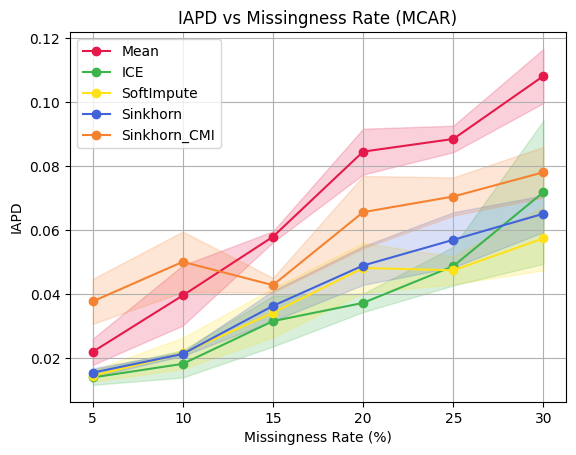

In [53]:
import matplotlib.pyplot as plt
import numpy as np

missing_rates = [5,10,15,20,25, 30]
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

# Replace the below placeholders with actual numpy arrays (shape: [6, 4] if 4 runs per rate)
iapd_results_mcar = {
    'Mean': [mean_iapd_mcar5, mean_iapd_mcar10, mean_iapd_mcar15, mean_iapd_mcar20, mean_iapd_mcar25, mean_iapd_mcar30],
    'ICE': [ice_iapd_mcar5, ice_iapd_mcar10, ice_iapd_mcar15, ice_iapd_mcar20, ice_iapd_mcar25, ice_iapd_mcar30],
    'SoftImpute': [soft_iapd_mcar5, soft_iapd_mcar10, soft_iapd_mcar15, soft_iapd_mcar20, soft_iapd_mcar25, soft_iapd_mcar30],
    'Sinkhorn': [sk_iapd_mcar5, sk_iapd_mcar10, sk_iapd_mcar15, sk_iapd_mcar20, sk_iapd_mcar25,sk_iapd_mcar30],
    'Sinkhorn_CMI': [sk_cmi_iapd_mcar5,sk_cmi_iapd_mcar10,sk_cmi_iapd_mcar15,sk_cmi_iapd_mcar20,sk_cmi_iapd_mcar25,sk_cmi_iapd_mcar30]
}



fig, ax1 = plt.subplots()
# Now ax1 is a single Axes object



for i, algo in enumerate(algorithms):
    data = np.array(iapd_results_mcar[algo])
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    ax1.plot(missing_rates, means, label=algo, color=colors[i], marker='o')
    ax1.fill_between(missing_rates, means - stds, means + stds, alpha=0.2, color=colors[i])

ax1.set_ylabel('IAPD')
ax1.set_xlabel('Missingness Rate (%)')
ax1.set_title('IAPD vs Missingness Rate (MCAR)')
ax1.grid(True)
ax1.legend()



MAR

5% MAR 

In [ ]:

missing_type = "MAR"
missing_rate = 5
dependencies = dependencies_mar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mar5 = []
sk_cmi_iapd_mar5 = []
mean_iapd_mar5 = []
ice_iapd_mar5 = []
soft_iapd_mar5 = []


for i in range(0,4):
    sk_imp_data5, sk_cmi_imp_data5, mean_imp_data5, ice_imp_data5, soft_imp_data5= imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap5, sk_cmi_iap5, mean_iap5, ice_iap5, soft_iap5 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data5, sk_cmi_imp_data5, mean_imp_data5, ice_imp_data5, soft_imp_data5 )

    
    sk_iapd_mar5.append(sk_iap5)

    
    sk_cmi_iapd_mar5.append(sk_cmi_iap5)

   
    mean_iapd_mar5.append(mean_iap5)

    
    ice_iapd_mar5.append(ice_iap5)


    soft_iapd_mar5.append(soft_iap5)
    


INFO:root:batchsize = 128, epsilon = 0.5473
INFO:root:Iteration 0:	 Loss: 2.5277
INFO:root:Iteration 50:	 Loss: 2.7045
INFO:root:Iteration 100:	 Loss: 2.5489
INFO:root:Iteration 150:	 Loss: 2.3723
INFO:root:Iteration 200:	 Loss: 2.5042
INFO:root:Iteration 250:	 Loss: 2.1542
INFO:root:Iteration 300:	 Loss: 2.3083
INFO:root:Iteration 350:	 Loss: 2.7163
INFO:root:Iteration 400:	 Loss: 2.2206
INFO:root:Iteration 450:	 Loss: 2.4567
INFO:root:Iteration 500:	 Loss: 2.3191
INFO:root:Iteration 550:	 Loss: 2.4819
INFO:root:Iteration 600:	 Loss: 2.3904
INFO:root:Iteration 650:	 Loss: 2.4445
INFO:root:Iteration 700:	 Loss: 2.3094
INFO:root:Iteration 750:	 Loss: 2.5732
INFO:root:Iteration 800:	 Loss: 2.6038
INFO:root:Iteration 850:	 Loss: 2.9781
INFO:root:Iteration 900:	 Loss: 2.1650
INFO:root:Iteration 950:	 Loss: 2.4391
INFO:root:Iteration 1000:	 Loss: 2.0917
INFO:root:Iteration 1050:	 Loss: 2.3376
INFO:root:Iteration 1100:	 Loss: 2.5819
INFO:root:Iteration 1150:	 Loss: 2.6692
INFO:root:Iteration

10% MAR

In [ ]:

missing_type = "MAR"
missing_rate = 10
dependencies = dependencies_mar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mar10 = []
sk_cmi_iapd_mar10 = []
mean_iapd_mar10 = []
ice_iapd_mar10 = []
soft_iapd_mar10 = []


for i in range(0,4):
    sk_imp_data10, sk_cmi_imp_data10, mean_imp_data10, ice_imp_data10, soft_imp_data10= imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap10, sk_cmi_iap10, mean_iap10, ice_iap10, soft_iap10 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data10, sk_cmi_imp_data10, mean_imp_data10, ice_imp_data10, soft_imp_data10 )

    
    sk_iapd_mar10.append(sk_iap10)

    
    sk_cmi_iapd_mar10.append(sk_cmi_iap10)

   
    mean_iapd_mar10.append(mean_iap10)

    
    ice_iapd_mar10.append(ice_iap10)


    soft_iapd_mar10.append(soft_iap10)

INFO:root:batchsize = 128, epsilon = 0.5205
INFO:root:Iteration 0:	 Loss: 2.4362
INFO:root:Iteration 50:	 Loss: 2.2458
INFO:root:Iteration 100:	 Loss: 2.4312
INFO:root:Iteration 150:	 Loss: 2.5315
INFO:root:Iteration 200:	 Loss: 2.3825
INFO:root:Iteration 250:	 Loss: 2.2474
INFO:root:Iteration 300:	 Loss: 2.1872
INFO:root:Iteration 350:	 Loss: 2.3870
INFO:root:Iteration 400:	 Loss: 2.2734
INFO:root:Iteration 450:	 Loss: 2.1773
INFO:root:Iteration 500:	 Loss: 2.2903
INFO:root:Iteration 550:	 Loss: 2.3959
INFO:root:Iteration 600:	 Loss: 2.3536
INFO:root:Iteration 650:	 Loss: 2.2864
INFO:root:Iteration 700:	 Loss: 2.2899
INFO:root:Iteration 750:	 Loss: 2.3736
INFO:root:Iteration 800:	 Loss: 2.4234
INFO:root:Iteration 850:	 Loss: 2.3320
INFO:root:Iteration 900:	 Loss: 2.5886
INFO:root:Iteration 950:	 Loss: 2.3297
INFO:root:Iteration 1000:	 Loss: 2.1767
INFO:root:Iteration 1050:	 Loss: 2.2996
INFO:root:Iteration 1100:	 Loss: 2.2624
INFO:root:Iteration 1150:	 Loss: 2.5078
INFO:root:Iteration

15% MAR

In [ ]:

missing_type = "MAR"
missing_rate = 15
dependencies = dependencies_mar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mar15 = []
sk_cmi_iapd_mar15 = []
mean_iapd_mar15 = []
ice_iapd_mar15 = []
soft_iapd_mar15 = []


for i in range(0,4):
    sk_imp_data15, sk_cmi_imp_data15, mean_imp_data15, ice_imp_data15, soft_imp_data15 = imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap15, sk_cmi_iap15, mean_iap15, ice_iap15, soft_iap15 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data15, sk_cmi_imp_data15, mean_imp_data15, ice_imp_data15, soft_imp_data15 )

    
    sk_iapd_mar15.append(sk_iap15)

    
    sk_cmi_iapd_mar15.append(sk_cmi_iap15)

   
    mean_iapd_mar15.append(mean_iap15)

    
    ice_iapd_mar15.append(ice_iap15)


    soft_iapd_mar15.append(soft_iap15)

INFO:root:batchsize = 128, epsilon = 0.4926
INFO:root:Iteration 0:	 Loss: 2.3689
INFO:root:Iteration 50:	 Loss: 2.3100
INFO:root:Iteration 100:	 Loss: 2.3322
INFO:root:Iteration 150:	 Loss: 2.4148
INFO:root:Iteration 200:	 Loss: 2.1983
INFO:root:Iteration 250:	 Loss: 2.4914
INFO:root:Iteration 300:	 Loss: 2.5135
INFO:root:Iteration 350:	 Loss: 1.9791
INFO:root:Iteration 400:	 Loss: 2.5136
INFO:root:Iteration 450:	 Loss: 2.2260
INFO:root:Iteration 500:	 Loss: 2.5163
INFO:root:Iteration 550:	 Loss: 2.3556
INFO:root:Iteration 600:	 Loss: 2.2695
INFO:root:Iteration 650:	 Loss: 2.2129
INFO:root:Iteration 700:	 Loss: 2.3386
INFO:root:Iteration 750:	 Loss: 2.0114
INFO:root:Iteration 800:	 Loss: 2.1785
INFO:root:Iteration 850:	 Loss: 2.3827
INFO:root:Iteration 900:	 Loss: 2.4192
INFO:root:Iteration 950:	 Loss: 2.6170
INFO:root:Iteration 1000:	 Loss: 2.3663
INFO:root:Iteration 1050:	 Loss: 2.2366
INFO:root:Iteration 1100:	 Loss: 2.1923
INFO:root:Iteration 1150:	 Loss: 2.2794
INFO:root:Iteration

20% MAR

In [ ]:

missing_type = "MAR"
missing_rate = 20
dependencies = dependencies_mar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mar20 = []
sk_cmi_iapd_mar20 = []
mean_iapd_mar20 = []
ice_iapd_mar20 = []
soft_iapd_mar20 = []


# X and Y is scaled to z-score

for i in range(0,4):
    sk_imp_data20, sk_cmi_imp_data20, mean_imp_data20, ice_imp_data20, soft_imp_data20 = imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap20, sk_cmi_iap20, mean_iap20, ice_iap20, soft_iap20 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data20, sk_cmi_imp_data20, mean_imp_data20, ice_imp_data20, soft_imp_data20)

    
    sk_iapd_mar20.append(sk_iap20)

    
    sk_cmi_iapd_mar20.append(sk_cmi_iap20)

   
    mean_iapd_mar20.append(mean_iap20)

    
    ice_iapd_mar20.append(ice_iap20)


    soft_iapd_mar20.append(soft_iap20)

INFO:root:batchsize = 128, epsilon = 0.4639
INFO:root:Iteration 0:	 Loss: 2.4777
INFO:root:Iteration 50:	 Loss: 2.0835
INFO:root:Iteration 100:	 Loss: 1.9488
INFO:root:Iteration 150:	 Loss: 2.1571
INFO:root:Iteration 200:	 Loss: 2.4531
INFO:root:Iteration 250:	 Loss: 2.1031
INFO:root:Iteration 300:	 Loss: 2.1443
INFO:root:Iteration 350:	 Loss: 2.1215
INFO:root:Iteration 400:	 Loss: 2.4072
INFO:root:Iteration 450:	 Loss: 2.2743
INFO:root:Iteration 500:	 Loss: 2.1909
INFO:root:Iteration 550:	 Loss: 2.2410
INFO:root:Iteration 600:	 Loss: 2.1313
INFO:root:Iteration 650:	 Loss: 2.1696
INFO:root:Iteration 700:	 Loss: 2.1137
INFO:root:Iteration 750:	 Loss: 2.0960
INFO:root:Iteration 800:	 Loss: 2.0704
INFO:root:Iteration 850:	 Loss: 2.1402
INFO:root:Iteration 900:	 Loss: 1.8804
INFO:root:Iteration 950:	 Loss: 2.0953
INFO:root:Iteration 1000:	 Loss: 2.0441
INFO:root:Iteration 1050:	 Loss: 2.0036
INFO:root:Iteration 1100:	 Loss: 2.0603
INFO:root:Iteration 1150:	 Loss: 2.2348
INFO:root:Iteration

25% MAR

In [ ]:

missing_type = "MAR"
missing_rate = 25
dependencies = dependencies_mar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mar25 = []
sk_cmi_iapd_mar25 = []
mean_iapd_mar25 = []
ice_iapd_mar25 = []
soft_iapd_mar25 = []


for i in range(0,4):
    sk_imp_data25, sk_cmi_imp_data25, mean_imp_data25, ice_imp_data25, soft_imp_data25= imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap25, sk_cmi_iap25, mean_iap25, ice_iap25, soft_iap25 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data25, sk_cmi_imp_data25, mean_imp_data25, ice_imp_data25, soft_imp_data25 )

    
    sk_iapd_mar25.append(sk_iap25)

    
    sk_cmi_iapd_mar25.append(sk_cmi_iap25)

   
    mean_iapd_mar25.append(mean_iap25)

    
    ice_iapd_mar25.append(ice_iap25)


    soft_iapd_mar25.append(soft_iap25)

INFO:root:batchsize = 128, epsilon = 0.4362
INFO:root:Iteration 0:	 Loss: 2.2738
INFO:root:Iteration 50:	 Loss: 1.8830


INFO:root:Iteration 100:	 Loss: 2.0471
INFO:root:Iteration 150:	 Loss: 2.1578
INFO:root:Iteration 200:	 Loss: 1.9592
INFO:root:Iteration 250:	 Loss: 1.9477
INFO:root:Iteration 300:	 Loss: 1.9814
INFO:root:Iteration 350:	 Loss: 2.0898
INFO:root:Iteration 400:	 Loss: 2.0092
INFO:root:Iteration 450:	 Loss: 2.0271
INFO:root:Iteration 500:	 Loss: 2.3097
INFO:root:Iteration 550:	 Loss: 1.9605
INFO:root:Iteration 600:	 Loss: 2.0324
INFO:root:Iteration 650:	 Loss: 2.2092
INFO:root:Iteration 700:	 Loss: 2.5118
INFO:root:Iteration 750:	 Loss: 2.0903
INFO:root:Iteration 800:	 Loss: 1.9348
INFO:root:Iteration 850:	 Loss: 2.1703
INFO:root:Iteration 900:	 Loss: 2.0774
INFO:root:Iteration 950:	 Loss: 1.9999
INFO:root:Iteration 1000:	 Loss: 2.2154
INFO:root:Iteration 1050:	 Loss: 2.0279
INFO:root:Iteration 1100:	 Loss: 1.8104
INFO:root:Iteration 1150:	 Loss: 2.0040
INFO:root:Iteration 1200:	 Loss: 2.3891
INFO:root:Iteration 1250:	 Loss: 2.0204
INFO:root:Iteration 1300:	 Loss: 1.8575
INFO:root:Iteratio

30% MAR

In [ ]:

missing_type = "MAR"
missing_rate = 30
dependencies = None
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mar30 = []
sk_cmi_iapd_mar30 = []
mean_iapd_mar30 = []
ice_iapd_mar30 = []
soft_iapd_mar30 = []


for i in range(0,4):
    sk_imp_data30, sk_cmi_imp_data30, mean_imp_data30, ice_imp_data30, soft_imp_data30 = imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap30, sk_cmi_iap30, mean_iap30, ice_iap30, soft_iap30 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data30,  sk_cmi_imp_data30, mean_imp_data30, ice_imp_data30, soft_imp_data30)

    
    sk_iapd_mar30.append(sk_iap30)

    
    sk_cmi_iapd_mar30.append(sk_cmi_iap30)

   
    mean_iapd_mar30.append(mean_iap30)

    
    ice_iapd_mar30.append(ice_iap30)


    soft_iapd_mar30.append(soft_iap30)

INFO:root:batchsize = 128, epsilon = 0.4094
INFO:root:Iteration 0:	 Loss: 2.1429
INFO:root:Iteration 50:	 Loss: 2.2240


INFO:root:Iteration 100:	 Loss: 2.1515
INFO:root:Iteration 150:	 Loss: 1.7058
INFO:root:Iteration 200:	 Loss: 2.0483
INFO:root:Iteration 250:	 Loss: 2.0153
INFO:root:Iteration 300:	 Loss: 2.1649
INFO:root:Iteration 350:	 Loss: 1.9753
INFO:root:Iteration 400:	 Loss: 1.8454
INFO:root:Iteration 450:	 Loss: 1.7789
INFO:root:Iteration 500:	 Loss: 1.9526
INFO:root:Iteration 550:	 Loss: 1.8413
INFO:root:Iteration 600:	 Loss: 1.9655
INFO:root:Iteration 650:	 Loss: 1.8051
INFO:root:Iteration 700:	 Loss: 1.8367
INFO:root:Iteration 750:	 Loss: 1.7734
INFO:root:Iteration 800:	 Loss: 1.9608
INFO:root:Iteration 850:	 Loss: 1.7518
INFO:root:Iteration 900:	 Loss: 1.6271
INFO:root:Iteration 950:	 Loss: 1.8804
INFO:root:Iteration 1000:	 Loss: 2.0513
INFO:root:Iteration 1050:	 Loss: 1.8510
INFO:root:Iteration 1100:	 Loss: 2.0688
INFO:root:Iteration 1150:	 Loss: 2.0021
INFO:root:Iteration 1200:	 Loss: 1.7050
INFO:root:Iteration 1250:	 Loss: 2.0386
INFO:root:Iteration 1300:	 Loss: 1.8340
INFO:root:Iteratio

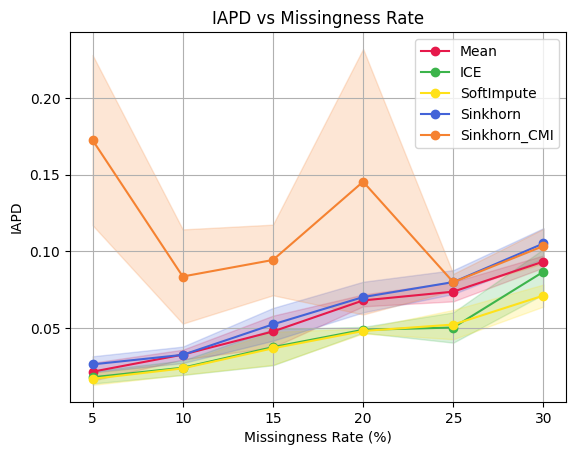

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

missing_rates = [5,10,15,20,25, 30]
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

# Replace the below placeholders with actual numpy arrays (shape: [6, 4] if 4 runs per rate)
iapd_results_mar = {
    'Mean': [mean_iapd_mar5, mean_iapd_mar10, mean_iapd_mar15, mean_iapd_mar20, mean_iapd_mar25, mean_iapd_mar30],
    'ICE': [ice_iapd_mar5, ice_iapd_mar10, ice_iapd_mar15, ice_iapd_mar20, ice_iapd_mar25, ice_iapd_mar30],
    'SoftImpute': [soft_iapd_mar5, soft_iapd_mar10, soft_iapd_mar15, soft_iapd_mar20, soft_iapd_mar25, soft_iapd_mar30],
    'Sinkhorn': [sk_iapd_mar5, sk_iapd_mar10, sk_iapd_mar15, sk_iapd_mar20, sk_iapd_mar25,sk_iapd_mar30],
    'Sinkhorn_CMI': [sk_cmi_iapd_mar5,sk_cmi_iapd_mar10,sk_cmi_iapd_mar15,sk_cmi_iapd_mar20,sk_cmi_iapd_mar25,sk_cmi_iapd_mar30]
}



fig, ax1 = plt.subplots()
# Now ax1 is a single Axes object



for i, algo in enumerate(algorithms):
    data = np.array(iapd_results_mar[algo])
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    ax1.plot(missing_rates, means, label=algo, color=colors[i], marker='o')
    ax1.fill_between(missing_rates, means - stds, means + stds, alpha=0.2, color=colors[i])

ax1.set_ylabel('IAPD')
ax1.set_xlabel('Missingness Rate (%)')
ax1.set_title('IAPD vs Missingness Rate (MAR)')
ax1.grid(True)
ax1.legend()



MNAR

5% MNAR 

In [ ]:

missing_type = "MNAR"
missing_rate = 5
dependencies = dependencies_mnar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mnar5 = []
sk_cmi_iapd_mnar5 = []
mean_iapd_mnar5 = []
ice_iapd_mnar5 = []
soft_iapd_mnar5 = []


for i in range(0,4):
    sk_imp_data5, sk_cmi_imp_data5, mean_imp_data5, ice_imp_data5, soft_imp_data5= imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap5, sk_cmi_iap5, mean_iap5, ice_iap5, soft_iap5 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data5, sk_cmi_imp_data5, mean_imp_data5, ice_imp_data5, soft_imp_data5 )

    
    sk_iapd_mnar5.append(sk_iap5)

    
    sk_cmi_iapd_mnar5.append(sk_cmi_iap5)

   
    mean_iapd_mnar5.append(mean_iap5)

    
    ice_iapd_mnar5.append(ice_iap5)


    soft_iapd_mnar5.append(soft_iap5)
    


INFO:root:batchsize = 128, epsilon = 0.5473
INFO:root:Iteration 0:	 Loss: 2.5277
INFO:root:Iteration 50:	 Loss: 2.7045
INFO:root:Iteration 100:	 Loss: 2.5489
INFO:root:Iteration 150:	 Loss: 2.3723
INFO:root:Iteration 200:	 Loss: 2.5042
INFO:root:Iteration 250:	 Loss: 2.1542
INFO:root:Iteration 300:	 Loss: 2.3083
INFO:root:Iteration 350:	 Loss: 2.7163
INFO:root:Iteration 400:	 Loss: 2.2206
INFO:root:Iteration 450:	 Loss: 2.4567
INFO:root:Iteration 500:	 Loss: 2.3191
INFO:root:Iteration 550:	 Loss: 2.4819
INFO:root:Iteration 600:	 Loss: 2.3904
INFO:root:Iteration 650:	 Loss: 2.4445
INFO:root:Iteration 700:	 Loss: 2.3094
INFO:root:Iteration 750:	 Loss: 2.5732
INFO:root:Iteration 800:	 Loss: 2.6038
INFO:root:Iteration 850:	 Loss: 2.9781
INFO:root:Iteration 900:	 Loss: 2.1650
INFO:root:Iteration 950:	 Loss: 2.4391
INFO:root:Iteration 1000:	 Loss: 2.0917
INFO:root:Iteration 1050:	 Loss: 2.3376
INFO:root:Iteration 1100:	 Loss: 2.5819
INFO:root:Iteration 1150:	 Loss: 2.6692
INFO:root:Iteration

10% MNAR

In [ ]:

missing_type = "MNAR"
missing_rate = 10
dependencies = dependencies_mnar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mnar10 = []
sk_cmi_iapd_mnar10 = []
mean_iapd_mnar10 = []
ice_iapd_mnar10 = []
soft_iapd_mnar10 = []


for i in range(0,4):
    sk_imp_data10, sk_cmi_imp_data10, mean_imp_data10, ice_imp_data10, soft_imp_data10= imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap10, sk_cmi_iap10, mean_iap10, ice_iap10, soft_iap10 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data10, sk_cmi_imp_data10, mean_imp_data10, ice_imp_data10, soft_imp_data10 )

    
    sk_iapd_mnar10.append(sk_iap10)

    
    sk_cmi_iapd_mnar10.append(sk_cmi_iap10)

   
    mean_iapd_mnar10.append(mean_iap10)

    
    ice_iapd_mnar10.append(ice_iap10)


    soft_iapd_mnar10.append(soft_iap10)

INFO:root:batchsize = 128, epsilon = 0.5205
INFO:root:Iteration 0:	 Loss: 2.4362
INFO:root:Iteration 50:	 Loss: 2.2458
INFO:root:Iteration 100:	 Loss: 2.4312
INFO:root:Iteration 150:	 Loss: 2.5315
INFO:root:Iteration 200:	 Loss: 2.3825
INFO:root:Iteration 250:	 Loss: 2.2474
INFO:root:Iteration 300:	 Loss: 2.1872
INFO:root:Iteration 350:	 Loss: 2.3870
INFO:root:Iteration 400:	 Loss: 2.2734
INFO:root:Iteration 450:	 Loss: 2.1773
INFO:root:Iteration 500:	 Loss: 2.2903
INFO:root:Iteration 550:	 Loss: 2.3959
INFO:root:Iteration 600:	 Loss: 2.3536
INFO:root:Iteration 650:	 Loss: 2.2864
INFO:root:Iteration 700:	 Loss: 2.2899
INFO:root:Iteration 750:	 Loss: 2.3736
INFO:root:Iteration 800:	 Loss: 2.4234
INFO:root:Iteration 850:	 Loss: 2.3320
INFO:root:Iteration 900:	 Loss: 2.5886
INFO:root:Iteration 950:	 Loss: 2.3297
INFO:root:Iteration 1000:	 Loss: 2.1767
INFO:root:Iteration 1050:	 Loss: 2.2996
INFO:root:Iteration 1100:	 Loss: 2.2624
INFO:root:Iteration 1150:	 Loss: 2.5078
INFO:root:Iteration

15% MNAR

In [ ]:

missing_type = "MNAR"
missing_rate = 15
dependencies = dependencies_mnar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mnar15 = []
sk_cmi_iapd_mnar15 = []
mean_iapd_mnar15 = []
ice_iapd_mnar15 = []
soft_iapd_mnar15 = []


for i in range(0,4):
    sk_imp_data15, sk_cmi_imp_data15, mean_imp_data15, ice_imp_data15, soft_imp_data15 = imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap15, sk_cmi_iap15, mean_iap15, ice_iap15, soft_iap15 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data15, sk_cmi_imp_data15, mean_imp_data15, ice_imp_data15, soft_imp_data15 )

    
    sk_iapd_mnar15.append(sk_iap15)

    
    sk_cmi_iapd_mnar15.append(sk_cmi_iap15)

   
    mean_iapd_mnar15.append(mean_iap15)

    
    ice_iapd_mnar15.append(ice_iap15)


    soft_iapd_mnar15.append(soft_iap15)

INFO:root:batchsize = 128, epsilon = 0.4926
INFO:root:Iteration 0:	 Loss: 2.3689
INFO:root:Iteration 50:	 Loss: 2.3100
INFO:root:Iteration 100:	 Loss: 2.3322
INFO:root:Iteration 150:	 Loss: 2.4148
INFO:root:Iteration 200:	 Loss: 2.1983
INFO:root:Iteration 250:	 Loss: 2.4914
INFO:root:Iteration 300:	 Loss: 2.5135
INFO:root:Iteration 350:	 Loss: 1.9791
INFO:root:Iteration 400:	 Loss: 2.5136
INFO:root:Iteration 450:	 Loss: 2.2260
INFO:root:Iteration 500:	 Loss: 2.5163
INFO:root:Iteration 550:	 Loss: 2.3556
INFO:root:Iteration 600:	 Loss: 2.2695
INFO:root:Iteration 650:	 Loss: 2.2129
INFO:root:Iteration 700:	 Loss: 2.3386
INFO:root:Iteration 750:	 Loss: 2.0114
INFO:root:Iteration 800:	 Loss: 2.1785
INFO:root:Iteration 850:	 Loss: 2.3827
INFO:root:Iteration 900:	 Loss: 2.4192
INFO:root:Iteration 950:	 Loss: 2.6170
INFO:root:Iteration 1000:	 Loss: 2.3663
INFO:root:Iteration 1050:	 Loss: 2.2366
INFO:root:Iteration 1100:	 Loss: 2.1923
INFO:root:Iteration 1150:	 Loss: 2.2794
INFO:root:Iteration

20% MNAR

In [ ]:

missing_type = "MNAR"
missing_rate = 20
dependencies = dependencies_mnar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mnar20 = []
sk_cmi_iapd_mnar20 = []
mean_iapd_mnar20 = []
ice_iapd_mnar20 = []
soft_iapd_mnar20 = []


# X and Y is scaled to z-score

for i in range(0,4):
    sk_imp_data20, sk_cmi_imp_data20, mean_imp_data20, ice_imp_data20, soft_imp_data20 = imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap20, sk_cmi_iap20, mean_iap20, ice_iap20, soft_iap20 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data20, sk_cmi_imp_data20, mean_imp_data20, ice_imp_data20, soft_imp_data20)

    
    sk_iapd_mnar20.append(sk_iap20)

    
    sk_cmi_iapd_mnar20.append(sk_cmi_iap20)

   
    mean_iapd_mnar20.append(mean_iap20)

    
    ice_iapd_mnar20.append(ice_iap20)


    soft_iapd_mnar20.append(soft_iap20)

INFO:root:batchsize = 128, epsilon = 0.4639
INFO:root:Iteration 0:	 Loss: 2.4777
INFO:root:Iteration 50:	 Loss: 2.0835
INFO:root:Iteration 100:	 Loss: 1.9488
INFO:root:Iteration 150:	 Loss: 2.1571
INFO:root:Iteration 200:	 Loss: 2.4531
INFO:root:Iteration 250:	 Loss: 2.1031
INFO:root:Iteration 300:	 Loss: 2.1443
INFO:root:Iteration 350:	 Loss: 2.1215
INFO:root:Iteration 400:	 Loss: 2.4072
INFO:root:Iteration 450:	 Loss: 2.2743
INFO:root:Iteration 500:	 Loss: 2.1909
INFO:root:Iteration 550:	 Loss: 2.2410
INFO:root:Iteration 600:	 Loss: 2.1313
INFO:root:Iteration 650:	 Loss: 2.1696
INFO:root:Iteration 700:	 Loss: 2.1137
INFO:root:Iteration 750:	 Loss: 2.0960
INFO:root:Iteration 800:	 Loss: 2.0704
INFO:root:Iteration 850:	 Loss: 2.1402
INFO:root:Iteration 900:	 Loss: 1.8804
INFO:root:Iteration 950:	 Loss: 2.0953
INFO:root:Iteration 1000:	 Loss: 2.0441
INFO:root:Iteration 1050:	 Loss: 2.0036
INFO:root:Iteration 1100:	 Loss: 2.0603
INFO:root:Iteration 1150:	 Loss: 2.2348
INFO:root:Iteration

25% MNAR

In [ ]:

missing_type = "MNAR"
missing_rate = 25
dependencies = dependencies_mnar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mnar25 = []
sk_cmi_iapd_mnar25 = []
mean_iapd_mnar25 = []
ice_iapd_mnar25 = []
soft_iapd_mnar25 = []


for i in range(0,4):
    sk_imp_data25, sk_cmi_imp_data25, mean_imp_data25, ice_imp_data25, soft_imp_data25= imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap25, sk_cmi_iap25, mean_iap25, ice_iap25, soft_iap25 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data25, sk_cmi_imp_data25, mean_imp_data25, ice_imp_data25, soft_imp_data25 )

    
    sk_iapd_mnar25.append(sk_iap25)

    
    sk_cmi_iapd_mnar25.append(sk_cmi_iap25)

   
    mean_iapd_mnar25.append(mean_iap25)

    
    ice_iapd_mnar25.append(ice_iap25)


    soft_iapd_mnar25.append(soft_iap25)

INFO:root:batchsize = 128, epsilon = 0.4362
INFO:root:Iteration 0:	 Loss: 2.2738
INFO:root:Iteration 50:	 Loss: 1.8830


INFO:root:Iteration 100:	 Loss: 2.0471
INFO:root:Iteration 150:	 Loss: 2.1578
INFO:root:Iteration 200:	 Loss: 1.9592
INFO:root:Iteration 250:	 Loss: 1.9477
INFO:root:Iteration 300:	 Loss: 1.9814
INFO:root:Iteration 350:	 Loss: 2.0898
INFO:root:Iteration 400:	 Loss: 2.0092
INFO:root:Iteration 450:	 Loss: 2.0271
INFO:root:Iteration 500:	 Loss: 2.3097
INFO:root:Iteration 550:	 Loss: 1.9605
INFO:root:Iteration 600:	 Loss: 2.0324
INFO:root:Iteration 650:	 Loss: 2.2092
INFO:root:Iteration 700:	 Loss: 2.5118
INFO:root:Iteration 750:	 Loss: 2.0903
INFO:root:Iteration 800:	 Loss: 1.9348
INFO:root:Iteration 850:	 Loss: 2.1703
INFO:root:Iteration 900:	 Loss: 2.0774
INFO:root:Iteration 950:	 Loss: 1.9999
INFO:root:Iteration 1000:	 Loss: 2.2154
INFO:root:Iteration 1050:	 Loss: 2.0279
INFO:root:Iteration 1100:	 Loss: 1.8104
INFO:root:Iteration 1150:	 Loss: 2.0040
INFO:root:Iteration 1200:	 Loss: 2.3891
INFO:root:Iteration 1250:	 Loss: 2.0204
INFO:root:Iteration 1300:	 Loss: 1.8575
INFO:root:Iteratio

30% MNAR

In [ ]:

missing_type = "MNAR"
missing_rate = 30
dependencies = dependencies_mnar
highest_lamda_cmi = 30
niter = 5000
sk_iapd_mnar30 = []
sk_cmi_iapd_mnar30 = []
mean_iapd_mnar30 = []
ice_iapd_mnar30 = []
soft_iapd_mnar30 = []


for i in range(0,4):
    sk_imp_data30, sk_cmi_imp_data30, mean_imp_data30, ice_imp_data30, soft_imp_data30 = imputation(X, Y, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    sk_iap30, sk_cmi_iap30, mean_iap30, ice_iap30, soft_iap30 = IAPD(groundTruth_scaled_numpy, protected_attr, sensitive_attribute_index, sk_imp_data30,  sk_cmi_imp_data30, mean_imp_data30, ice_imp_data30, soft_imp_data30)

    
    sk_iapd_mnar30.append(sk_iap30)

    
    sk_cmi_iapd_mnar30.append(sk_cmi_iap30)

   
    mean_iapd_mnar30.append(mean_iap30)

    
    ice_iapd_mnar30.append(ice_iap30)


    soft_iapd_mnar30.append(soft_iap30)

INFO:root:batchsize = 128, epsilon = 0.4094
INFO:root:Iteration 0:	 Loss: 2.1429
INFO:root:Iteration 50:	 Loss: 2.2240


INFO:root:Iteration 100:	 Loss: 2.1515
INFO:root:Iteration 150:	 Loss: 1.7058
INFO:root:Iteration 200:	 Loss: 2.0483
INFO:root:Iteration 250:	 Loss: 2.0153
INFO:root:Iteration 300:	 Loss: 2.1649
INFO:root:Iteration 350:	 Loss: 1.9753
INFO:root:Iteration 400:	 Loss: 1.8454
INFO:root:Iteration 450:	 Loss: 1.7789
INFO:root:Iteration 500:	 Loss: 1.9526
INFO:root:Iteration 550:	 Loss: 1.8413
INFO:root:Iteration 600:	 Loss: 1.9655
INFO:root:Iteration 650:	 Loss: 1.8051
INFO:root:Iteration 700:	 Loss: 1.8367
INFO:root:Iteration 750:	 Loss: 1.7734
INFO:root:Iteration 800:	 Loss: 1.9608
INFO:root:Iteration 850:	 Loss: 1.7518
INFO:root:Iteration 900:	 Loss: 1.6271
INFO:root:Iteration 950:	 Loss: 1.8804
INFO:root:Iteration 1000:	 Loss: 2.0513
INFO:root:Iteration 1050:	 Loss: 1.8510
INFO:root:Iteration 1100:	 Loss: 2.0688
INFO:root:Iteration 1150:	 Loss: 2.0021
INFO:root:Iteration 1200:	 Loss: 1.7050
INFO:root:Iteration 1250:	 Loss: 2.0386
INFO:root:Iteration 1300:	 Loss: 1.8340
INFO:root:Iteratio

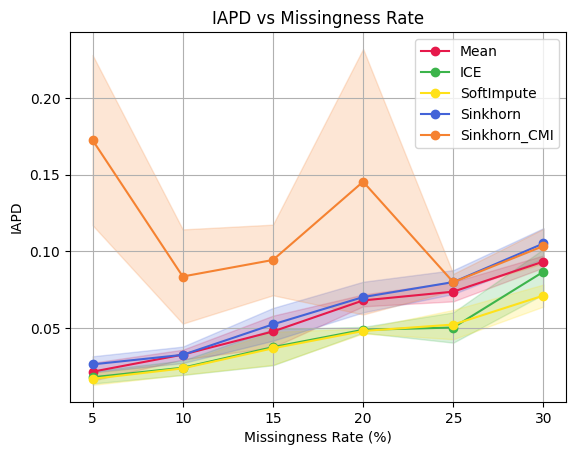

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

missing_rates = [5,10,15,20,25, 30]
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231']

# Replace the below placeholders with actual numpy arrays (shape: [6, 4] if 4 runs per rate)
iapd_results_mnar = {
    'Mean': [mean_iapd_mnar5, mean_iapd_mnar10, mean_iapd_mnar15, mean_iapd_mnar20, mean_iapd_mnar25, mean_iapd_mnar30],
    'ICE': [ice_iapd_mnar5, ice_iapd_mnar10, ice_iapd_mnar15, ice_iapd_mnar20, ice_iapd_mnar25, ice_iapd_mnar30],
    'SoftImpute': [soft_iapd_mnar5, soft_iapd_mnar10, soft_iapd_mnar15, soft_iapd_mnar20, soft_iapd_mnar25, soft_iapd_mnar30],
    'Sinkhorn': [sk_iapd_mnar5, sk_iapd_mnar10, sk_iapd_mnar15, sk_iapd_mnar20, sk_iapd_mnar25,sk_iapd_mnar30],
    'Sinkhorn_CMI': [sk_cmi_iapd_mnar5,sk_cmi_iapd_mnar10,sk_cmi_iapd_mnar15,sk_cmi_iapd_mnar20,sk_cmi_iapd_mnar25,sk_cmi_iapd_mnar30]
}



fig, ax1 = plt.subplots()
# Now ax1 is a single Axes object



for i, algo in enumerate(algorithms):
    data = np.array(iapd_results_mnar[algo])
    means = np.mean(data, axis=1)
    stds = np.std(data, axis=1)
    ax1.plot(missing_rates, means, label=algo, color=colors[i], marker='o')
    ax1.fill_between(missing_rates, means - stds, means + stds, alpha=0.2, color=colors[i])

ax1.set_ylabel('IAPD')
ax1.set_xlabel('Missingness Rate (%)')
ax1.set_title('IAPD vs Missingness Rate (MNAR)')
ax1.grid(True)
ax1.legend()



### Machine Learning

In [ ]:
k = 5  # Choose the number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)


In [ ]:
x = groundTruth.iloc[:, :-1]  # x is not scaled
y = groundTruth.iloc[:, -1]  # y is not scaled

MCAR 30%

In [ ]:

missing_type = "MCAR"
missing_rate = 30
dependencies = None
highest_lamda_cmi = 30
niter = 5000
protected_index = 1
accuracy_sk_mcar30 = []
accuracy_sk_cmi_mcar30 = []
accuracy_mean_mcar30 = []
accuracy_ice_mcar30 = []
accuracy_soft_imp_mcar30 = []
demoP_sk_mcar30 = []
demoP_sk_cmi_mcar30 = []
demoP_mean_mcar30 = []
demoP_ice_mcar30 = []
demoP_soft_imp_mcar30 = []
equiod_sk_mcar30 = []
equiod_sk_cmi_mcar30 = []
equiod_mean_mcar30 = []
equiod_ice_mcar30 = []
equiod_soft_imp_mcar30 = []
bucket = {1:2} 


# X and Y is scaled to z-score

for fold, (train_index, test_index) in enumerate(kf.split(x)):
    x_train = x.iloc[train_index].reset_index(drop=True)  # No index numbers
    x_test = x.iloc[test_index].reset_index(drop=True)    # No index numbers
    y_train = y.iloc[train_index].reset_index(drop=True)  # No index numbers
    y_test = y.iloc[test_index].reset_index(drop=True)    # No index numbers

    #z-score

    scaler = StandardScaler()
    x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns) # converting x_trian and x_test to z-score
    x_test = scaler.transform(x_test)
   

    
    x_train_sk_imp_data, x_train_sk_cmi_imp_data, x_train_mean_imp_data, x_train_ice_imp_data, x_train_soft_imp_data = imputation(x_train, y_train, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    
   

    

    y_test = y_test.to_numpy()
    y_train = y_train.to_numpy()

    
    acc_sk, dp_sk, eod_sk = machineLearning(x_train_sk_imp_data[:, :-1], y_train, x_test, y_test, protected_index, bucket)
    equiod_sk_mcar30.append(eod_sk)
    accuracy_sk_mcar30.append(acc_sk)
    demoP_sk_mcar30.append(dp_sk)

    acc_sk_cmi, dp_sk_cmi, eod_sk_cmi = machineLearning(x_train_sk_cmi_imp_data[:, :-1], y_train, x_test, y_test, protected_index, bucket)
    equiod_sk_cmi_mcar30.append(eod_sk_cmi)
    accuracy_sk_cmi_mcar30.append(acc_sk_cmi)
    demoP_sk_cmi_mcar30.append(dp_sk_cmi)

    acc_mean, dp_mean, eod_mean = machineLearning(x_train_mean_imp_data[:, :-1], y_train, x_test, y_test, protected_index, bucket)
    equiod_mean_mcar30.append(eod_mean)
    accuracy_mean_mcar30.append(acc_mean)
    demoP_mean_mcar30.append(dp_mean)

    acc_ice, dp_ice, eod_ice = machineLearning(x_train_ice_imp_data[:, :-1], y_train, x_test, y_test, protected_index, bucket)
    equiod_ice_mcar30.append(eod_ice)
    accuracy_ice_mcar30.append(acc_ice)
    demoP_ice_mcar30.append(dp_ice)

    acc_soft_imp, dp_soft_imp, eod_soft_imp = machineLearning(x_train_soft_imp_data[:, :-1], y_train, x_test, y_test, protected_index, bucket)
    equiod_soft_imp_mcar30.append(eod_soft_imp)
    accuracy_soft_imp_mcar30.append(acc_soft_imp)
    demoP_soft_imp_mcar30.append(dp_soft_imp) 


INFO:root:batchsize = 128, epsilon = 0.4088
INFO:root:Iteration 0:	 Loss: 2.3403
INFO:root:Iteration 50:	 Loss: 1.8285
INFO:root:Iteration 100:	 Loss: 1.8166
INFO:root:Iteration 150:	 Loss: 1.9226
INFO:root:Iteration 200:	 Loss: 1.7437
INFO:root:Iteration 250:	 Loss: 2.0503
INFO:root:Iteration 300:	 Loss: 1.6884
INFO:root:Iteration 350:	 Loss: 1.8883
INFO:root:Iteration 400:	 Loss: 1.8251
INFO:root:Iteration 450:	 Loss: 1.9058
INFO:root:Iteration 500:	 Loss: 1.9583
INFO:root:Iteration 550:	 Loss: 1.9835
INFO:root:Iteration 600:	 Loss: 2.0516
INFO:root:Iteration 650:	 Loss: 1.9122
INFO:root:Iteration 700:	 Loss: 1.6265
INFO:root:Iteration 750:	 Loss: 1.9593
INFO:root:Iteration 800:	 Loss: 1.7096
INFO:root:Iteration 850:	 Loss: 1.8359
INFO:root:Iteration 900:	 Loss: 1.7795
INFO:root:Iteration 950:	 Loss: 1.6582
INFO:root:Iteration 1000:	 Loss: 2.0079
INFO:root:Iteration 1050:	 Loss: 2.0225
INFO:root:Iteration 1100:	 Loss: 1.8647
INFO:root:Iteration 1150:	 Loss: 1.7868
INFO:root:Iteration

[[-1.56565176  0.         -0.52605558 ... -0.83846064 -0.83628643
  -1.07985506]
 [-1.03134434  0.         -1.71048747 ...  1.19266183  1.93580858
   0.58880518]
 [-0.06959099  0.         -0.52605558 ... -0.83846064 -0.83628643
   0.58880518]
 ...
 [-1.03134434  0.          0.65837631 ...  1.19266183  1.75100224
   2.25746543]
 [ 0.35785494  1.          0.65837631 ...  1.19266183 -0.65148009
   0.58880518]
 [-0.92448286  0.          1.8428082  ... -0.83846064  0.27255158
   0.58880518]]
[[-1.44824897  0.         -1.68275959 ... -0.85387176 -0.81687594
  -1.07245382]
 [ 0.42582269  1.         -0.50637575 ...  0.17811456 -0.29049067
   0.57407822]
 [-1.76826932  0.         -1.68275959 ... -0.85387176 -0.81687594
  -1.00511425]
 ...
 [ 0.95993042  0.         -0.02748846 ...  1.17113604  0.27414628
   0.57407822]
 [ 0.3651997   1.         -1.68275959 ... -0.85387176 -0.81687594
   0.57407822]
 [ 0.40903487  0.         -0.50637575 ... -0.85387176 -0.57829108
  -1.07245382]]
[[-1.56565176  0

INFO:root:batchsize = 128, epsilon = 0.4097
INFO:root:Iteration 0:	 Loss: 2.1965
INFO:root:Iteration 50:	 Loss: 1.9964
INFO:root:Iteration 100:	 Loss: 1.9557
INFO:root:Iteration 150:	 Loss: 1.8748
INFO:root:Iteration 200:	 Loss: 1.9047
INFO:root:Iteration 250:	 Loss: 1.4390
INFO:root:Iteration 300:	 Loss: 1.9285
INFO:root:Iteration 350:	 Loss: 2.0274
INFO:root:Iteration 400:	 Loss: 1.9895
INFO:root:Iteration 450:	 Loss: 1.9804
INFO:root:Iteration 500:	 Loss: 1.9546
INFO:root:Iteration 550:	 Loss: 2.0184
INFO:root:Iteration 600:	 Loss: 1.7169
INFO:root:Iteration 650:	 Loss: 1.8729
INFO:root:Iteration 700:	 Loss: 1.8200
INFO:root:Iteration 750:	 Loss: 1.9649
INFO:root:Iteration 800:	 Loss: 1.7063
INFO:root:Iteration 850:	 Loss: 1.7543
INFO:root:Iteration 900:	 Loss: 1.7439
INFO:root:Iteration 950:	 Loss: 1.9786
INFO:root:Iteration 1000:	 Loss: 1.8338
INFO:root:Iteration 1050:	 Loss: 1.9374
INFO:root:Iteration 1100:	 Loss: 1.7762
INFO:root:Iteration 1150:	 Loss: 2.0732
INFO:root:Iteration

[[-1.70512033  0.         -1.69758728 ... -0.81974495 -0.82286059
  -1.04436386]
 [-0.87144285  1.         -1.69758728 ... -0.81974495 -0.82286059
  -1.04436386]
 [ 0.06644432  0.         -1.69758728 ... -0.81974495 -0.82286059
  -1.04436386]
 ...
 [ 0.27486369  0.         -1.69758728 ... -0.81974495 -0.82286059
   2.28128939]
 [ 0.58749275  0.          0.62926438 ... -0.81974495  0.1115139
   0.61846276]
 [ 0.37907338  1.         -1.69758728 ... -0.81974495 -0.82286059
   0.61846276]]
[[-1.45513734  0.         -1.78049451 ... -0.81776257 -0.8128952
  -1.04671914]
 [-0.50045845  0.         -0.59425712 ... -0.8151657   0.16333876
   0.59767347]
 [-0.60653388  0.          0.59198027 ...  1.22674446  0.65145573
   0.59767347]
 ...
 [ 0.97358452  0.          0.59198027 ... -0.8151657   2.50630025
   0.59767347]
 [ 0.32304056  0.          0.58024662 ...  1.22674446 -0.16886877
   0.59447967]
 [-0.15141556  0.          0.16875277 ... -0.8151657  -0.8128952
  -1.04671914]]
[[-1.70512033  0.  

INFO:root:batchsize = 128, epsilon = 0.4124
INFO:root:Iteration 0:	 Loss: 2.0841
INFO:root:Iteration 50:	 Loss: 1.9600
INFO:root:Iteration 100:	 Loss: 1.9683
INFO:root:Iteration 150:	 Loss: 1.6511
INFO:root:Iteration 200:	 Loss: 2.2380
INFO:root:Iteration 250:	 Loss: 1.8693
INFO:root:Iteration 300:	 Loss: 1.7979
INFO:root:Iteration 350:	 Loss: 1.9418
INFO:root:Iteration 400:	 Loss: 1.9997
INFO:root:Iteration 450:	 Loss: 1.8830
INFO:root:Iteration 500:	 Loss: 1.8547
INFO:root:Iteration 550:	 Loss: 1.9342
INFO:root:Iteration 600:	 Loss: 1.9690
INFO:root:Iteration 650:	 Loss: 2.1345
INFO:root:Iteration 700:	 Loss: 2.2198
INFO:root:Iteration 750:	 Loss: 2.0081
INFO:root:Iteration 800:	 Loss: 1.7829
INFO:root:Iteration 850:	 Loss: 1.8765
INFO:root:Iteration 900:	 Loss: 1.7779
INFO:root:Iteration 950:	 Loss: 1.7338
INFO:root:Iteration 1000:	 Loss: 1.9388
INFO:root:Iteration 1050:	 Loss: 1.6805
INFO:root:Iteration 1100:	 Loss: 1.9046
INFO:root:Iteration 1150:	 Loss: 1.9186
INFO:root:Iteration

[[-1.47440718  0.         -1.74242047 ... -0.81048435 -0.83312597
  -1.03822882]
 [-0.61754663  1.          0.6369965  ...  1.23383012  0.5789302
   0.607689  ]
 [-0.61754663  1.         -1.74242047 ... -0.81048435 -0.83312597
  -1.03822882]
 ...
 [ 0.98906689  0.          0.6369965  ...  1.23383012  2.93235716
  -1.03822882]
 [ 0.98906689  1.          0.6369965  ...  1.23383012 -0.83312597
   0.607689  ]
 [-1.68862232  0.         -0.55271198 ... -0.81048435 -0.83312597
  -1.03822882]]
[[ 0.33522702  1.          0.34052167 ...  0.80538684  0.12793343
   0.63501189]
 [-1.80279027  0.         -1.73864394 ... -0.79152515 -0.8459067
  -1.04984377]
 [ 0.34419599  0.          0.94639975 ... -0.81986915 -0.8459067
  -0.93394377]
 ...
 [ 1.53480217  0.          0.63328091 ... -0.81986915  2.32325955
   1.06592933]
 [ 0.35049517  0.          0.63328091 ... -0.76776177  0.27262256
   0.63501189]
 [-0.69776188  0.         -1.73864394 ... -0.77699009 -0.8459067
   0.83419537]]
[[-1.47440718  0.   

INFO:root:batchsize = 128, epsilon = 0.4114
INFO:root:Iteration 0:	 Loss: 2.1154
INFO:root:Iteration 50:	 Loss: 2.0596
INFO:root:Iteration 100:	 Loss: 1.8048
INFO:root:Iteration 150:	 Loss: 1.9226
INFO:root:Iteration 200:	 Loss: 1.7756
INFO:root:Iteration 250:	 Loss: 1.5828
INFO:root:Iteration 300:	 Loss: 1.9874
INFO:root:Iteration 350:	 Loss: 1.7511
INFO:root:Iteration 400:	 Loss: 1.9219
INFO:root:Iteration 450:	 Loss: 1.7843
INFO:root:Iteration 500:	 Loss: 2.1620
INFO:root:Iteration 550:	 Loss: 1.6608
INFO:root:Iteration 600:	 Loss: 1.6558
INFO:root:Iteration 650:	 Loss: 1.9653
INFO:root:Iteration 700:	 Loss: 1.7380
INFO:root:Iteration 750:	 Loss: 1.6262
INFO:root:Iteration 800:	 Loss: 1.5426
INFO:root:Iteration 850:	 Loss: 1.8230
INFO:root:Iteration 900:	 Loss: 1.9643
INFO:root:Iteration 950:	 Loss: 1.7644
INFO:root:Iteration 1000:	 Loss: 2.0474
INFO:root:Iteration 1050:	 Loss: 1.8305
INFO:root:Iteration 1100:	 Loss: 1.6751
INFO:root:Iteration 1150:	 Loss: 1.6463
INFO:root:Iteration

[[-1.74646407  0.          0.63544953 ...  1.21439181  0.57013228
   0.58874057]
 [-1.63994585  0.          0.63544953 ... -0.82345746 -0.82886803
   0.58874057]
 [-0.04217252  0.          0.63544953 ...  1.21439181  1.96913259
   0.58874057]
 ...
 [ 0.49041859  0.         -1.67670593 ... -0.82345746 -0.45580128
   0.58874057]
 [ 1.44908259  0.         -0.5206282  ... -0.82345746 -0.08273453
   0.58874057]
 [ 0.38390037  0.          0.63544953 ...  1.21439181  0.29033222
   0.58874057]]
[[-1.48226624  0.         -0.89685037 ... -0.82625196 -0.82673659
  -1.01221833]
 [-0.51153136  0.         -0.54208023 ... -0.74529917  0.09166636
   0.62241997]
 [-1.80584454  0.         -0.06212847 ... -0.4626388  -0.82673659
  -1.01221833]
 ...
 [ 1.53779783  0.          0.61578412 ...  0.99994976  0.59805658
   0.62241997]
 [ 0.35134409  1.         -1.69994457 ... -0.82625196 -0.03932198
   0.62241997]
 [-0.13932699  0.         -0.54208023 ... -0.82625196 -0.82673659
  -1.01221833]]
[[-1.74646407  0

INFO:root:batchsize = 128, epsilon = 0.4083
INFO:root:Iteration 0:	 Loss: 1.8729
INFO:root:Iteration 50:	 Loss: 1.7660
INFO:root:Iteration 100:	 Loss: 2.0786
INFO:root:Iteration 150:	 Loss: 1.6967
INFO:root:Iteration 200:	 Loss: 2.0414
INFO:root:Iteration 250:	 Loss: 1.5957
INFO:root:Iteration 300:	 Loss: 1.8025
INFO:root:Iteration 350:	 Loss: 1.5255
INFO:root:Iteration 400:	 Loss: 1.6579
INFO:root:Iteration 450:	 Loss: 1.7916
INFO:root:Iteration 500:	 Loss: 1.6785
INFO:root:Iteration 550:	 Loss: 1.8593
INFO:root:Iteration 600:	 Loss: 1.6652
INFO:root:Iteration 650:	 Loss: 2.0084
INFO:root:Iteration 700:	 Loss: 1.7550
INFO:root:Iteration 750:	 Loss: 1.7029
INFO:root:Iteration 800:	 Loss: 1.7370
INFO:root:Iteration 850:	 Loss: 1.8711
INFO:root:Iteration 900:	 Loss: 1.7416
INFO:root:Iteration 950:	 Loss: 2.1452
INFO:root:Iteration 1000:	 Loss: 1.7900
INFO:root:Iteration 1050:	 Loss: 1.8310
INFO:root:Iteration 1100:	 Loss: 1.8961
INFO:root:Iteration 1150:	 Loss: 1.8029
INFO:root:Iteration

[[-0.46347798  1.         -0.52205215 ... -0.82578581  0.11759768
   0.57742057]
 [ 0.06565578  0.         -0.52205215 ... -0.82578581 -0.8417175
  -1.06120537]
 [-0.46347798  0.          0.65858886 ...  1.21096778  0.11759768
   0.57742057]
 ...
 [-1.9450525   0.         -1.70269316 ... -0.82578581 -0.8417175
  -1.06120537]
 [-1.31009199  0.         -1.70269316 ... -0.82578581 -0.8417175
  -1.06120537]
 [ 1.5472303   0.          0.65858886 ... -0.82578581  2.41995413
   0.57742057]]
[[-1.42216682  0.         -1.77667137 ... -0.83128208 -0.64532903
  -1.11896484]
 [-1.73678941  0.          0.38221722 ... -0.83128208 -0.87646986
  -1.05321563]
 [-0.58317327  0.          0.64438858 ...  1.20296109  0.56889601
   0.53207262]
 ...
 [ 0.47537788  0.          0.38823769 ... -0.74513784 -0.1267083
   0.53207262]
 [-0.17252732  0.         -0.11887674 ... -0.83128208 -0.87646986
   0.53207262]
 [-1.4558978   0.         -0.5661414  ... -0.76921958 -0.87646986
  -1.11896484]]
[[-0.46347798  1.   

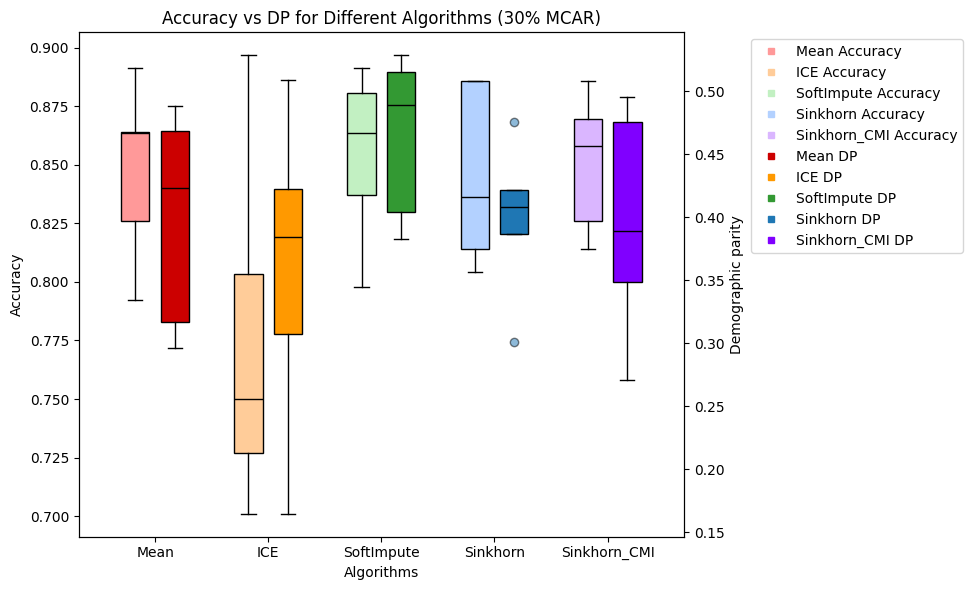

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
accuracy_mcar30 = {
    'Mean': accuracy_mean_mcar30,
    'ICE': accuracy_ice_mcar30,
    'SoftImpute': accuracy_soft_imp_mcar30,
    'Sinkhorn': accuracy_sk_mcar30,
    'Sinkhorn_CMI': accuracy_sk_cmi_mcar30
}
dp_mcar30 = {
    'Mean': demoP_mean_mcar30,
    'ICE': demoP_ice_mcar30,
    'SoftImpute': demoP_soft_imp_mcar30,
    'Sinkhorn': demoP_sk_mcar30,
    'Sinkhorn_CMI': demoP_sk_cmi_mcar30
}




# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    accuracy_vals = accuracy_mcar30[algo]
    dp_vals = dp_mcar30[algo]

    # MAE box (lighter color)
    ax1.boxplot(accuracy_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(dp_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Accuracy', color='black')
ax2.set_ylabel('Demographic parity', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('Accuracy vs DP for Different Algorithms (30% MCAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} Accuracy')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} DP')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


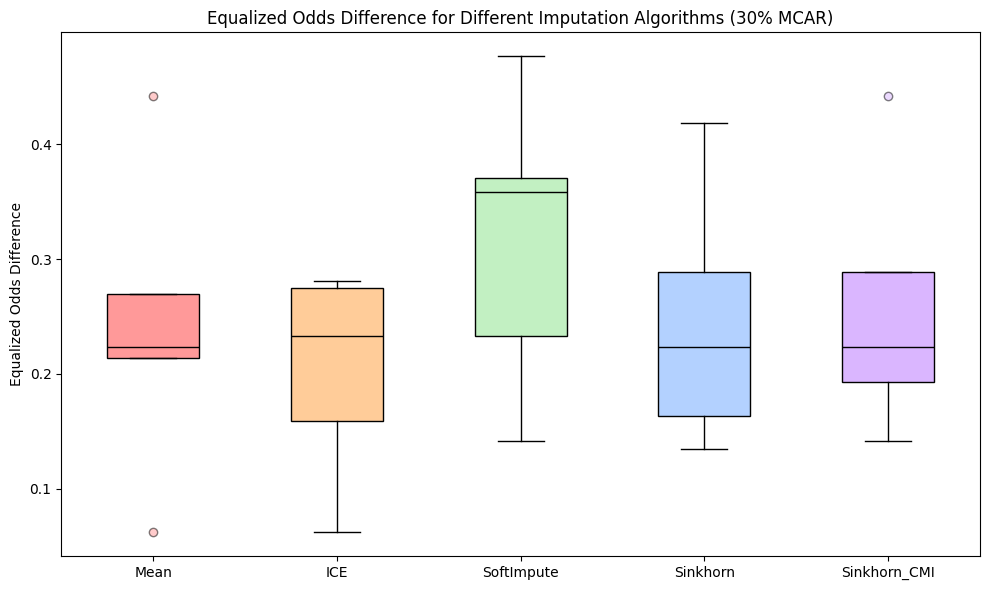

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with your actual EOD results (lists or numpy arrays)
eod_mcar30 = {
    'Mean': equiod_mean_mcar30,
    'ICE': equiod_ice_mcar30,
    'SoftImpute': equiod_soft_imp_mcar30,
    'Sinkhorn': equiod_sk_mcar30,
    'Sinkhorn_CMI': equiod_sk_cmi_mcar30
}

# Colors for EOD
colors = ['#ff9999', '#ffcc99', '#c2f0c2', '#b3d1ff', '#dab6ff']

# Create boxplot
x = np.arange(len(algorithms))

fig, ax = plt.subplots(figsize=(10, 6))

for i, algo in enumerate(algorithms):
    eod_vals = eod_mcar30[algo]
    ax.boxplot(eod_vals, positions=[x[i]], widths=0.5, patch_artist=True,
               boxprops=dict(facecolor=colors[i], color='black'),
               medianprops=dict(color='black'),
               capprops=dict(color='black'),
               whiskerprops=dict(color='black'),
               flierprops=dict(markerfacecolor=colors[i], marker='o', alpha=0.5))

# Axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.set_ylabel('Equalized Odds Difference')
ax.set_title('Equalized Odds Difference for Different Imputation Algorithms (30% MCAR)')

plt.tight_layout()
plt.show()


MAR 30%

In [ ]:

missing_type = "MAR"
missing_rate = 30
dependencies = dependencies_mar
highest_lamda_cmi = 30
niter = 5000
protected_index = 1
accuracy_sk_mar30 = []
accuracy_sk_cmi_mar30 = []
accuracy_mean_mar30 = []
accuracy_ice_mar30 = []
accuracy_soft_imp_mar30 = []
demoP_sk_mar30 = []
demoP_sk_cmi_mar30 = []
demoP_mean_mar30 = []
demoP_ice_mar30 = []
demoP_soft_imp_mar30 = []
equiod_sk_mar30 = []
equiod_sk_cmi_mar30 = []
equiod_mean_mar30 = []
equiod_ice_mar30 = []
equiod_soft_imp_mar30 = []
bucket = {1:2} 


# X and Y is scaled to z-score

for fold, (train_index, test_index) in enumerate(kf.split(x)):
    x_train = x.iloc[train_index].reset_index(drop=True)  # No index numbers
    x_test = x.iloc[test_index].reset_index(drop=True)    # No index numbers
    y_train = y.iloc[train_index].reset_index(drop=True)  # No index numbers
    y_test = y.iloc[test_index].reset_index(drop=True)    # No index numbers

    #z-score

    scaler = StandardScaler()
    x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
    x_test = scaler.transform(x_test)
   

    
    x_train_sk_imp_data, x_train_sk_cmi_imp_data, x_train_mean_imp_data, x_train_ice_imp_data, x_train_soft_imp_data = imputation(x_train, y_train, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    
   

    

    y_test = y_test.to_numpy()
    y_train = y_train.to_numpy()

    
    acc_sk, dp_sk, eod_sk = machineLearning(x_train_sk_imp_data[:, :-1], y_train, x_test, y_test,protected_index,bucket)
    equiod_sk_mar30.append(eod_sk)
    accuracy_sk_mar30.append(acc_sk)
    demoP_sk_mar30.append(dp_sk)

    acc_sk_cmi, dp_sk_cmi, eod_sk_cmi = machineLearning(x_train_sk_cmi_imp_data[:, :-1], y_train, x_test, y_test,protected_index,bucket)
    equiod_sk_cmi_mar30.append(eod_sk_cmi)
    accuracy_sk_cmi_mar30.append(acc_sk_cmi)
    demoP_sk_cmi_mar30.append(dp_sk_cmi)

    acc_mean, dp_mean, eod_mean = machineLearning(x_train_mean_imp_data[:, :-1], y_train, x_test, y_test,protected_index,bucket)
    equiod_mean_mar30.append(eod_mean)
    accuracy_mean_mar30.append(acc_mean)
    demoP_mean_mar30.append(dp_mean)

    acc_ice, dp_ice, eod_ice = machineLearning(x_train_ice_imp_data[:, :-1], y_train, x_test, y_test,protected_index,bucket)
    equiod_ice_mar30.append(eod_ice)
    accuracy_ice_mar30.append(acc_ice)
    demoP_ice_mar30.append(dp_ice)

    acc_soft_imp, dp_soft_imp, eod_soft_imp = machineLearning(x_train_soft_imp_data[:, :-1], y_train, x_test, y_test,protected_index,bucket)
    equiod_soft_imp_mar30.append(eod_soft_imp)
    accuracy_soft_imp_mar30.append(acc_soft_imp)
    demoP_soft_imp_mar30.append(dp_soft_imp) 


(734, 11)


INFO:root:batchsize = 128, epsilon = 0.4138
INFO:root:Iteration 0:	 Loss: 1.9077
INFO:root:Iteration 50:	 Loss: 1.8337
INFO:root:Iteration 100:	 Loss: 1.6678
INFO:root:Iteration 150:	 Loss: 1.6474
INFO:root:Iteration 200:	 Loss: 1.7791
INFO:root:Iteration 250:	 Loss: 1.7727
INFO:root:Iteration 300:	 Loss: 1.3731
INFO:root:Iteration 350:	 Loss: 1.7950
INFO:root:Iteration 400:	 Loss: 1.5525
INFO:root:Iteration 450:	 Loss: 1.8998
INFO:root:Iteration 500:	 Loss: 1.9112
INFO:root:Iteration 550:	 Loss: 1.7866
INFO:root:Iteration 600:	 Loss: 1.7890
INFO:root:Iteration 650:	 Loss: 2.0247
INFO:root:Iteration 700:	 Loss: 1.4127
INFO:root:Iteration 750:	 Loss: 2.0758
INFO:root:Iteration 800:	 Loss: 1.8829
INFO:root:Iteration 850:	 Loss: 1.6516
INFO:root:Iteration 900:	 Loss: 1.6553
INFO:root:Iteration 950:	 Loss: 1.7247
INFO:root:Iteration 1000:	 Loss: 1.8437
INFO:root:Iteration 1050:	 Loss: 1.7808
INFO:root:Iteration 1100:	 Loss: 1.7728
INFO:root:Iteration 1150:	 Loss: 1.9068
INFO:root:Iteration

[[-1.56565176  0.         -0.52605558 ... -0.83846064 -0.83628643
  -1.07985506]
 [-1.03134434  0.         -1.71048747 ...  1.19266183  1.93580858
   0.58880518]
 [-0.06959099  0.         -0.52605558 ... -0.83846064 -0.83628643
   0.58880518]
 ...
 [-1.03134434  0.          0.65837631 ...  1.19266183  1.75100224
   2.25746543]
 [ 0.35785494  1.          0.65837631 ...  1.19266183 -0.65148009
   0.58880518]
 [-0.92448286  0.          1.8428082  ... -0.83846064  0.27255158
   0.58880518]]
[[-1.45879027  0.         -0.96133787 ... -0.85487268 -0.7577868
  -1.05151871]
 [-0.49703693  1.         -0.63799308 ... -0.23910153  0.24594105
   0.6150748 ]
 [-1.77937472  0.         -0.40214571 ... -0.81471838 -0.7577868
  -1.05873531]
 ...
 [ 0.35785494  0.          0.57723184 ...  1.10584428  0.11767737
   0.81002552]
 [ 0.35785494  1.         -1.85321801 ... -0.90428645  0.02295389
   0.6150748 ]
 [-1.67251324  0.         -0.63799308 ... -0.90428645 -0.65800282
  -1.05873531]]
[[-1.56565176  0. 

INFO:root:batchsize = 128, epsilon = 0.4120
INFO:root:Iteration 0:	 Loss: 1.9715
INFO:root:Iteration 50:	 Loss: 1.6956
INFO:root:Iteration 100:	 Loss: 1.8833
INFO:root:Iteration 150:	 Loss: 1.8608
INFO:root:Iteration 200:	 Loss: 1.9981
INFO:root:Iteration 250:	 Loss: 1.7485
INFO:root:Iteration 300:	 Loss: 2.0614
INFO:root:Iteration 350:	 Loss: 1.7322
INFO:root:Iteration 400:	 Loss: 1.8809
INFO:root:Iteration 450:	 Loss: 1.8369
INFO:root:Iteration 500:	 Loss: 1.9409
INFO:root:Iteration 550:	 Loss: 1.8589
INFO:root:Iteration 600:	 Loss: 1.5814
INFO:root:Iteration 650:	 Loss: 1.9286
INFO:root:Iteration 700:	 Loss: 1.6829
INFO:root:Iteration 750:	 Loss: 1.8938
INFO:root:Iteration 800:	 Loss: 1.8237
INFO:root:Iteration 850:	 Loss: 1.6889
INFO:root:Iteration 900:	 Loss: 1.6970
INFO:root:Iteration 950:	 Loss: 1.7389
INFO:root:Iteration 1000:	 Loss: 1.7229
INFO:root:Iteration 1050:	 Loss: 1.7733
INFO:root:Iteration 1100:	 Loss: 2.0776
INFO:root:Iteration 1150:	 Loss: 1.6054
INFO:root:Iteration

[[-1.70512033  0.         -1.69758728 ... -0.81974495 -0.82286059
  -1.04436386]
 [-0.87144285  1.         -1.69758728 ... -0.81974495 -0.82286059
  -1.04436386]
 [ 0.06644432  0.         -1.69758728 ... -0.81974495 -0.82286059
  -1.04436386]
 ...
 [ 0.27486369  0.         -1.69758728 ... -0.81974495 -0.82286059
   2.28128939]
 [ 0.58749275  0.          0.62926438 ... -0.81974495  0.1115139
   0.61846276]
 [ 0.37907338  1.         -1.69758728 ... -0.81974495 -0.82286059
   0.61846276]]
[[-1.39249127  0.         -0.93965699 ... -0.85506261 -0.7014541
  -1.06930302]
 [-0.4546041   1.          0.49817115 ...  0.18748777  0.21705619
   0.51483799]
 [-0.55881379  1.          0.19523488 ... -0.09065313  0.30109633
   0.5839809 ]
 ...
 [ 1.52537992  0.          0.5564185  ...  1.07529292  2.56061027
   0.73944749]
 [ 0.37907338  0.          0.57562247 ...  1.00208096  0.1200338
   0.59924029]
 [-1.60091064  0.         -1.17310349 ... -0.82616508 -0.75629389
  -1.04942503]]
[[-1.70512033  0.  

INFO:root:batchsize = 128, epsilon = 0.4132
INFO:root:Iteration 0:	 Loss: 1.9299
INFO:root:Iteration 50:	 Loss: 1.8785
INFO:root:Iteration 100:	 Loss: 1.6253
INFO:root:Iteration 150:	 Loss: 1.7625
INFO:root:Iteration 200:	 Loss: 1.7014
INFO:root:Iteration 250:	 Loss: 1.7088
INFO:root:Iteration 300:	 Loss: 1.6937
INFO:root:Iteration 350:	 Loss: 1.8553
INFO:root:Iteration 400:	 Loss: 1.6344
INFO:root:Iteration 450:	 Loss: 1.6323
INFO:root:Iteration 500:	 Loss: 1.4385
INFO:root:Iteration 550:	 Loss: 1.5290
INFO:root:Iteration 600:	 Loss: 1.9485
INFO:root:Iteration 650:	 Loss: 2.0877
INFO:root:Iteration 700:	 Loss: 1.6832
INFO:root:Iteration 750:	 Loss: 1.8124
INFO:root:Iteration 800:	 Loss: 1.7258
INFO:root:Iteration 850:	 Loss: 1.7279
INFO:root:Iteration 900:	 Loss: 1.7129
INFO:root:Iteration 950:	 Loss: 1.6425
INFO:root:Iteration 1000:	 Loss: 1.7044
INFO:root:Iteration 1050:	 Loss: 1.6719
INFO:root:Iteration 1100:	 Loss: 1.8435
INFO:root:Iteration 1150:	 Loss: 2.0799
INFO:root:Iteration

[[-1.47440718  0.         -1.74242047 ... -0.81048435 -0.83312597
  -1.03822882]
 [-0.61754663  1.          0.6369965  ...  1.23383012  0.5789302
   0.607689  ]
 [-0.61754663  1.         -1.74242047 ... -0.81048435 -0.83312597
  -1.03822882]
 ...
 [ 0.98906689  0.          0.6369965  ...  1.23383012  2.93235716
  -1.03822882]
 [ 0.98906689  1.          0.6369965  ...  1.23383012 -0.83312597
   0.607689  ]
 [-1.68862232  0.         -0.55271198 ... -0.81048435 -0.83312597
  -1.03822882]]
[[-0.51043907  1.         -0.62153031 ...  0.41119221 -0.07666488
   0.59009453]
 [-1.79572989  0.         -1.83499426 ... -0.96382662 -0.74697367
  -1.04467205]
 [ 0.02509878  0.         -0.62153031 ... -0.85243425 -0.65064403
  -1.03000388]
 ...
 [ 1.52460473  0.          0.59193363 ...  0.34576454  0.23264253
   0.5840007 ]
 [ 0.34642148  0.          0.59193363 ...  1.03753101 -0.29732999
   0.5840007 ]
 [ 0.34642148  1.          0.27052343 ... -0.63697674 -0.01749761
   0.5840007 ]]
[[-1.47440718  0.

INFO:root:batchsize = 128, epsilon = 0.4118
INFO:root:Iteration 0:	 Loss: 1.6833
INFO:root:Iteration 50:	 Loss: 1.7183
INFO:root:Iteration 100:	 Loss: 1.6203
INFO:root:Iteration 150:	 Loss: 1.7514
INFO:root:Iteration 200:	 Loss: 1.7690
INFO:root:Iteration 250:	 Loss: 1.8660
INFO:root:Iteration 300:	 Loss: 1.8768
INFO:root:Iteration 350:	 Loss: 2.0589
INFO:root:Iteration 400:	 Loss: 1.8135
INFO:root:Iteration 450:	 Loss: 1.8122
INFO:root:Iteration 500:	 Loss: 1.7089
INFO:root:Iteration 550:	 Loss: 1.9842
INFO:root:Iteration 600:	 Loss: 1.7805
INFO:root:Iteration 650:	 Loss: 1.9485
INFO:root:Iteration 700:	 Loss: 1.8199
INFO:root:Iteration 750:	 Loss: 1.8559
INFO:root:Iteration 800:	 Loss: 2.2171
INFO:root:Iteration 850:	 Loss: 1.7319
INFO:root:Iteration 900:	 Loss: 1.5777
INFO:root:Iteration 950:	 Loss: 1.7922
INFO:root:Iteration 1000:	 Loss: 1.7606
INFO:root:Iteration 1050:	 Loss: 1.6634
INFO:root:Iteration 1100:	 Loss: 1.6348
INFO:root:Iteration 1150:	 Loss: 1.9621
INFO:root:Iteration

[[-1.74646407  0.          0.63544953 ...  1.21439181  0.57013228
   0.58874057]
 [-1.63994585  0.          0.63544953 ... -0.82345746 -0.82886803
   0.58874057]
 [-0.04217252  0.          0.63544953 ...  1.21439181  1.96913259
   0.58874057]
 ...
 [ 0.49041859  0.         -1.67670593 ... -0.82345746 -0.45580128
   0.58874057]
 [ 1.44908259  0.         -0.5206282  ... -0.82345746 -0.08273453
   0.58874057]
 [ 0.38390037  0.          0.63544953 ...  1.21439181  0.29033222
   0.58874057]]
[[-1.42690941  0.         -1.15648576 ... -0.4780151  -0.62126533
  -1.02019562]
 [-0.46824541  1.          0.21510197 ...  0.88152226  0.40795695
   0.62515089]
 [-1.74646407  0.         -1.69811592 ... -0.85383589 -0.69173747
  -1.02768449]
 ...
 [ 1.55560081  0.          0.60601906 ... -0.91190951  2.52293386
  -0.02790717]
 [ 0.38390037  1.         -1.69811592 ... -0.54953738 -0.81794239
  -0.43284021]
 [-1.63994585  0.         -0.54604843 ... -0.47860054 -0.81794239
  -0.98598106]]
[[-1.74646407  0

INFO:root:batchsize = 128, epsilon = 0.4105
INFO:root:Iteration 0:	 Loss: 1.6785
INFO:root:Iteration 50:	 Loss: 1.8602
INFO:root:Iteration 100:	 Loss: 1.6480
INFO:root:Iteration 150:	 Loss: 1.7632
INFO:root:Iteration 200:	 Loss: 1.5694
INFO:root:Iteration 250:	 Loss: 1.8600
INFO:root:Iteration 300:	 Loss: 1.6193
INFO:root:Iteration 350:	 Loss: 1.8605
INFO:root:Iteration 400:	 Loss: 1.7951
INFO:root:Iteration 450:	 Loss: 1.3707
INFO:root:Iteration 500:	 Loss: 1.8435
INFO:root:Iteration 550:	 Loss: 2.1229
INFO:root:Iteration 600:	 Loss: 1.6742
INFO:root:Iteration 650:	 Loss: 1.6000
INFO:root:Iteration 700:	 Loss: 1.6951
INFO:root:Iteration 750:	 Loss: 1.7703
INFO:root:Iteration 800:	 Loss: 1.6461
INFO:root:Iteration 850:	 Loss: 1.8785
INFO:root:Iteration 900:	 Loss: 1.8482
INFO:root:Iteration 950:	 Loss: 1.7956
INFO:root:Iteration 1000:	 Loss: 1.7968
INFO:root:Iteration 1050:	 Loss: 1.7294
INFO:root:Iteration 1100:	 Loss: 1.6669
INFO:root:Iteration 1150:	 Loss: 1.9242
INFO:root:Iteration

[[-0.46347798  1.         -0.52205215 ... -0.82578581  0.11759768
   0.57742057]
 [ 0.06565578  0.         -0.52205215 ... -0.82578581 -0.8417175
  -1.06120537]
 [-0.46347798  0.          0.65858886 ...  1.21096778  0.11759768
   0.57742057]
 ...
 [-1.9450525   0.         -1.70269316 ... -0.82578581 -0.8417175
  -1.06120537]
 [-1.31009199  0.         -1.70269316 ... -0.82578581 -0.8417175
  -1.06120537]
 [ 1.5472303   0.          0.65858886 ... -0.82578581  2.41995413
   0.57742057]]
[[-1.41591874  0.         -1.71060211 ... -0.86266219 -0.79010351
  -1.01328412]
 [-1.733399    0.         -0.68831456 ... -0.83100278 -0.79010351
  -1.02028956]
 [-0.56930473  1.          0.6104751  ...  0.83448054  0.13003383
   0.5644881 ]
 ...
 [ 0.38313604  0.          0.6104751  ...  1.15920231  0.36697557
   0.7331498 ]
 [ 0.38313604  1.         -1.71060211 ... -0.86266219 -0.20532206
   0.60055018]
 [-1.62757225  0.         -1.00551702 ... -0.7841924  -0.79010351
  -1.02028956]]
[[-0.46347798  1.  

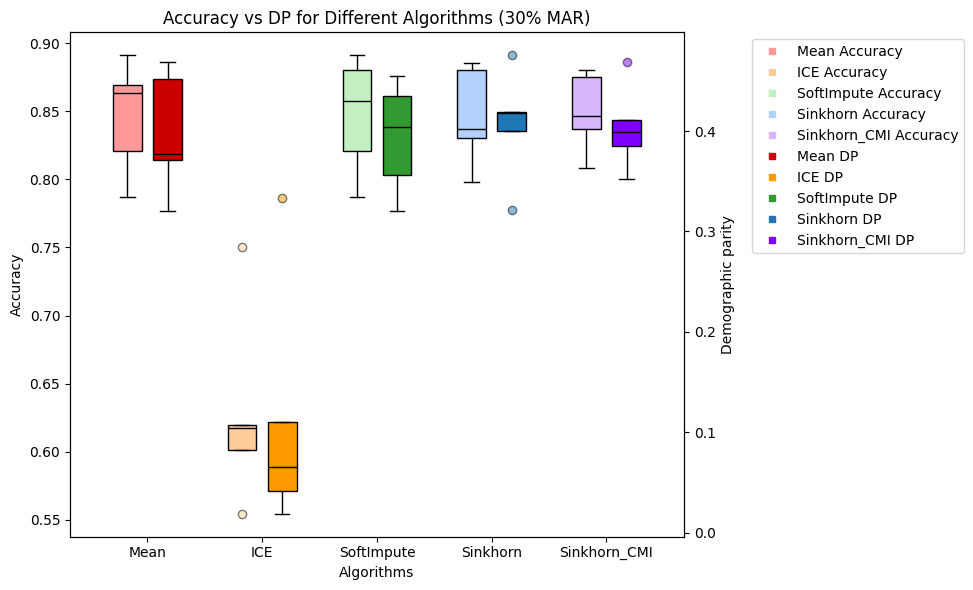

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
accuracy_mar30 = {
    'Mean': accuracy_mean_mar30,
    'ICE': accuracy_ice_mar30,
    'SoftImpute': accuracy_soft_imp_mar30,
    'Sinkhorn': accuracy_sk_mar30,
    'Sinkhorn_CMI': accuracy_sk_cmi_mar30
}
dp_mar30 = {
    'Mean': demoP_mean_mar30,
    'ICE': demoP_ice_mar30,
    'SoftImpute': demoP_soft_imp_mar30,
    'Sinkhorn': demoP_sk_mar30,
    'Sinkhorn_CMI': demoP_sk_cmi_mar30
}




# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    accuracy_vals = accuracy_mar30[algo]
    dp_vals = dp_mar30[algo]

    # MAE box (lighter color)
    ax1.boxplot(accuracy_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(dp_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Accuracy', color='black')
ax2.set_ylabel('Demographic parity', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('Accuracy vs DP for Different Algorithms (30% MAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} Accuracy')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} DP')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


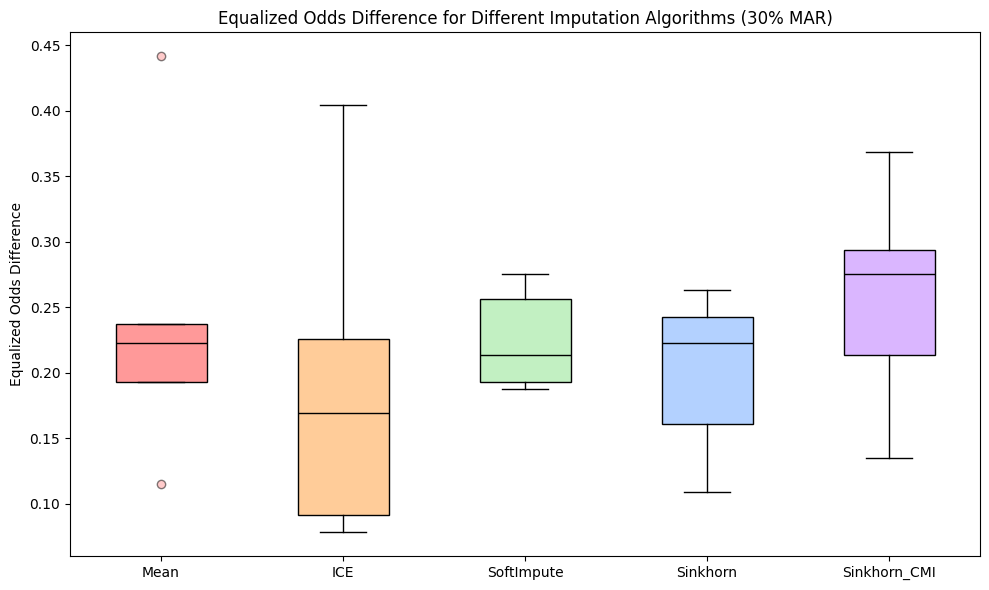

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with your actual EOD results (lists or numpy arrays)
eod_mar30 = {
    'Mean': equiod_mean_mar30,
    'ICE': equiod_ice_mar30,
    'SoftImpute': equiod_soft_imp_mar30,
    'Sinkhorn': equiod_sk_mar30,
    'Sinkhorn_CMI': equiod_sk_cmi_mar30
}

# Colors for EOD
colors = ['#ff9999', '#ffcc99', '#c2f0c2', '#b3d1ff', '#dab6ff']

# Create boxplot
x = np.arange(len(algorithms))

fig, ax = plt.subplots(figsize=(10, 6))

for i, algo in enumerate(algorithms):
    eod_vals = eod_mar30[algo]
    ax.boxplot(eod_vals, positions=[x[i]], widths=0.5, patch_artist=True,
               boxprops=dict(facecolor=colors[i], color='black'),
               medianprops=dict(color='black'),
               capprops=dict(color='black'),
               whiskerprops=dict(color='black'),
               flierprops=dict(markerfacecolor=colors[i], marker='o', alpha=0.5))

# Axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.set_ylabel('Equalized Odds Difference')
ax.set_title('Equalized Odds Difference for Different Imputation Algorithms (30% MAR)')

plt.tight_layout()
plt.show()


30% MNAR

In [ ]:

missing_type = "MNAR"
missing_rate = 30
dependencies = dependencies_mnar
highest_lamda_cmi = 30
niter = 5000
protected_index = 1
accuracy_sk_mnar30 = []
accuracy_sk_cmi_mnar30 = []
accuracy_mean_mnar30 = []
accuracy_ice_mnar30 = []
accuracy_soft_imp_mnar30 = []
demoP_sk_mnar30 = []
demoP_sk_cmi_mnar30 = []
demoP_mean_mnar30 = []
demoP_ice_mnar30 = []
demoP_soft_imp_mnar30 = []
equiod_sk_mnar30 = []
equiod_sk_cmi_mnar30 = []
equiod_mean_mnar30 = []
equiod_ice_mnar30 = []
equiod_soft_imp_mnar30 = []
bucket = {1:2} 


# X and Y is scaled to z-score

for fold, (train_index, test_index) in enumerate(kf.split(x)):
    x_train = x.iloc[train_index].reset_index(drop=True)  # No index numbers
    x_test = x.iloc[test_index].reset_index(drop=True)    # No index numbers
    y_train = y.iloc[train_index].reset_index(drop=True)  # No index numbers
    y_test = y.iloc[test_index].reset_index(drop=True)    # No index numbers

    #z-score

    scaler = StandardScaler()
    x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
    x_test = scaler.transform(x_test)
   

    
    x_train_sk_imp_data, x_train_sk_cmi_imp_data, x_train_mean_imp_data, x_train_ice_imp_data, x_train_soft_imp_data = imputation(x_train, y_train, missing_type, missing_rate, dependencies, highest_lamda_cmi, niter, bucket_specs, X_cols, Y_cols, Z_cols)
    
   

    

    y_test = y_test.to_numpy()
    y_train = y_train.to_numpy()

    
    acc_sk, dp_sk, eod_sk = machineLearning(x_train_sk_imp_data[:, :-1], y_train, x_test, y_test,protected_index,bucket)
    equiod_sk_mnar30.append(eod_sk)
    accuracy_sk_mnar30.append(acc_sk)
    demoP_sk_mnar30.append(dp_sk)

    acc_sk_cmi, dp_sk_cmi, eod_sk_cmi = machineLearning(x_train_sk_cmi_imp_data[:, :-1], y_train, x_test, y_test,protected_index,bucket)
    equiod_sk_cmi_mnar30.append(eod_sk_cmi)
    accuracy_sk_cmi_mnar30.append(acc_sk_cmi)
    demoP_sk_cmi_mnar30.append(dp_sk_cmi)

    acc_mean, dp_mean, eod_mean = machineLearning(x_train_mean_imp_data[:, :-1], y_train, x_test, y_test,protected_index,bucket)
    equiod_mean_mnar30.append(eod_mean)
    accuracy_mean_mnar30.append(acc_mean)
    demoP_mean_mnar30.append(dp_mean)

    acc_ice, dp_ice, eod_ice = machineLearning(x_train_ice_imp_data[:, :-1], y_train, x_test, y_test,protected_index,bucket)
    equiod_ice_mnar30.append(eod_ice)
    accuracy_ice_mnar30.append(acc_ice)
    demoP_ice_mnar30.append(dp_ice)

    acc_soft_imp, dp_soft_imp, eod_soft_imp = machineLearning(x_train_soft_imp_data[:, :-1], y_train, x_test, y_test,protected_index,bucket)
    equiod_soft_imp_mnar30.append(eod_soft_imp)
    accuracy_soft_imp_mnar30.append(acc_soft_imp)
    demoP_soft_imp_mnar30.append(dp_soft_imp) 


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define your algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with actual data
accuracy_mnar30 = {
    'Mean': accuracy_mean_mnar30,
    'ICE': accuracy_ice_mnar30,
    'SoftImpute': accuracy_soft_imp_mnar30,
    'Sinkhorn': accuracy_sk_mnar30,
    'Sinkhorn_CMI': accuracy_sk_cmi_mnar30
}
dp_mnar30 = {
    'Mean': demoP_mean_mnar30,
    'ICE': demoP_ice_mnar30,
    'SoftImpute': demoP_soft_imp_mnar30,
    'Sinkhorn': demoP_sk_mnar30,
    'Sinkhorn_CMI': demoP_sk_cmi_mnar30
}




# Colors (light for MAE, dark for CMI)
color_pairs = [
    ('#ff9999', '#cc0000'),  # Mean
    ('#ffcc99', '#ff9900'),  # ICE
    ('#c2f0c2', '#339933'),  # SoftImpute
    ('#b3d1ff', '#1f77b4'),  # Sinkhorn
    ('#dab6ff', '#8000ff')   # Sinkhorn_CMI
]

x = np.arange(len(algorithms))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

# Plot each algorithm's box individually
for i, algo in enumerate(algorithms):
    accuracy_vals = accuracy_mnar30[algo]
    dp_vals = dp_mnar30[algo]

    # MAE box (lighter color)
    ax1.boxplot(accuracy_vals, positions=[x[i] - width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][0], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][0], marker='o', alpha=0.5))

    # CMI box (darker color)
    ax2.boxplot(dp_vals, positions=[x[i] + width/2], widths=0.25, patch_artist=True,
                boxprops=dict(facecolor=color_pairs[i][1], color='black'),
                medianprops=dict(color='black'),
                capprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                flierprops=dict(markerfacecolor=color_pairs[i][1], marker='o', alpha=0.5))

# Axes settings
ax1.set_xlabel('Algorithms')
ax1.set_ylabel('Accuracy', color='black')
ax2.set_ylabel('Demographic parity', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(algorithms)
ax1.set_title('Accuracy vs DP for Different Algorithms (30% MNAR)')

ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Custom legend
handles = [
    plt.Line2D([], [], color=pair[0], marker='s', linestyle='None', markersize=5, label=f'{algo} Accuracy')
    for algo, pair in zip(algorithms, color_pairs)
] + [
    plt.Line2D([], [], color=pair[1], marker='s', linestyle='None', markersize=5, label=f'{algo} DP')
    for algo, pair in zip(algorithms, color_pairs)
]
ax1.legend(handles=handles, bbox_to_anchor=(1.10, 1), loc='upper left')

plt.tight_layout()
plt.show()


NameError: name 'accuracy_mean_mar30' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define algorithms
algorithms = ['Mean', 'ICE', 'SoftImpute', 'Sinkhorn', 'Sinkhorn_CMI']

# Replace with your actual EOD results (lists or numpy arrays)
eod_mnar30 = {
    'Mean': equiod_mean_mnar30,
    'ICE': equiod_ice_mnar30,
    'SoftImpute': equiod_soft_imp_mnar30,
    'Sinkhorn': equiod_sk_mnar30,
    'Sinkhorn_CMI': equiod_sk_cmi_mnar30
}

# Colors for EOD
colors = ['#ff9999', '#ffcc99', '#c2f0c2', '#b3d1ff', '#dab6ff']

# Create boxplot
x = np.arange(len(algorithms))

fig, ax = plt.subplots(figsize=(10, 6))

for i, algo in enumerate(algorithms):
    eod_vals = eod_mnar30[algo]
    ax.boxplot(eod_vals, positions=[x[i]], widths=0.5, patch_artist=True,
               boxprops=dict(facecolor=colors[i], color='black'),
               medianprops=dict(color='black'),
               capprops=dict(color='black'),
               whiskerprops=dict(color='black'),
               flierprops=dict(markerfacecolor=colors[i], marker='o', alpha=0.5))

# Axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.set_ylabel('Equalized Odds Difference')
ax.set_title('Equalized Odds Difference for Different Imputation Algorithms (30% MNAR)')

plt.tight_layout()
plt.show()
